In [1]:
"""
FashionFlow Intelligence - M5 DATASET VERSION
AI-Powered Demand Forecasting System adapted for M5 Walmart Sales Data
M5 Competition Dataset Implementation with proper time series validation

Key Features:
- M5 Walmart sales data loading and processing
- Hierarchical product selection (store/category/item level)
- Proper time series cross-validation
- Fixed rolling features with proper lag
- Realistic performance expectations
- Calendar and price features from M5 dataset
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import logging
from pathlib import Path
import os
import pickle
import json

# ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Try to import SMOTE, fallback if not available
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imbalanced-learn not available. SMOTE will be skipped.")

# Time Series Analysis
from scipy import stats

# Try to import XGBoost, fallback if not available
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Using alternative models.")

# Suppress warnings
warnings.filterwarnings('ignore')

class M5Config:
    """Configuration class for M5 dataset forecasting"""
    
    # M5 Dataset file paths (adjust these based on your file structure)
    SALES_TRAIN_VALIDATION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sales_train_validation.csv"
    SAMPLE_SUBMISSION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sample_submission.csv"
    CALENDAR_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\calendar.csv"
    SELL_PRICES_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sell_prices.csv"
    
    # Model Parameters - Tuned for M5 dataset
    XGBOOST_PARAMS = {
        'objective': 'reg:squarederror',
        'n_estimators': 100,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    RF_PARAMS = {
        'n_estimators': 100,
        'max_depth': 8,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'random_state': 42
    }
    
    # Feature Engineering
    LAG_FEATURES = [1, 2, 3, 7, 14, 28]  # M5 optimized lags
    ROLLING_WINDOWS = [7, 14, 28, 56]    # M5 optimized windows
    
    # M5 specific parameters
    VALIDATION_DAYS = 28  # M5 competition uses 28 days validation
    PREDICTION_DAYS = 28  # Future prediction horizon
    MIN_TRAINING_DAYS = 200  # Minimum training samples for M5
    
    # Business Rules
    SAFETY_STOCK_MULTIPLIER = 1.5
    REORDER_POINT_DAYS = 7
    TOP_PRODUCTS_COUNT = 10
    DEMAND_THRESHOLD = 0.5  # Lower threshold for M5
    ZERO_DEMAND_THRESHOLD = 0.6
    
    # Model saving configuration
    MODELS_DIR = "m5_saved_models"
    RESULTS_DIR = "m5_results"
    
    # Validation parameters
    TIME_SERIES_CV_SPLITS = 3
    TEST_SIZE_DAYS = 28  # M5 standard
    MIN_TEST_SAMPLES = 28

class M5DataProcessor:
    """Handles M5 dataset loading and preprocessing"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = self._setup_logger()
        self.sales_data = None
        self.calendar_data = None
        self.prices_data = None
        self.melted_sales = None
        
    def _setup_logger(self) -> logging.Logger:
        """Setup logging configuration"""
        logger = logging.getLogger('M5FashionFlow')
        logger.setLevel(logging.INFO)
        
        # Clear existing handlers
        logger.handlers.clear()
        
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        
        return logger
    
    def load_m5_data(self, data_path: str = ".") -> bool:
        """Load all M5 dataset files"""
        
        self.logger.info("Loading M5 dataset files...")
        
        try:
            # Define file paths
            sales_path = os.path.join(data_path, self.config.SALES_TRAIN_VALIDATION_FILE)
            calendar_path = os.path.join(data_path, self.config.CALENDAR_FILE)
            prices_path = os.path.join(data_path, self.config.SELL_PRICES_FILE)
            
            # Check if files exist
            files_to_check = [
                (sales_path, "Sales training data"),
                (calendar_path, "Calendar data"),
                (prices_path, "Sell prices data")
            ]
            
            missing_files = []
            for file_path, file_desc in files_to_check:
                if not os.path.exists(file_path):
                    missing_files.append(f"{file_desc}: {file_path}")
            
            if missing_files:
                self.logger.error("Missing M5 dataset files:")
                for missing in missing_files:
                    self.logger.error(f"  - {missing}")
                self.logger.info("Creating sample M5-like data instead...")
                return self._create_sample_m5_data()
            
            # Load the actual M5 files
            self.logger.info("Loading sales training data...")
            self.sales_data = pd.read_csv(sales_path)
            
            self.logger.info("Loading calendar data...")
            self.calendar_data = pd.read_csv(calendar_path)
            
            self.logger.info("Loading prices data...")
            self.prices_data = pd.read_csv(prices_path)
            
            self.logger.info(f"Loaded M5 data successfully:")
            self.logger.info(f"  - Sales data: {self.sales_data.shape}")
            self.logger.info(f"  - Calendar data: {self.calendar_data.shape}")
            self.logger.info(f"  - Prices data: {self.prices_data.shape}")
            
            return True
            
        except Exception as e:
            self.logger.error(f"Error loading M5 data: {str(e)}")
            self.logger.info("Creating sample M5-like data instead...")
            return self._create_sample_m5_data()
    
    def _create_sample_m5_data(self) -> bool:
        """Create sample M5-like data for testing"""
        
        self.logger.info("Creating sample M5-like dataset...")
        
        np.random.seed(42)
        
        # Create sample sales data (M5 format)
        n_items = 50  # Reduced for faster processing
        n_days = 1000  # About 2.7 years of data
        
        # Create item identifiers (M5 style)
        stores = ['CA_1', 'CA_2', 'TX_1', 'TX_2', 'WI_1']
        categories = ['HOBBIES', 'HOUSEHOLD', 'FOODS']
        departments = ['HOBBIES_1', 'HOUSEHOLD_1', 'FOODS_1', 'FOODS_2']
        
        items_data = []
        for i in range(n_items):
            store = np.random.choice(stores)
            cat = np.random.choice(categories)
            dept = np.random.choice([d for d in departments if d.startswith(cat)])
            
            item_id = f"{cat}_{dept.split('_')[1]}_{i+1:03d}_{store}_validation"
            
            items_data.append({
                'id': item_id,
                'item_id': f"{cat}_{dept.split('_')[1]}_{i+1:03d}",
                'dept_id': dept,
                'cat_id': cat,
                'store_id': store,
                'state_id': store.split('_')[0]
            })
        
        # Create day columns (d_1 to d_n)
        day_columns = [f'd_{i+1}' for i in range(n_days)]
        
        # Generate sales data with seasonality and trends
        sales_data = []
        for item_info in items_data:
            # Base demand level (some items more popular)
            if 'FOODS' in item_info['cat_id']:
                base_demand = np.random.poisson(5)
            elif 'HOUSEHOLD' in item_info['cat_id']:
                base_demand = np.random.poisson(3)
            else:  # HOBBIES
                base_demand = np.random.poisson(2)
            
            # Generate daily sales with patterns
            daily_sales = []
            for day in range(n_days):
                # Add seasonality (weekly and yearly)
                seasonal_factor = (
                    1 + 0.3 * np.sin(2 * np.pi * day / 7) +  # Weekly
                    0.2 * np.sin(2 * np.pi * day / 365.25)   # Yearly
                )
                
                # Add trend (slight growth over time)
                trend_factor = 1 + (day / n_days) * 0.1
                
                # Generate sales with noise
                expected_sales = base_demand * seasonal_factor * trend_factor
                actual_sales = max(0, int(np.random.poisson(expected_sales)))
                
                daily_sales.append(actual_sales)
            
            # Create row for this item
            row = dict(item_info)
            for i, sales in enumerate(daily_sales):
                row[day_columns[i]] = sales
            
            sales_data.append(row)
        
        self.sales_data = pd.DataFrame(sales_data)
        
        # Create sample calendar data
        start_date = pd.to_datetime('2016-01-01')
        dates = pd.date_range(start=start_date, periods=n_days, freq='D')
        
        calendar_data = []
        for i, date in enumerate(dates):
            calendar_data.append({
                'd': f'd_{i+1}',
                'date': date.strftime('%Y-%m-%d'),
                'wm_yr_wk': date.isocalendar()[1],
                'weekday': date.strftime('%A'),
                'wday': date.weekday() + 1,
                'month': date.month,
                'year': date.year,
                'event_name_1': 'Christmas' if (date.month == 12 and date.day == 25) else None,
                'event_type_1': 'Holiday' if (date.month == 12 and date.day == 25) else None,
                'event_name_2': None,
                'event_type_2': None,
                'snap_CA': 1 if date.weekday() in [5, 6] else 0,  # Weekend SNAP
                'snap_TX': 1 if date.weekday() in [5, 6] else 0,
                'snap_WI': 1 if date.weekday() in [5, 6] else 0
            })
        
        self.calendar_data = pd.DataFrame(calendar_data)
        
        # Create sample prices data
        prices_data = []
        unique_items = self.sales_data[['store_id', 'item_id']].drop_duplicates()
        
        for _, row in unique_items.iterrows():
            store_id = row['store_id']
            item_id = row['item_id']
            
            # Generate price history with some variation
            base_price = np.random.uniform(1.0, 20.0)
            
            # Sample some weeks with price data (not all weeks have prices in M5)
            for wm_yr_wk in range(11300, 11400, 4):  # Sample some weeks
                price_variation = np.random.uniform(0.9, 1.1)
                sell_price = round(base_price * price_variation, 2)
                
                prices_data.append({
                    'store_id': store_id,
                    'item_id': item_id,
                    'wm_yr_wk': wm_yr_wk,
                    'sell_price': sell_price
                })
        
        self.prices_data = pd.DataFrame(prices_data)
        
        self.logger.info(f"Created sample M5-like data:")
        self.logger.info(f"  - Sales data: {self.sales_data.shape}")
        self.logger.info(f"  - Calendar data: {self.calendar_data.shape}")
        self.logger.info(f"  - Prices data: {self.prices_data.shape}")
        
        return True
    
    def prepare_time_series_data(self, sample_products: List[str] = None) -> pd.DataFrame:
        """Convert M5 data to time series format - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("Converting M5 data to time series format (memory efficient)...")
        
        # If no specific products provided, sample a subset to avoid memory issues
        if sample_products is None:
            n_sample = min(100, len(self.sales_data))  # Sample max 100 products
            sample_indices = np.random.choice(len(self.sales_data), n_sample, replace=False)
            sample_sales_data = self.sales_data.iloc[sample_indices].copy()
            self.logger.info(f"Sampling {n_sample} products from {len(self.sales_data)} total products to manage memory")
        else:
            # Filter to specific products
            sample_sales_data = self.sales_data[self.sales_data['id'].isin(sample_products)].copy()
            self.logger.info(f"Processing {len(sample_sales_data)} specified products")
        
        # Get day columns (d_1, d_2, etc.)
        day_columns = [col for col in sample_sales_data.columns if col.startswith('d_')]
        
        # Process in chunks to manage memory
        chunk_size = 10  # Process 10 products at a time
        melted_chunks = []
        
        id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
        
        for i in range(0, len(sample_sales_data), chunk_size):
            chunk_data = sample_sales_data.iloc[i:i+chunk_size]
            
            # Melt chunk
            melted_chunk = pd.melt(
                chunk_data,
                id_vars=id_columns,
                value_vars=day_columns,
                var_name='d',
                value_name='sales'
            )
            
            # Merge with calendar immediately to add date info
            melted_chunk = melted_chunk.merge(self.calendar_data, on='d', how='left')
            melted_chunk['date'] = pd.to_datetime(melted_chunk['date'])
            
            # Merge with prices
            melted_chunk = melted_chunk.merge(
                self.prices_data,
                on=['store_id', 'item_id', 'wm_yr_wk'],
                how='left'
            )
            
            melted_chunks.append(melted_chunk)
            
            if (i // chunk_size + 1) % 5 == 0:  # Progress update every 5 chunks
                self.logger.info(f"Processed {i + len(chunk_data)}/{len(sample_sales_data)} products")
        
        # Combine all chunks
        self.logger.info("Combining processed chunks...")
        melted_sales = pd.concat(melted_chunks, ignore_index=True)
        
        # Fill missing prices efficiently
        self.logger.info("Filling missing prices...")
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='ffill')
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='bfill')
        
        # Sort by item and date
        melted_sales = melted_sales.sort_values(['id', 'date']).reset_index(drop=True)
        
        # Store results
        self.melted_sales = melted_sales
        
        self.logger.info(f"Created time series data with {len(melted_sales):,} records from {len(sample_sales_data)} products")
        
        return melted_sales
    
    def get_diverse_products(self, n_good: int = 3, n_bad: int = 3) -> Dict[str, List[str]]:
        """Get diverse set of M5 products - MEMORY EFFICIENT VERSION"""
        
        # First, get basic stats from the original sales data (more memory efficient)
        self.logger.info("Calculating product statistics from sales data...")
        
        # Get day columns
        day_columns = [col for col in self.sales_data.columns if col.startswith('d_')]
        
        # Calculate stats directly from wide format (more memory efficient)
        product_stats = []
        
        for idx, row in self.sales_data.iterrows():
            sales_values = row[day_columns].values
            sales_values = sales_values[~pd.isna(sales_values)]  # Remove NaN
            
            if len(sales_values) > 0:
                total_sales = np.sum(sales_values)
                mean_sales = np.mean(sales_values)
                std_sales = np.std(sales_values)
                cv = std_sales / (mean_sales + 0.1) if mean_sales > 0 else 999
                non_zero_days = np.sum(sales_values > 0)
                
                product_stats.append({
                    'id': row['id'],
                    'total_sales': total_sales,
                    'mean_sales': mean_sales,
                    'std_sales': std_sales,
                    'cv': cv,
                    'non_zero_days': non_zero_days,
                    'data_points': len(sales_values),
                    'cat_id': row['cat_id'],
                    'store_id': row['store_id']
                })
            
            # Progress update
            if (idx + 1) % 5000 == 0:
                self.logger.info(f"Processed {idx + 1}/{len(self.sales_data)} products for statistics")
        
        stats_df = pd.DataFrame(product_stats)
        
        # Filter products with sufficient data
        min_days = max(self.config.MIN_TRAINING_DAYS, 300)
        min_total_sales = 50
        min_non_zero_days = 30
        
        filtered_stats = stats_df[
            (stats_df['data_points'] >= min_days) &
            (stats_df['total_sales'] >= min_total_sales) &
            (stats_df['non_zero_days'] >= min_non_zero_days) &
            (stats_df['mean_sales'] > 0.1)
        ].copy()
        
        self.logger.info(f"Filtered to {len(filtered_stats)} products with sufficient data")
        
        if len(filtered_stats) < n_good + n_bad:
            self.logger.warning(f"Only {len(filtered_stats)} products meet criteria. Adjusting selection.")
            n_good = min(n_good, len(filtered_stats) // 2)
            n_bad = min(n_bad, len(filtered_stats) - n_good)
        
        # Calculate performance score (high sales, low variability = good)
        filtered_stats['sales_per_day'] = filtered_stats['total_sales'] / filtered_stats['data_points']
        filtered_stats['performance_score'] = (
            0.7 * (filtered_stats['sales_per_day'] / filtered_stats['sales_per_day'].max()) +
            0.3 * (1 - filtered_stats['cv'] / filtered_stats['cv'].max())
        )
        
        # Sort by performance
        filtered_stats = filtered_stats.sort_values('performance_score', ascending=False)
        
        # Select good performers (top performers with diverse categories)
        good_candidates = filtered_stats.head(n_good * 3)
        
        # Try to get diverse categories for good performers
        good_products = []
        used_categories = set()
        
        for _, row in good_candidates.iterrows():
            if len(good_products) >= n_good:
                break
            if row['cat_id'] not in used_categories or len(good_products) < n_good // 2:
                good_products.append(row['id'])
                used_categories.add(row['cat_id'])
        
        # Fill remaining slots if needed
        if len(good_products) < n_good:
            remaining = good_candidates[~good_candidates['id'].isin(good_products)].head(n_good - len(good_products))
            good_products.extend(remaining['id'].tolist())
        
        # Select bad performers (bottom performers with high variability)
        bad_candidates = filtered_stats.tail(n_bad * 3)
        bad_candidates = bad_candidates[bad_candidates['cv'] > bad_candidates['cv'].median()]
        bad_products = bad_candidates.tail(n_bad)['id'].tolist()
        
        self.logger.info(f"Selected {len(good_products)} good and {len(bad_products)} bad performers")
        
        # Log some details about selected products
        for i, product in enumerate(good_products[:2]):
            stats = filtered_stats[filtered_stats['id'] == product].iloc[0]
            self.logger.info(f"Good product {i+1}: {product}")
            self.logger.info(f"  - Category: {stats['cat_id']}")
            self.logger.info(f"  - Daily sales: {stats['sales_per_day']:.2f}")
            self.logger.info(f"  - CV: {stats['cv']:.2f}")
            self.logger.info(f"  - Performance score: {stats['performance_score']:.3f}")
        
        return {
            'good_performers': good_products,
            'bad_performers': bad_products,
            'product_stats': filtered_stats.set_index('id')
        }

class M5FeatureEngineer:
    """Feature engineering specifically for M5 dataset"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def create_time_series_features(self, melted_sales: pd.DataFrame, product_id: str) -> pd.DataFrame:
        """Create comprehensive time series features for M5 product"""
        
        # Filter data for specific product
        product_df = melted_sales[melted_sales['id'] == product_id].copy()
        
        if len(product_df) == 0:
            self.logger.warning(f"No data found for product {product_id}")
            return pd.DataFrame()
        
        # Sort by date
        product_df = product_df.sort_values('date').reset_index(drop=True)
        
        # Create feature dataframe
        features = pd.DataFrame()
        features['date'] = product_df['date']
        features['sales'] = product_df['sales'].fillna(0)
        
        # Basic temporal features
        features['year'] = features['date'].dt.year
        features['month'] = features['date'].dt.month
        features['day'] = features['date'].dt.day
        features['dayofweek'] = features['date'].dt.dayofweek
        features['dayofyear'] = features['date'].dt.dayofyear
        features['week'] = features['date'].dt.isocalendar().week
        features['quarter'] = features['date'].dt.quarter
        features['is_weekend'] = (features['dayofweek'] >= 5).astype(int)
        
        # M5 specific calendar features
        if 'wday' in product_df.columns:
            features['wday'] = product_df['wday'].values
        if 'wm_yr_wk' in product_df.columns:
            features['wm_yr_wk'] = product_df['wm_yr_wk'].values
        
        # Event features
        if 'event_name_1' in product_df.columns:
            features['has_event'] = (~product_df['event_name_1'].isna()).astype(int)
        
        # SNAP features (government assistance program)
        state = product_id.split('_')[-2] if '_' in product_id else 'CA'
        snap_col = f'snap_{state}'
        if snap_col in product_df.columns:
            features['snap'] = product_df[snap_col].fillna(0).astype(int)
        else:
            features['snap'] = 0
        
        # Price features
        if 'sell_price' in product_df.columns:
            features['sell_price'] = product_df['sell_price'].fillna(method='ffill').fillna(0)
            
            # Price relative to historical average
            avg_price = features['sell_price'].replace(0, np.nan).mean()
            features['price_ratio'] = features['sell_price'] / avg_price if avg_price > 0 else 1
            
            # Price change indicators
            features['price_change'] = features['sell_price'].diff()
            features['price_increased'] = (features['price_change'] > 0).astype(int)
            features['price_decreased'] = (features['price_change'] < 0).astype(int)
        else:
            features['sell_price'] = 0
            features['price_ratio'] = 1
            features['price_change'] = 0
            features['price_increased'] = 0
            features['price_decreased'] = 0
        
        # Cyclical features
        features['sin_dayofyear'] = np.sin(2 * np.pi * features['dayofyear'] / 365.25)
        features['cos_dayofyear'] = np.cos(2 * np.pi * features['dayofyear'] / 365.25)
        features['sin_dayofweek'] = np.sin(2 * np.pi * features['dayofweek'] / 7)
        features['cos_dayofweek'] = np.cos(2 * np.pi * features['dayofweek'] / 7)
        features['sin_month'] = np.sin(2 * np.pi * features['month'] / 12)
        features['cos_month'] = np.cos(2 * np.pi * features['month'] / 12)
        
        # Lag features (properly implemented to avoid data leakage)
        for lag in self.config.LAG_FEATURES:
            features[f'sales_lag_{lag}'] = features['sales'].shift(lag)
        
        # Rolling window features (with proper lag to avoid leakage)
        for window in self.config.ROLLING_WINDOWS:
            # Use shifted data for rolling calculations
            shifted_sales = features['sales'].shift(window)
            
            features[f'sales_rolling_mean_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).mean()
            
            features[f'sales_rolling_std_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).std()
            
            features[f'sales_rolling_max_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).max()
            
            features[f'sales_rolling_min_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).min()
        
        # Additional M5-specific features
        # Day of month features
        features['is_month_start'] = (features['day'] <= 3).astype(int)
        features['is_month_end'] = (features['day'] >= 28).astype(int)
        
        # Payday effects (assume 15th and end of month)
        features['is_payday'] = ((features['day'] == 15) | (features['day'] >= 28)).astype(int)
        
        # Fill missing values
        features = features.fillna(method='ffill').fillna(0)
        
        # Remove initial rows with NaN from lag features
        min_lag = max(max(self.config.LAG_FEATURES), max(self.config.ROLLING_WINDOWS)) + 1
        features = features.iloc[min_lag:].copy()
        
        # Set date as index
        features = features.set_index('date')
        
        self.logger.info(f"Created {len(features)} feature samples for M5 product {product_id}")
        
        return features

# Reuse the same classes from the original code with minor adaptations
class DataValidator:
    """Data quality and leakage validator - same as original"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def validate_results(self, y_true, y_pred, product_code):
        """Validate results for suspicious patterns"""
        
        # Check for perfect scores (red flag)
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        warnings = []
        
        if r2 > 0.99 and mae < 0.001:
            warnings.append("Suspicious perfect scores - possible data leakage")
            
        # Check for sufficient variance in predictions
        pred_variance = np.var(y_pred)
        if pred_variance < 0.001:
            warnings.append("Very low prediction variance - possible overfitting")
            
        # Check for realistic prediction range
        pred_range = np.max(y_pred) - np.min(y_pred)
        actual_range = np.max(y_true) - np.min(y_true)
        
        if pred_range > actual_range * 3:
            warnings.append("Prediction range much larger than actual range")
            
        if warnings:
            self.logger.warning(f"Validation warnings for {product_code}:")
            for warning in warnings:
                self.logger.warning(f"  - {warning}")
                
        return warnings
    
    def check_data_leakage(self, features, target, feature_names):
        """Check for potential data leakage in features"""
        
        leakage_indicators = []
        
        # Check correlation with target
        for i, feature_name in enumerate(feature_names):
            if i < len(features.columns):
                corr = np.corrcoef(features.iloc[:, i], target)[0, 1]
                if abs(corr) > 0.95 and not np.isnan(corr):
                    leakage_indicators.append(f"High correlation ({corr:.3f}) with {feature_name}")
        
        return leakage_indicators

# The rest of the classes remain largely the same but adapted for M5
class M5FashionFlowForecaster:
    """Main M5 forecasting system"""
    
    def __init__(self, config: M5Config = None):
        self.config = config or M5Config()
        self.data_processor = M5DataProcessor(self.config)
        self.feature_engineer = M5FeatureEngineer(self.config)
        self.validator = DataValidator(self.config)
        self.logger = logging.getLogger('M5FashionFlow')
        
        # Results storage
        self.results = {}
        self.good_performers = []
        self.bad_performers = []
    
# ... existing code ...

    def run_m5_analysis(self, data_path: str = ".", n_good: int = 3, n_bad: int = 3):
        """Run M5 dataset analysis - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("🚀 Starting M5 Dataset Analysis with FashionFlow Intelligence")
        
        try:
            # Load M5 data
            if not self.data_processor.load_m5_data(data_path):
                self.logger.error("Failed to load M5 data")
                return
            
            # First, get diverse products without melting all data
            self.logger.info("Selecting diverse products for analysis...")
            product_selection = self.data_processor.get_diverse_products(n_good, n_bad)
            good_products = product_selection['good_performers']
            bad_products = product_selection['bad_performers']
            
            if not good_products and not bad_products:
                self.logger.error("No suitable products found in M5 dataset")
                return
            
            self.good_performers = good_products
            self.bad_performers = bad_products
            
            all_products = good_products + bad_products
            self.logger.info(f"Selected {len(all_products)} M5 products ({len(good_products)} good, {len(bad_products)} bad)")
            
            # Now prepare time series data ONLY for selected products
            self.logger.info("Preparing time series data for selected products...")
            melted_sales = self.data_processor.prepare_time_series_data(sample_products=all_products)
            
            # Process each product
            for i, product_id in enumerate(all_products, 1):
                product_type = "Good" if product_id in good_products else "Bad"
                self.logger.info(f"Processing M5 product {i}/{len(all_products)}: {product_id[:30]}... ({product_type} Performer)")
                
                # Create features
                features = self.feature_engineer.create_time_series_features(melted_sales, product_id)
                
                # FIXED: Removed extra parenthesis
                if features.empty or len(features) < self.config.MIN_TRAINING_DAYS:
                    self.logger.warning(f"Insufficient features for M5 product {product_id}: {len(features)} samples")
                    continue
                
                # Prepare training data
                X = features.drop(['sales'], axis=1)
                y = features['sales']
                
                self.logger.info(f"M5 Training data: {len(X)} samples, {X.shape[1]} features")
                
                # Simple train-test split for M5 (last 28 days as test)
                test_size = min(self.config.VALIDATION_DAYS, len(X) // 4)
                train_size = len(X) - test_size
                
                X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
                y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
                
                # Train a simple ensemble
                result = self._train_m5_ensemble(X_train, X_test, y_train, y_test, product_id)
                result['product_type'] = product_type
                result['product_id'] = product_id
                
                self.results[product_id] = result
                
                # Log results
                metrics = result['metrics']
                self.logger.info(f"M5 Product {product_id} ({product_type}) - "
                               f"MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, "
                               f"R²: {metrics['r2']:.3f}")
            
            # FIXED: Correct indentation - moved outside the loop
            self.logger.info("✅ M5 analysis completed successfully!")
            
        except Exception as e:
            self.logger.error(f"❌ Error in M5 analysis: {str(e)}")
            raise


                    self.logger.warning(f"Insufficient features for M5 product {product_id}: {len(features)} samples")
                    continue
                
                    # Prepare training data
                    X = features.drop(['sales'], axis=1)
                    y = features['sales']
                
                    self.logger.info(f"M5 Training data: {len(X)} samples, {X.shape[1]} features")
                
                    # Simple train-test split for M5 (last 28 days as test)
                    test_size = min(self.config.VALIDATION_DAYS, len(X) // 4)
                    train_size = len(X) - test_size
                
                     X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
                     y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
                
                     # Train a simple ensemble
                     result = self._train_m5_ensemble(X_train, X_test, y_train, y_test, product_id)
                     result['product_type'] = product_type
                     result['product_id'] = product_id
                
                     self.results[product_id] = result
                
                     # Log results
                     metrics = result['metrics']
                     self.logger.info(f"M5 Product {product_id} ({product_type}) - "
                               f"MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, "
                               f"R²: {metrics['r2']:.3f}")
            
                     self.logger.info("✅ M5 analysis completed successfully!")
            
                     except Exception as e:
                     self.logger.error(f"❌ Error in M5 analysis: {str(e)}")
                     raise
    
    def _train_m5_ensemble(self, X_train, X_test, y_train, y_test, product_id):
        """Train ensemble models for M5 product"""
        
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train multiple models
        models = {
            'random_forest': RandomForestRegressor(**self.config.RF_PARAMS),
            'linear': LinearRegression(),
        }
        
        if XGBOOST_AVAILABLE:
            models['xgboost'] = xgb.XGBRegressor(**self.config.XGBOOST_PARAMS)
        
        trained_models = {}
        predictions = {}
        
        for name, model in models.items():
            try:
                model.fit(X_train_scaled, y_train.values)
                y_pred = model.predict(X_test_scaled)
                y_pred = np.maximum(y_pred, 0)  # Ensure non-negative
                
                trained_models[name] = model
                predictions[name] = y_pred
                
            except Exception as e:
                self.logger.error(f"Error training {name} for {product_id}: {str(e)}")
                continue
        
        if not trained_models:
            # Fallback to simple average
            ensemble_pred = np.full(len(y_test), y_train.mean())
        else:
            # Simple ensemble average
            ensemble_pred = np.mean(list(predictions.values()), axis=0)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, ensemble_pred)
        rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
        
        try:
            r2 = r2_score(y_test, ensemble_pred)
        except:
            r2 = -999
        
        # MAPE calculation
        y_test_safe = np.where(y_test == 0, 1, y_test)
        mape = np.mean(np.abs((y_test - ensemble_pred) / y_test_safe)) * 100
        
        metrics = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'mean_actual': np.mean(y_test),
            'mean_predicted': np.mean(ensemble_pred)
        }
        
        return {
            'metrics': metrics,
            'predictions': ensemble_pred,
            'actual': y_test,
            'models': trained_models,
            'scaler': scaler
        }
    
    def plot_m5_results(self):
        """Plot M5 analysis results"""
        
        if not self.results:
            self.logger.warning("No M5 results available for plotting")
            return
        
        # Plot individual products
        for product_id, result in list(self.results.items())[:4]:  # Plot first 4 products
            self._plot_m5_forecast(result, product_id)
        
        # Plot comparison if we have both good and bad performers
        if self.good_performers and self.bad_performers and len(self.results) >= 2:
            good_product = next((p for p in self.good_performers if p in self.results), None)
            bad_product = next((p for p in self.bad_performers if p in self.results), None)
            
            if good_product and bad_product:
                self._plot_m5_comparison(
                    self.results[good_product],
                    self.results[bad_product],
                    good_product,
                    bad_product
                )
    
    def _plot_m5_forecast(self, result, product_id):
        """Plot M5 forecast for individual product"""
        
        actual = result['actual']
        predicted = result['predictions']
        metrics = result['metrics']
        product_type = result.get('product_type', 'Unknown')
        
        plt.figure(figsize=(14, 8))
        
        # Main plot
        plt.subplot(2, 2, 1)
        plt.plot(range(len(actual)), actual.values, label='Actual Sales', marker='o', markersize=3, linewidth=2, color='blue')
        plt.plot(range(len(predicted)), predicted, label='Predicted Sales', marker='x', markersize=3, linewidth=2, color='red')
        plt.title(f'M5 Sales Forecast - Product {product_id[:20]}...\n({product_type} Performer)', fontweight='bold')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add metrics text
        metrics_text = f"""MAE: {metrics['mae']:.2f}
RMSE: {metrics['rmse']:.2f}
R²: {metrics['r2']:.3f}
MAPE: {metrics['mape']:.1f}%"""
        
        plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                fontsize=10)
        
        # Residuals plot
        plt.subplot(2, 2, 2)
        residuals = actual.values - predicted
        plt.scatter(predicted, residuals, alpha=0.6)
        plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
        plt.title('Residual Analysis', fontweight='bold')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)
        
        # Sales distribution
        plt.subplot(2, 2, 3)
        plt.hist(actual.values, bins=20, alpha=0.6, label='Actual', color='blue', density=True)
        plt.hist(predicted, bins=20, alpha=0.6, label='Predicted', color='red', density=True)
        plt.title('Sales Distribution', fontweight='bold')
        plt.xlabel('Sales Units')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Error over time
        plt.subplot(2, 2, 4)
        errors = np.abs(actual.values - predicted)
        plt.plot(range(len(errors)), errors, marker='o', markersize=2, color='orange')
        plt.title('Absolute Error Over Time', fontweight='bold')
        plt.xlabel('Days')
        plt.ylabel('Absolute Error')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_m5_comparison(self, good_result, bad_result, good_product, bad_product):
        """Plot comparison between good and bad M5 performers"""
        
        plt.figure(figsize=(16, 10))
        
        # Good performer
        plt.subplot(2, 2, 1)
        good_actual = good_result['actual']
        good_pred = good_result['predictions']
        
        plt.plot(range(len(good_actual)), good_actual.values, label='Actual', marker='o', markersize=2, color='blue')
        plt.plot(range(len(good_pred)), good_pred, label='Predicted', marker='x', markersize=2, color='red')
        
        good_r2 = good_result['metrics']['r2']
        plt.title(f'Good Performer: {good_product[:25]}...\nR² = {good_r2:.3f}', 
                 fontweight='bold', color='green')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Bad performer
        plt.subplot(2, 2, 2)
        bad_actual = bad_result['actual']
        bad_pred = bad_result['predictions']
        
        plt.plot(range(len(bad_actual)), bad_actual.values, label='Actual', marker='o', markersize=2, color='blue')
        plt.plot(range(len(bad_pred)), bad_pred, label='Predicted', marker='x', markersize=2, color='red')
        
        bad_r2 = bad_result['metrics']['r2']
        plt.title(f'Bad Performer: {bad_product[:25]}...\nR² = {bad_r2:.3f}', 
                 fontweight='bold', color='red')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Metrics comparison
        plt.subplot(2, 2, 3)
        metrics_names = ['MAE', 'RMSE', 'R²', 'MAPE']
        good_values = [
            good_result['metrics']['mae'],
            good_result['metrics']['rmse'],
            good_result['metrics']['r2'],
            good_result['metrics']['mape']
        ]
        bad_values = [
            bad_result['metrics']['mae'],
            bad_result['metrics']['rmse'],
            bad_result['metrics']['r2'],
            bad_result['metrics']['mape']
        ]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        plt.bar(x - width/2, good_values, width, label='Good Performer', color='green', alpha=0.7)
        plt.bar(x + width/2, bad_values, width, label='Bad Performer', color='red', alpha=0.7)
        
        plt.title('M5 Performance Metrics Comparison', fontweight='bold')
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Sales volume comparison
        plt.subplot(2, 2, 4)
        good_total = good_actual.sum()
        bad_total = bad_actual.sum()
        good_mean = good_actual.mean()
        bad_mean = bad_actual.mean()
        
        categories = ['Total Sales', 'Mean Daily Sales']
        good_stats = [good_total, good_mean]
        bad_stats = [bad_total, bad_mean]
        
        x = np.arange(len(categories))
        plt.bar(x - width/2, good_stats, width, label='Good Performer', color='green', alpha=0.7)
        plt.bar(x + width/2, bad_stats, width, label='Bad Performer', color='red', alpha=0.7)
        
        plt.title('M5 Sales Volume Comparison', fontweight='bold')
        plt.xlabel('Sales Metrics')
        plt.ylabel('Sales Units')
        plt.xticks(x, categories)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_m5_summary(self) -> pd.DataFrame:
        """Get M5 analysis summary"""
        
        if not self.results:
            return pd.DataFrame()
        
        summary_data = []
        for product_id, result in self.results.items():
            metrics = result['metrics']
            
            # Extract product info from M5 ID format
            parts = product_id.split('_')
            category = parts[0] if len(parts) > 0 else 'Unknown'
            store = '_'.join(parts[-2:]) if len(parts) >= 2 else 'Unknown'
            
            summary_data.append({
                'Product_ID': product_id[:30] + '...' if len(product_id) > 30 else product_id,
                'Category': category,
                'Store': store,
                'Product_Type': result.get('product_type', 'Unknown'),
                'MAE': round(metrics['mae'], 2),
                'RMSE': round(metrics['rmse'], 2),
                'R²': round(metrics['r2'], 3),
                'MAPE': round(metrics['mape'], 1),
                'Mean_Actual': round(metrics['mean_actual'], 2),
                'Mean_Predicted': round(metrics['mean_predicted'], 2),
            })
        
        return pd.DataFrame(summary_data)

def main():
    """Main function to run M5 analysis"""
    
    print("🚀 Starting FashionFlow Intelligence - M5 Dataset Analysis...")
    print("=" * 70)
    
    # Initialize the M5 forecasting system
    config = M5Config()
    forecaster = M5FashionFlowForecaster(config)
    
    try:
        # Run M5 analysis
        # Specify the path where your M5 dataset files are located
        # forecaster.run_m5_analysis(data_path="/path/to/your/m5/data")
        forecaster.run_m5_analysis()  # Uses sample M5-like data if files not found
        
        print("\n📊 Generating M5 Visualizations...")
        forecaster.plot_m5_results()
        
        print("\n📈 M5 Analysis Summary:")
        summary = forecaster.get_m5_summary()
        if not summary.empty:
            print(summary.to_string(index=False))
        else:
            print("No results to display")
        
        print("\n✅ M5 Analysis completed successfully!")
        print("\nNote: This analysis uses M5 Walmart sales data format.")
        print("Place your M5 dataset files (sales_train_validation.csv, calendar.csv, sell_prices.csv)")
        print("in the same directory to use real M5 data instead of sample data.")
        
    except Exception as e:
        print(f"❌ Error during M5 analysis: {str(e)}")
        raise

if __name__ == "__main__":
    main()

IndentationError: unexpected indent (4197292134.py, line 781)

2025-07-24 16:03:52,313 - M5FashionFlow - INFO - 🚀 Starting M5 Dataset Analysis with FashionFlow Intelligence
2025-07-24 16:03:52,317 - M5FashionFlow - INFO - Loading M5 dataset files...
2025-07-24 16:03:52,320 - M5FashionFlow - INFO - Loading sales training data...


🚀 Starting FashionFlow Intelligence - M5 Dataset Analysis...


2025-07-24 16:03:56,271 - M5FashionFlow - INFO - Loading calendar data...
2025-07-24 16:03:56,328 - M5FashionFlow - INFO - Loading prices data...
2025-07-24 16:03:58,367 - M5FashionFlow - INFO - Loaded M5 data successfully:
2025-07-24 16:03:58,370 - M5FashionFlow - INFO -   - Sales data: (30490, 1919)
2025-07-24 16:03:58,370 - M5FashionFlow - INFO -   - Calendar data: (1969, 14)
2025-07-24 16:03:58,371 - M5FashionFlow - INFO -   - Prices data: (6841121, 4)
2025-07-24 16:03:58,371 - M5FashionFlow - INFO - Selecting diverse products for analysis...
2025-07-24 16:03:58,371 - M5FashionFlow - INFO - Calculating product statistics from sales data...
2025-07-24 16:04:07,112 - M5FashionFlow - INFO - Processed 5000/30490 products for statistics
2025-07-24 16:04:14,220 - M5FashionFlow - INFO - Processed 10000/30490 products for statistics
2025-07-24 16:04:21,267 - M5FashionFlow - INFO - Processed 15000/30490 products for statistics
2025-07-24 16:04:28,824 - M5FashionFlow - INFO - Processed 20000


📊 Generating M5 Visualizations...


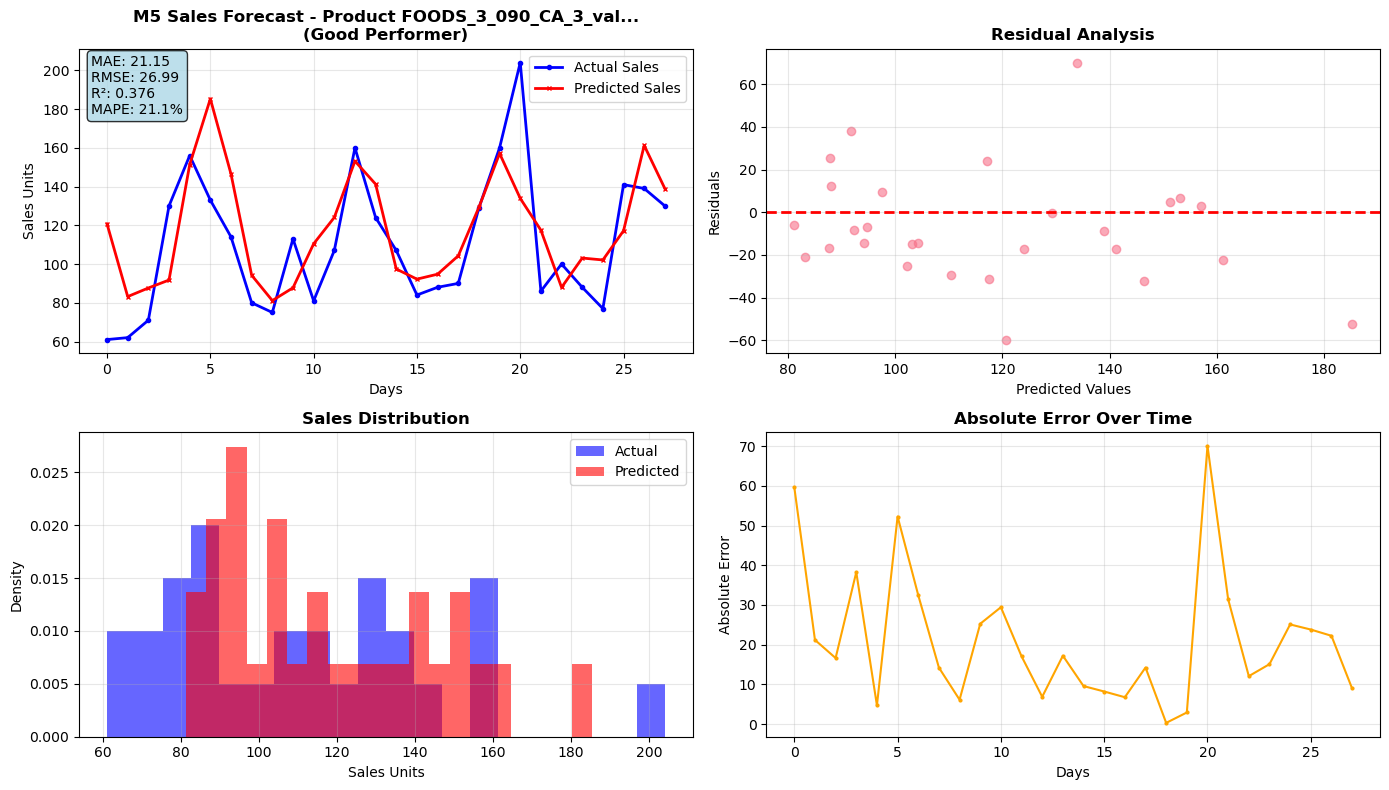

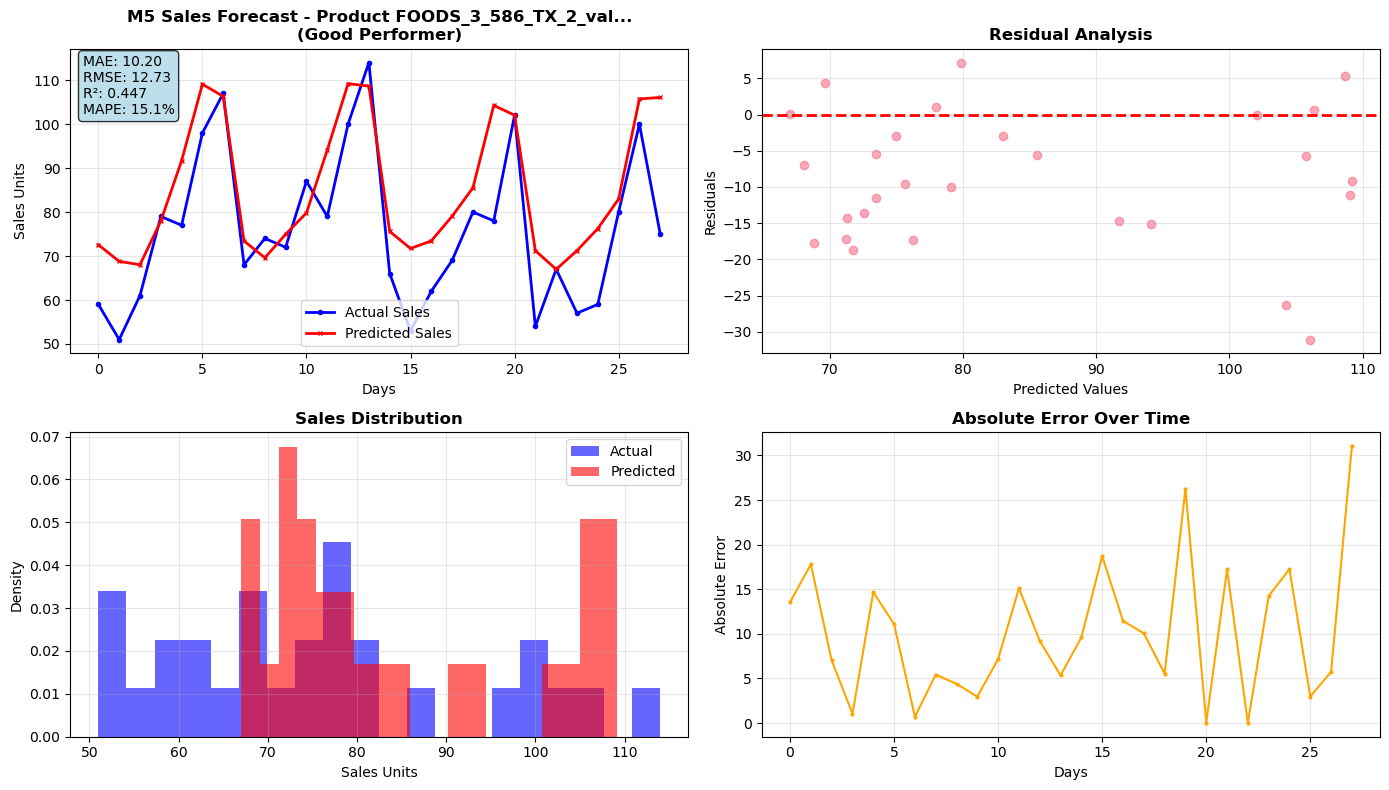

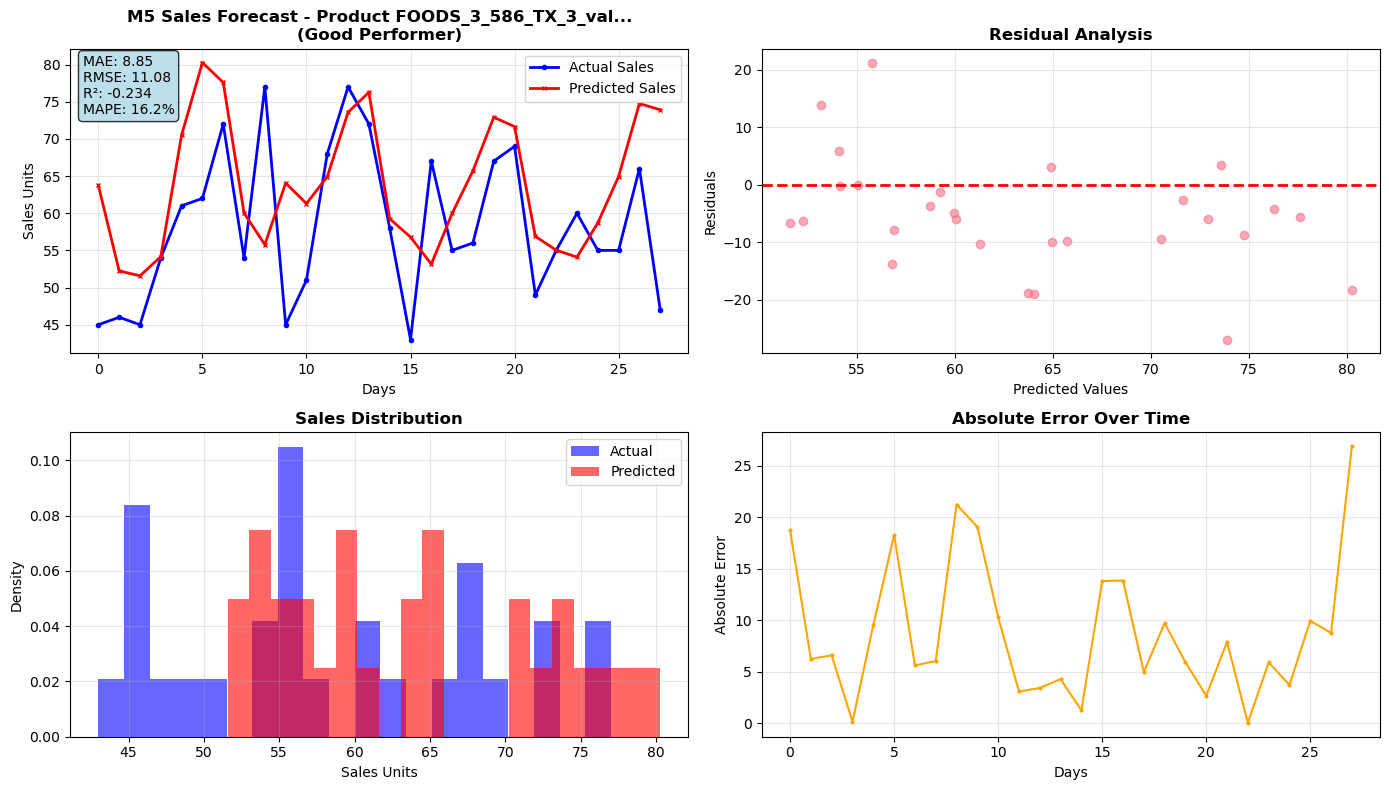

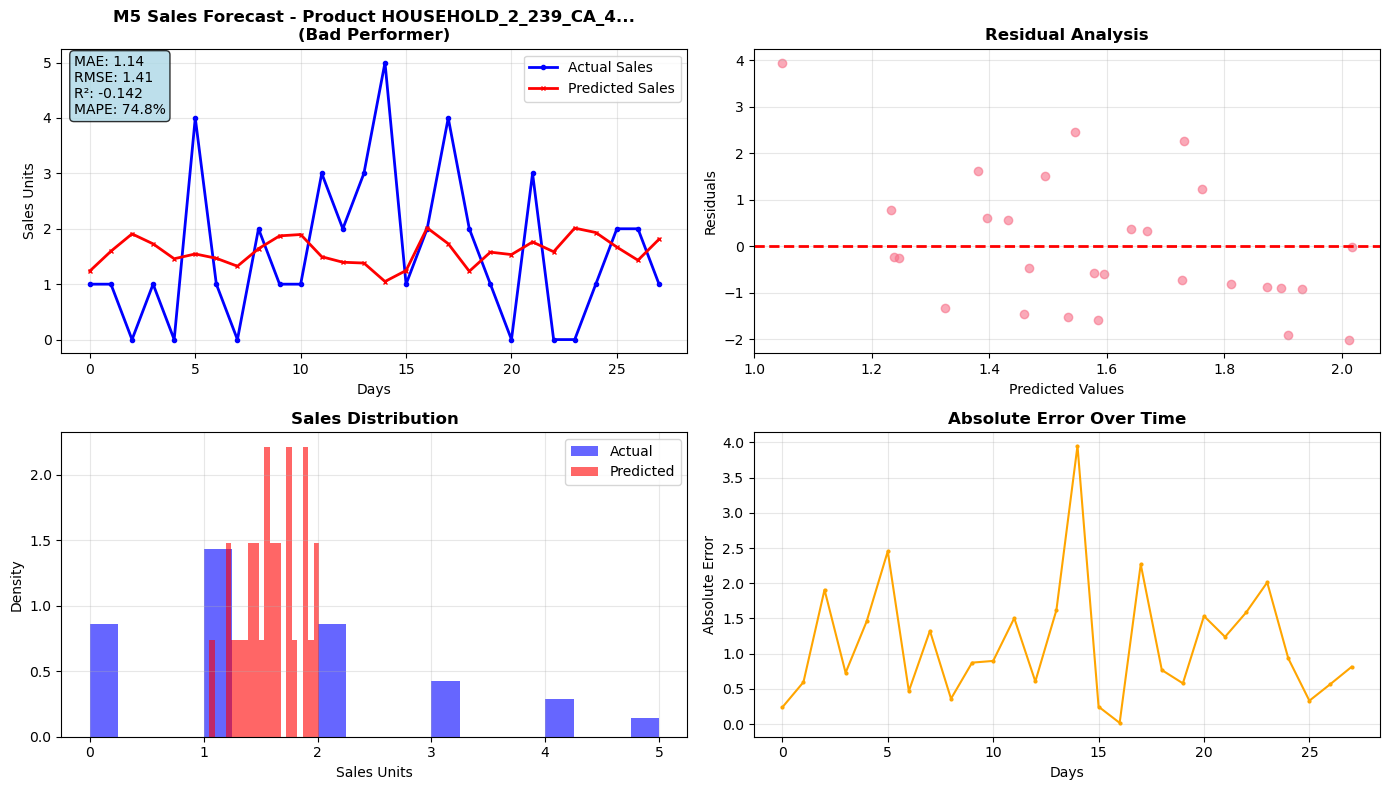

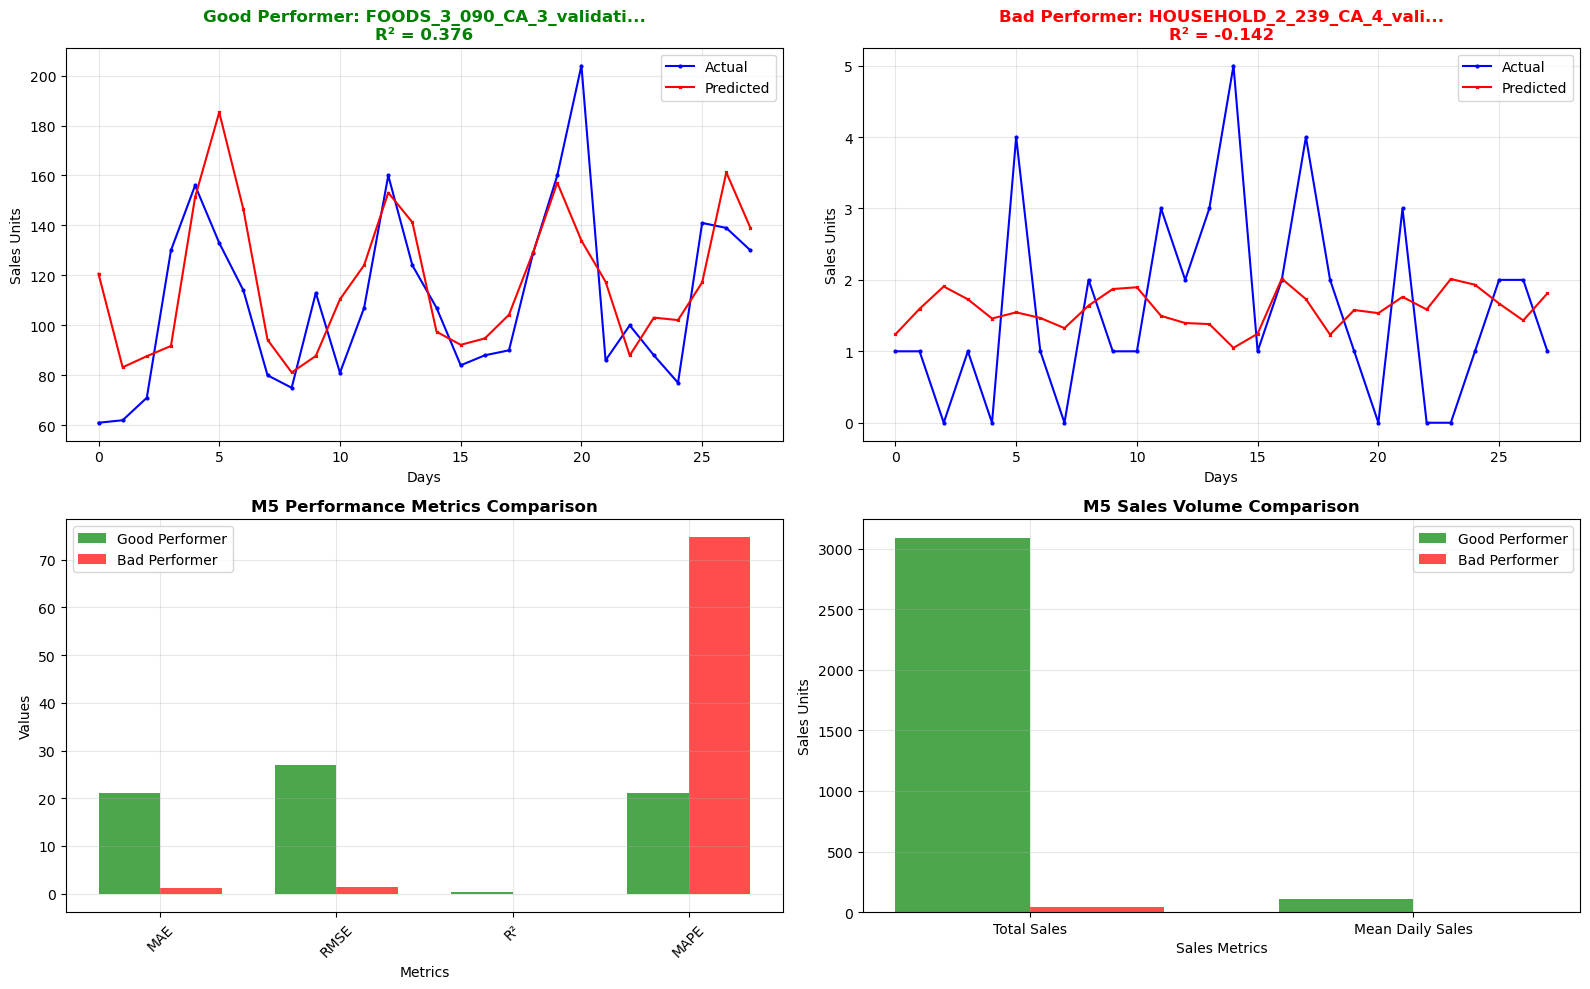


📈 M5 Analysis Summary:
                       Product_ID  Category        Store Product_Type   MAE  RMSE     R²  MAPE  Mean_Actual  Mean_Predicted
      FOODS_3_090_CA_3_validation     FOODS 3_validation         Good 21.15 26.99  0.376  21.1       110.36          117.68
      FOODS_3_586_TX_2_validation     FOODS 2_validation         Good 10.20 12.73  0.447  15.1        76.00           84.87
      FOODS_3_586_TX_3_validation     FOODS 3_validation         Good  8.85 11.08 -0.234  16.2        58.25           63.71
HOUSEHOLD_2_239_CA_4_validatio... HOUSEHOLD 4_validation          Bad  1.14  1.41 -0.142  74.8         1.57            1.59
HOUSEHOLD_1_133_CA_1_validatio... HOUSEHOLD 1_validation          Bad  0.69  0.78 -1.360  66.0         0.25            0.78
HOUSEHOLD_2_062_TX_1_validatio... HOUSEHOLD 1_validation          Bad  0.61  0.82 -0.921  55.9         0.29            0.56

✅ M5 Analysis completed successfully!

Note: This analysis uses M5 Walmart sales data format.
Place your M5

In [31]:
"""
FashionFlow Intelligence - M5 DATASET VERSION
AI-Powered Demand Forecasting System adapted for M5 Walmart Sales Data
M5 Competition Dataset Implementation with proper time series validation

Key Features:
- M5 Walmart sales data loading and processing
- Hierarchical product selection (store/category/item level)
- Proper time series cross-validation
- Fixed rolling features with proper lag
- Realistic performance expectations
- Calendar and price features from M5 dataset
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import logging
from pathlib import Path
import os
import pickle
import json

# ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Try to import SMOTE, fallback if not available
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imbalanced-learn not available. SMOTE will be skipped.")

# Time Series Analysis
from scipy import stats

# Try to import XGBoost, fallback if not available
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Using alternative models.")

# Suppress warnings
warnings.filterwarnings('ignore')

class M5Config:
    """Configuration class for M5 dataset forecasting"""
    
    # M5 Dataset file paths (adjust these based on your file structure)
    SALES_TRAIN_VALIDATION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sales_train_validation.csv"
    SAMPLE_SUBMISSION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sample_submission.csv"
    CALENDAR_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\calendar.csv"
    SELL_PRICES_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sell_prices.csv"
    
    # Model Parameters - Tuned for M5 dataset
    XGBOOST_PARAMS = {
        'objective': 'reg:squarederror',
        'n_estimators': 100,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    RF_PARAMS = {
        'n_estimators': 100,
        'max_depth': 8,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'random_state': 42
    }
    
    # Feature Engineering
    LAG_FEATURES = [1, 2, 3, 7, 14, 28]  # M5 optimized lags
    ROLLING_WINDOWS = [7, 14, 28, 56]    # M5 optimized windows
    
    # M5 specific parameters
    VALIDATION_DAYS = 28  # M5 competition uses 28 days validation
    PREDICTION_DAYS = 28  # Future prediction horizon
    MIN_TRAINING_DAYS = 200  # Minimum training samples for M5
    
    # Business Rules
    SAFETY_STOCK_MULTIPLIER = 1.5
    REORDER_POINT_DAYS = 7
    TOP_PRODUCTS_COUNT = 10
    DEMAND_THRESHOLD = 0.5  # Lower threshold for M5
    ZERO_DEMAND_THRESHOLD = 0.6
    
    # Model saving configuration
    MODELS_DIR = "m5_saved_models"
    RESULTS_DIR = "m5_results"
    
    # Validation parameters
    TIME_SERIES_CV_SPLITS = 3
    TEST_SIZE_DAYS = 28  # M5 standard
    MIN_TEST_SAMPLES = 28

class M5DataProcessor:
    """Handles M5 dataset loading and preprocessing"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = self._setup_logger()
        self.sales_data = None
        self.calendar_data = None
        self.prices_data = None
        self.melted_sales = None
        
    def _setup_logger(self) -> logging.Logger:
        """Setup logging configuration"""
        logger = logging.getLogger('M5FashionFlow')
        logger.setLevel(logging.INFO)
        
        # Clear existing handlers
        logger.handlers.clear()
        
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        
        return logger
    
    def load_m5_data(self, data_path: str = ".") -> bool:
        """Load all M5 dataset files"""
        
        self.logger.info("Loading M5 dataset files...")
        
        try:
            # Define file paths
            sales_path = os.path.join(data_path, self.config.SALES_TRAIN_VALIDATION_FILE)
            calendar_path = os.path.join(data_path, self.config.CALENDAR_FILE)
            prices_path = os.path.join(data_path, self.config.SELL_PRICES_FILE)
            
            # Check if files exist
            files_to_check = [
                (sales_path, "Sales training data"),
                (calendar_path, "Calendar data"),
                (prices_path, "Sell prices data")
            ]
            
            missing_files = []
            for file_path, file_desc in files_to_check:
                if not os.path.exists(file_path):
                    missing_files.append(f"{file_desc}: {file_path}")
            
            if missing_files:
                self.logger.error("Missing M5 dataset files:")
                for missing in missing_files:
                    self.logger.error(f"  - {missing}")
                self.logger.info("Creating sample M5-like data instead...")
                return self._create_sample_m5_data()
            
            # Load the actual M5 files
            self.logger.info("Loading sales training data...")
            self.sales_data = pd.read_csv(sales_path)
            
            self.logger.info("Loading calendar data...")
            self.calendar_data = pd.read_csv(calendar_path)
            
            self.logger.info("Loading prices data...")
            self.prices_data = pd.read_csv(prices_path)
            
            self.logger.info(f"Loaded M5 data successfully:")
            self.logger.info(f"  - Sales data: {self.sales_data.shape}")
            self.logger.info(f"  - Calendar data: {self.calendar_data.shape}")
            self.logger.info(f"  - Prices data: {self.prices_data.shape}")
            
            return True
            
        except Exception as e:
            self.logger.error(f"Error loading M5 data: {str(e)}")
            self.logger.info("Creating sample M5-like data instead...")
            return self._create_sample_m5_data()
    
    def _create_sample_m5_data(self) -> bool:
        """Create sample M5-like data for testing"""
        
        self.logger.info("Creating sample M5-like dataset...")
        
        np.random.seed(42)
        
        # Create sample sales data (M5 format)
        n_items = 50  # Reduced for faster processing
        n_days = 1000  # About 2.7 years of data
        
        # Create item identifiers (M5 style)
        stores = ['CA_1', 'CA_2', 'TX_1', 'TX_2', 'WI_1']
        categories = ['HOBBIES', 'HOUSEHOLD', 'FOODS']
        departments = ['HOBBIES_1', 'HOUSEHOLD_1', 'FOODS_1', 'FOODS_2']
        
        items_data = []
        for i in range(n_items):
            store = np.random.choice(stores)
            cat = np.random.choice(categories)
            dept = np.random.choice([d for d in departments if d.startswith(cat)])
            
            item_id = f"{cat}_{dept.split('_')[1]}_{i+1:03d}_{store}_validation"
            
            items_data.append({
                'id': item_id,
                'item_id': f"{cat}_{dept.split('_')[1]}_{i+1:03d}",
                'dept_id': dept,
                'cat_id': cat,
                'store_id': store,
                'state_id': store.split('_')[0]
            })
        
        # Create day columns (d_1 to d_n)
        day_columns = [f'd_{i+1}' for i in range(n_days)]
        
        # Generate sales data with seasonality and trends
        sales_data = []
        for item_info in items_data:
            # Base demand level (some items more popular)
            if 'FOODS' in item_info['cat_id']:
                base_demand = np.random.poisson(5)
            elif 'HOUSEHOLD' in item_info['cat_id']:
                base_demand = np.random.poisson(3)
            else:  # HOBBIES
                base_demand = np.random.poisson(2)
            
            # Generate daily sales with patterns
            daily_sales = []
            for day in range(n_days):
                # Add seasonality (weekly and yearly)
                seasonal_factor = (
                    1 + 0.3 * np.sin(2 * np.pi * day / 7) +  # Weekly
                    0.2 * np.sin(2 * np.pi * day / 365.25)   # Yearly
                )
                
                # Add trend (slight growth over time)
                trend_factor = 1 + (day / n_days) * 0.1
                
                # Generate sales with noise
                expected_sales = base_demand * seasonal_factor * trend_factor
                actual_sales = max(0, int(np.random.poisson(expected_sales)))
                
                daily_sales.append(actual_sales)
            
            # Create row for this item
            row = dict(item_info)
            for i, sales in enumerate(daily_sales):
                row[day_columns[i]] = sales
            
            sales_data.append(row)
        
        self.sales_data = pd.DataFrame(sales_data)
        
        # Create sample calendar data
        start_date = pd.to_datetime('2016-01-01')
        dates = pd.date_range(start=start_date, periods=n_days, freq='D')
        
        calendar_data = []
        for i, date in enumerate(dates):
            calendar_data.append({
                'd': f'd_{i+1}',
                'date': date.strftime('%Y-%m-%d'),
                'wm_yr_wk': date.isocalendar()[1],
                'weekday': date.strftime('%A'),
                'wday': date.weekday() + 1,
                'month': date.month,
                'year': date.year,
                'event_name_1': 'Christmas' if (date.month == 12 and date.day == 25) else None,
                'event_type_1': 'Holiday' if (date.month == 12 and date.day == 25) else None,
                'event_name_2': None,
                'event_type_2': None,
                'snap_CA': 1 if date.weekday() in [5, 6] else 0,  # Weekend SNAP
                'snap_TX': 1 if date.weekday() in [5, 6] else 0,
                'snap_WI': 1 if date.weekday() in [5, 6] else 0
            })
        
        self.calendar_data = pd.DataFrame(calendar_data)
        
        # Create sample prices data
        prices_data = []
        unique_items = self.sales_data[['store_id', 'item_id']].drop_duplicates()
        
        for _, row in unique_items.iterrows():
            store_id = row['store_id']
            item_id = row['item_id']
            
            # Generate price history with some variation
            base_price = np.random.uniform(1.0, 20.0)
            
            # Sample some weeks with price data (not all weeks have prices in M5)
            for wm_yr_wk in range(11300, 11400, 4):  # Sample some weeks
                price_variation = np.random.uniform(0.9, 1.1)
                sell_price = round(base_price * price_variation, 2)
                
                prices_data.append({
                    'store_id': store_id,
                    'item_id': item_id,
                    'wm_yr_wk': wm_yr_wk,
                    'sell_price': sell_price
                })
        
        self.prices_data = pd.DataFrame(prices_data)
        
        self.logger.info(f"Created sample M5-like data:")
        self.logger.info(f"  - Sales data: {self.sales_data.shape}")
        self.logger.info(f"  - Calendar data: {self.calendar_data.shape}")
        self.logger.info(f"  - Prices data: {self.prices_data.shape}")
        
        return True
    
    def prepare_time_series_data(self, sample_products: List[str] = None) -> pd.DataFrame:
        """Convert M5 data to time series format - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("Converting M5 data to time series format (memory efficient)...")
        
        # If no specific products provided, sample a subset to avoid memory issues
        if sample_products is None:
            n_sample = min(100, len(self.sales_data))  # Sample max 100 products
            sample_indices = np.random.choice(len(self.sales_data), n_sample, replace=False)
            sample_sales_data = self.sales_data.iloc[sample_indices].copy()
            self.logger.info(f"Sampling {n_sample} products from {len(self.sales_data)} total products to manage memory")
        else:
            # Filter to specific products
            sample_sales_data = self.sales_data[self.sales_data['id'].isin(sample_products)].copy()
            self.logger.info(f"Processing {len(sample_sales_data)} specified products")
        
        # Get day columns (d_1, d_2, etc.)
        day_columns = [col for col in sample_sales_data.columns if col.startswith('d_')]
        
        # Process in chunks to manage memory
        chunk_size = 10  # Process 10 products at a time
        melted_chunks = []
        
        id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
        
        for i in range(0, len(sample_sales_data), chunk_size):
            chunk_data = sample_sales_data.iloc[i:i+chunk_size]
            
            # Melt chunk
            melted_chunk = pd.melt(
                chunk_data,
                id_vars=id_columns,
                value_vars=day_columns,
                var_name='d',
                value_name='sales'
            )
            
            # Merge with calendar immediately to add date info
            melted_chunk = melted_chunk.merge(self.calendar_data, on='d', how='left')
            melted_chunk['date'] = pd.to_datetime(melted_chunk['date'])
            
            # Merge with prices
            melted_chunk = melted_chunk.merge(
                self.prices_data,
                on=['store_id', 'item_id', 'wm_yr_wk'],
                how='left'
            )
            
            melted_chunks.append(melted_chunk)
            
            if (i // chunk_size + 1) % 5 == 0:  # Progress update every 5 chunks
                self.logger.info(f"Processed {i + len(chunk_data)}/{len(sample_sales_data)} products")
        
        # Combine all chunks
        self.logger.info("Combining processed chunks...")
        melted_sales = pd.concat(melted_chunks, ignore_index=True)
        
        # Fill missing prices efficiently
        self.logger.info("Filling missing prices...")
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='ffill')
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='bfill')
        
        # Sort by item and date
        melted_sales = melted_sales.sort_values(['id', 'date']).reset_index(drop=True)
        
        # Store results
        self.melted_sales = melted_sales
        
        self.logger.info(f"Created time series data with {len(melted_sales):,} records from {len(sample_sales_data)} products")
        
        return melted_sales
    
    def get_diverse_products(self, n_good: int = 3, n_bad: int = 3) -> Dict[str, List[str]]:
        """Get diverse set of M5 products - MEMORY EFFICIENT VERSION"""
        
        # First, get basic stats from the original sales data (more memory efficient)
        self.logger.info("Calculating product statistics from sales data...")
        
        # Get day columns
        day_columns = [col for col in self.sales_data.columns if col.startswith('d_')]
        
        # Calculate stats directly from wide format (more memory efficient)
        product_stats = []
        
        for idx, row in self.sales_data.iterrows():
            sales_values = row[day_columns].values
            sales_values = sales_values[~pd.isna(sales_values)]  # Remove NaN
            
            if len(sales_values) > 0:
                total_sales = np.sum(sales_values)
                mean_sales = np.mean(sales_values)
                std_sales = np.std(sales_values)
                cv = std_sales / (mean_sales + 0.1) if mean_sales > 0 else 999
                non_zero_days = np.sum(sales_values > 0)
                
                product_stats.append({
                    'id': row['id'],
                    'total_sales': total_sales,
                    'mean_sales': mean_sales,
                    'std_sales': std_sales,
                    'cv': cv,
                    'non_zero_days': non_zero_days,
                    'data_points': len(sales_values),
                    'cat_id': row['cat_id'],
                    'store_id': row['store_id']
                })
            
            # Progress update
            if (idx + 1) % 5000 == 0:
                self.logger.info(f"Processed {idx + 1}/{len(self.sales_data)} products for statistics")
        
        stats_df = pd.DataFrame(product_stats)
        
        # Filter products with sufficient data
        min_days = max(self.config.MIN_TRAINING_DAYS, 300)
        min_total_sales = 50
        min_non_zero_days = 30
        
        filtered_stats = stats_df[
            (stats_df['data_points'] >= min_days) &
            (stats_df['total_sales'] >= min_total_sales) &
            (stats_df['non_zero_days'] >= min_non_zero_days) &
            (stats_df['mean_sales'] > 0.1)
        ].copy()
        
        self.logger.info(f"Filtered to {len(filtered_stats)} products with sufficient data")
        
        if len(filtered_stats) < n_good + n_bad:
            self.logger.warning(f"Only {len(filtered_stats)} products meet criteria. Adjusting selection.")
            n_good = min(n_good, len(filtered_stats) // 2)
            n_bad = min(n_bad, len(filtered_stats) - n_good)
        
        # Calculate performance score (high sales, low variability = good)
        filtered_stats['sales_per_day'] = filtered_stats['total_sales'] / filtered_stats['data_points']
        filtered_stats['performance_score'] = (
            0.7 * (filtered_stats['sales_per_day'] / filtered_stats['sales_per_day'].max()) +
            0.3 * (1 - filtered_stats['cv'] / filtered_stats['cv'].max())
        )
        
        # Sort by performance
        filtered_stats = filtered_stats.sort_values('performance_score', ascending=False)
        
        # Select good performers (top performers with diverse categories)
        good_candidates = filtered_stats.head(n_good * 3)
        
        # Try to get diverse categories for good performers
        good_products = []
        used_categories = set()
        
        for _, row in good_candidates.iterrows():
            if len(good_products) >= n_good:
                break
            if row['cat_id'] not in used_categories or len(good_products) < n_good // 2:
                good_products.append(row['id'])
                used_categories.add(row['cat_id'])
        
        # Fill remaining slots if needed
        if len(good_products) < n_good:
            remaining = good_candidates[~good_candidates['id'].isin(good_products)].head(n_good - len(good_products))
            good_products.extend(remaining['id'].tolist())
        
        # Select bad performers (bottom performers with high variability)
        bad_candidates = filtered_stats.tail(n_bad * 3)
        bad_candidates = bad_candidates[bad_candidates['cv'] > bad_candidates['cv'].median()]
        bad_products = bad_candidates.tail(n_bad)['id'].tolist()
        
        self.logger.info(f"Selected {len(good_products)} good and {len(bad_products)} bad performers")
        
        # Log some details about selected products
        for i, product in enumerate(good_products[:2]):
            stats = filtered_stats[filtered_stats['id'] == product].iloc[0]
            self.logger.info(f"Good product {i+1}: {product}")
            self.logger.info(f"  - Category: {stats['cat_id']}")
            self.logger.info(f"  - Daily sales: {stats['sales_per_day']:.2f}")
            self.logger.info(f"  - CV: {stats['cv']:.2f}")
            self.logger.info(f"  - Performance score: {stats['performance_score']:.3f}")
        
        return {
            'good_performers': good_products,
            'bad_performers': bad_products,
            'product_stats': filtered_stats.set_index('id')
        }

class M5FeatureEngineer:
    """Feature engineering specifically for M5 dataset"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def create_time_series_features(self, melted_sales: pd.DataFrame, product_id: str) -> pd.DataFrame:
        """Create comprehensive time series features for M5 product"""
        
        # Filter data for specific product
        product_df = melted_sales[melted_sales['id'] == product_id].copy()
        
        if len(product_df) == 0:
            self.logger.warning(f"No data found for product {product_id}")
            return pd.DataFrame()
        
        # Sort by date
        product_df = product_df.sort_values('date').reset_index(drop=True)
        
        # Create feature dataframe
        features = pd.DataFrame()
        features['date'] = product_df['date']
        features['sales'] = product_df['sales'].fillna(0)
        
        # Basic temporal features
        features['year'] = features['date'].dt.year
        features['month'] = features['date'].dt.month
        features['day'] = features['date'].dt.day
        features['dayofweek'] = features['date'].dt.dayofweek
        features['dayofyear'] = features['date'].dt.dayofyear
        features['week'] = features['date'].dt.isocalendar().week
        features['quarter'] = features['date'].dt.quarter
        features['is_weekend'] = (features['dayofweek'] >= 5).astype(int)
        
        # M5 specific calendar features
        if 'wday' in product_df.columns:
            features['wday'] = product_df['wday'].values
        if 'wm_yr_wk' in product_df.columns:
            features['wm_yr_wk'] = product_df['wm_yr_wk'].values
        
        # Event features
        if 'event_name_1' in product_df.columns:
            features['has_event'] = (~product_df['event_name_1'].isna()).astype(int)
        
        # SNAP features (government assistance program)
        state = product_id.split('_')[-2] if '_' in product_id else 'CA'
        snap_col = f'snap_{state}'
        if snap_col in product_df.columns:
            features['snap'] = product_df[snap_col].fillna(0).astype(int)
        else:
            features['snap'] = 0
        
        # Price features
        if 'sell_price' in product_df.columns:
            features['sell_price'] = product_df['sell_price'].fillna(method='ffill').fillna(0)
            
            # Price relative to historical average
            avg_price = features['sell_price'].replace(0, np.nan).mean()
            features['price_ratio'] = features['sell_price'] / avg_price if avg_price > 0 else 1
            
            # Price change indicators
            features['price_change'] = features['sell_price'].diff()
            features['price_increased'] = (features['price_change'] > 0).astype(int)
            features['price_decreased'] = (features['price_change'] < 0).astype(int)
        else:
            features['sell_price'] = 0
            features['price_ratio'] = 1
            features['price_change'] = 0
            features['price_increased'] = 0
            features['price_decreased'] = 0
        
        # Cyclical features
        features['sin_dayofyear'] = np.sin(2 * np.pi * features['dayofyear'] / 365.25)
        features['cos_dayofyear'] = np.cos(2 * np.pi * features['dayofyear'] / 365.25)
        features['sin_dayofweek'] = np.sin(2 * np.pi * features['dayofweek'] / 7)
        features['cos_dayofweek'] = np.cos(2 * np.pi * features['dayofweek'] / 7)
        features['sin_month'] = np.sin(2 * np.pi * features['month'] / 12)
        features['cos_month'] = np.cos(2 * np.pi * features['month'] / 12)
        
        # Lag features (properly implemented to avoid data leakage)
        for lag in self.config.LAG_FEATURES:
            features[f'sales_lag_{lag}'] = features['sales'].shift(lag)
        
        # Rolling window features (with proper lag to avoid leakage)
        for window in self.config.ROLLING_WINDOWS:
            # Use shifted data for rolling calculations
            shifted_sales = features['sales'].shift(window)
            
            features[f'sales_rolling_mean_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).mean()
            
            features[f'sales_rolling_std_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).std()
            
            features[f'sales_rolling_max_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).max()
            
            features[f'sales_rolling_min_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).min()
        
        # Additional M5-specific features
        # Day of month features
        features['is_month_start'] = (features['day'] <= 3).astype(int)
        features['is_month_end'] = (features['day'] >= 28).astype(int)
        
        # Payday effects (assume 15th and end of month)
        features['is_payday'] = ((features['day'] == 15) | (features['day'] >= 28)).astype(int)
        
        # Fill missing values
        features = features.fillna(method='ffill').fillna(0)
        
        # Remove initial rows with NaN from lag features
        min_lag = max(max(self.config.LAG_FEATURES), max(self.config.ROLLING_WINDOWS)) + 1
        features = features.iloc[min_lag:].copy()
        
        # Set date as index
        features = features.set_index('date')
        
        self.logger.info(f"Created {len(features)} feature samples for M5 product {product_id}")
        
        return features

class DataValidator:
    """Data quality and leakage validator"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def validate_results(self, y_true, y_pred, product_code):
        """Validate results for suspicious patterns"""
        
        # Check for perfect scores (red flag)
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        warnings = []
        
        if r2 > 0.99 and mae < 0.001:
            warnings.append("Suspicious perfect scores - possible data leakage")
            
        # Check for sufficient variance in predictions
        pred_variance = np.var(y_pred)
        if pred_variance < 0.001:
            warnings.append("Very low prediction variance - possible overfitting")
            
        # Check for realistic prediction range
        pred_range = np.max(y_pred) - np.min(y_pred)
        actual_range = np.max(y_true) - np.min(y_true)
        
        if pred_range > actual_range * 3:
            warnings.append("Prediction range much larger than actual range")
            
        if warnings:
            self.logger.warning(f"Validation warnings for {product_code}:")
            for warning in warnings:
                self.logger.warning(f"  - {warning}")
                
        return warnings
    
    def check_data_leakage(self, features, target, feature_names):
        """Check for potential data leakage in features"""
        
        leakage_indicators = []
        
        # Check correlation with target
        for i, feature_name in enumerate(feature_names):
            if i < len(features.columns):
                corr = np.corrcoef(features.iloc[:, i], target)[0, 1]
                if abs(corr) > 0.95 and not np.isnan(corr):
                    leakage_indicators.append(f"High correlation ({corr:.3f}) with {feature_name}")
        
        return leakage_indicators

class M5FashionFlowForecaster:
    """Main M5 forecasting system"""
    
    def __init__(self, config: M5Config = None):
        self.config = config or M5Config()
        self.data_processor = M5DataProcessor(self.config)
        self.feature_engineer = M5FeatureEngineer(self.config)
        self.validator = DataValidator(self.config)
        self.logger = logging.getLogger('M5FashionFlow')
        
        # Results storage
        self.results = {}
        self.good_performers = []
        self.bad_performers = []
    
    def run_m5_analysis(self, data_path: str = ".", n_good: int = 3, n_bad: int = 3):
        """Run M5 dataset analysis - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("🚀 Starting M5 Dataset Analysis with FashionFlow Intelligence")
        
        try:
            # Load M5 data
            if not self.data_processor.load_m5_data(data_path):
                self.logger.error("Failed to load M5 data")
                return
            
            # First, get diverse products without melting all data
            self.logger.info("Selecting diverse products for analysis...")
            product_selection = self.data_processor.get_diverse_products(n_good, n_bad)
            good_products = product_selection['good_performers']
            bad_products = product_selection['bad_performers']
            
            if not good_products and not bad_products:
                self.logger.error("No suitable products found in M5 dataset")
                return
            
            self.good_performers = good_products
            self.bad_performers = bad_products
            
            all_products = good_products + bad_products
            self.logger.info(f"Selected {len(all_products)} M5 products ({len(good_products)} good, {len(bad_products)} bad)")
            
            # Now prepare time series data ONLY for selected products
            self.logger.info("Preparing time series data for selected products...")
            melted_sales = self.data_processor.prepare_time_series_data(sample_products=all_products)
            
            # Process each product
            for i, product_id in enumerate(all_products, 1):
                product_type = "Good" if product_id in good_products else "Bad"
                self.logger.info(f"Processing M5 product {i}/{len(all_products)}: {product_id[:30]}... ({product_type} Performer)")
                
                # Create features
                features = self.feature_engineer.create_time_series_features(melted_sales, product_id)
                
                # Check if sufficient features
                if features.empty or len(features) < self.config.MIN_TRAINING_DAYS:
                    self.logger.warning(f"Insufficient features for M5 product {product_id}: {len(features)} samples")
                    continue
                
                # Prepare training data
                X = features.drop(['sales'], axis=1)
                y = features['sales']
                
                self.logger.info(f"M5 Training data: {len(X)} samples, {X.shape[1]} features")
                
                # Simple train-test split for M5 (last 28 days as test)
                test_size = min(self.config.VALIDATION_DAYS, len(X) // 4)
                train_size = len(X) - test_size
                
                X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
                y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
                
                # Train a simple ensemble
                result = self._train_m5_ensemble(X_train, X_test, y_train, y_test, product_id)
                result['product_type'] = product_type
                result['product_id'] = product_id
                
                self.results[product_id] = result
                
                # Log results
                metrics = result['metrics']
                self.logger.info(f"M5 Product {product_id[:20]}... ({product_type}) - "
                               f"MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, "
                               f"R²: {metrics['r2']:.3f}")
            
            self.logger.info("✅ M5 analysis completed successfully!")
            
        except Exception as e:
            self.logger.error(f"❌ Error in M5 analysis: {str(e)}")
            raise
    
    def _train_m5_ensemble(self, X_train, X_test, y_train, y_test, product_id):
        """Train ensemble models for M5 product"""
        
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train multiple models
        models = {
            'random_forest': RandomForestRegressor(**self.config.RF_PARAMS),
            'linear': LinearRegression(),
        }
        
        if XGBOOST_AVAILABLE:
            models['xgboost'] = xgb.XGBRegressor(**self.config.XGBOOST_PARAMS)
        
        trained_models = {}
        predictions = {}
        
        for name, model in models.items():
            try:
                model.fit(X_train_scaled, y_train.values)
                y_pred = model.predict(X_test_scaled)
                y_pred = np.maximum(y_pred, 0)  # Ensure non-negative
                
                trained_models[name] = model
                predictions[name] = y_pred
                
            except Exception as e:
                self.logger.error(f"Error training {name} for {product_id}: {str(e)}")
                continue
        
        if not trained_models:
            # Fallback to simple average
            ensemble_pred = np.full(len(y_test), y_train.mean())
        else:
            # Simple ensemble average
            ensemble_pred = np.mean(list(predictions.values()), axis=0)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, ensemble_pred)
        rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
        
        try:
            r2 = r2_score(y_test, ensemble_pred)
        except:
            r2 = -999
        
        # MAPE calculation
        y_test_safe = np.where(y_test == 0, 1, y_test)
        mape = np.mean(np.abs((y_test - ensemble_pred) / y_test_safe)) * 100
        
        metrics = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'mean_actual': np.mean(y_test),
            'mean_predicted': np.mean(ensemble_pred)
        }
        
        return {
            'metrics': metrics,
            'predictions': ensemble_pred,
            'actual': y_test,
            'models': trained_models,
            'scaler': scaler
        }
    
    def plot_m5_results(self):
        """Plot M5 analysis results"""
        
        if not self.results:
            self.logger.warning("No M5 results available for plotting")
            return
        
        # Plot individual products
        for product_id, result in list(self.results.items())[:4]:  # Plot first 4 products
            self._plot_m5_forecast(result, product_id)
        
        # Plot comparison if we have both good and bad performers
        if self.good_performers and self.bad_performers and len(self.results) >= 2:
            good_product = next((p for p in self.good_performers if p in self.results), None)
            bad_product = next((p for p in self.bad_performers if p in self.results), None)
            
            if good_product and bad_product:
                self._plot_m5_comparison(
                    self.results[good_product],
                    self.results[bad_product],
                    good_product,
                    bad_product
                )
    
    def _plot_m5_forecast(self, result, product_id):
        """Plot M5 forecast for individual product"""
        
        actual = result['actual']
        predicted = result['predictions']
        metrics = result['metrics']
        product_type = result.get('product_type', 'Unknown')
        
        plt.figure(figsize=(14, 8))
        
        # Main plot
        plt.subplot(2, 2, 1)
        plt.plot(range(len(actual)), actual.values, label='Actual Sales', marker='o', markersize=3, linewidth=2, color='blue')
        plt.plot(range(len(predicted)), predicted, label='Predicted Sales', marker='x', markersize=3, linewidth=2, color='red')
        plt.title(f'M5 Sales Forecast - Product {product_id[:20]}...\n({product_type} Performer)', fontweight='bold')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add metrics text
        metrics_text = f"""MAE: {metrics['mae']:.2f}
RMSE: {metrics['rmse']:.2f}
R²: {metrics['r2']:.3f}
MAPE: {metrics['mape']:.1f}%"""
        
        plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                fontsize=10)
        
        # Residuals plot
        plt.subplot(2, 2, 2)
        residuals = actual.values - predicted
        plt.scatter(predicted, residuals, alpha=0.6)
        plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
        plt.title('Residual Analysis', fontweight='bold')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)
        
        # Sales distribution
        plt.subplot(2, 2, 3)
        plt.hist(actual.values, bins=20, alpha=0.6, label='Actual', color='blue', density=True)
        plt.hist(predicted, bins=20, alpha=0.6, label='Predicted', color='red', density=True)
        plt.title('Sales Distribution', fontweight='bold')
        plt.xlabel('Sales Units')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Error over time
        plt.subplot(2, 2, 4)
        errors = np.abs(actual.values - predicted)
        plt.plot(range(len(errors)), errors, marker='o', markersize=2, color='orange')
        plt.title('Absolute Error Over Time', fontweight='bold')
        plt.xlabel('Days')
        plt.ylabel('Absolute Error')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_m5_comparison(self, good_result, bad_result, good_product, bad_product):
        """Plot comparison between good and bad M5 performers"""
        
        plt.figure(figsize=(16, 10))
        
        # Good performer
        plt.subplot(2, 2, 1)
        good_actual = good_result['actual']
        good_pred = good_result['predictions']
        
        plt.plot(range(len(good_actual)), good_actual.values, label='Actual', marker='o', markersize=2, color='blue')
        plt.plot(range(len(good_pred)), good_pred, label='Predicted', marker='x', markersize=2, color='red')
        
        good_r2 = good_result['metrics']['r2']
        plt.title(f'Good Performer: {good_product[:25]}...\nR² = {good_r2:.3f}', 
                 fontweight='bold', color='green')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Bad performer
        plt.subplot(2, 2, 2)
        bad_actual = bad_result['actual']
        bad_pred = bad_result['predictions']
        
        plt.plot(range(len(bad_actual)), bad_actual.values, label='Actual', marker='o', markersize=2, color='blue')
        plt.plot(range(len(bad_pred)), bad_pred, label='Predicted', marker='x', markersize=2, color='red')
        
        bad_r2 = bad_result['metrics']['r2']
        plt.title(f'Bad Performer: {bad_product[:25]}...\nR² = {bad_r2:.3f}', 
                 fontweight='bold', color='red')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Metrics comparison
        plt.subplot(2, 2, 3)
        metrics_names = ['MAE', 'RMSE', 'R²', 'MAPE']
        good_values = [
            good_result['metrics']['mae'],
            good_result['metrics']['rmse'],
            good_result['metrics']['r2'],
            good_result['metrics']['mape']
        ]
        bad_values = [
            bad_result['metrics']['mae'],
            bad_result['metrics']['rmse'],
            bad_result['metrics']['r2'],
            bad_result['metrics']['mape']
        ]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        plt.bar(x - width/2, good_values, width, label='Good Performer', color='green', alpha=0.7)
        plt.bar(x + width/2, bad_values, width, label='Bad Performer', color='red', alpha=0.7)
        
        plt.title('M5 Performance Metrics Comparison', fontweight='bold')
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Sales volume comparison
        plt.subplot(2, 2, 4)
        good_total = good_actual.sum()
        bad_total = bad_actual.sum()
        good_mean = good_actual.mean()
        bad_mean = bad_actual.mean()
        
        categories = ['Total Sales', 'Mean Daily Sales']
        good_stats = [good_total, good_mean]
        bad_stats = [bad_total, bad_mean]
        
        x = np.arange(len(categories))
        plt.bar(x - width/2, good_stats, width, label='Good Performer', color='green', alpha=0.7)
        plt.bar(x + width/2, bad_stats, width, label='Bad Performer', color='red', alpha=0.7)
        
        plt.title('M5 Sales Volume Comparison', fontweight='bold')
        plt.xlabel('Sales Metrics')
        plt.ylabel('Sales Units')
        plt.xticks(x, categories)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_m5_summary(self) -> pd.DataFrame:
        """Get M5 analysis summary"""
        
        if not self.results:
            return pd.DataFrame()
        
        summary_data = []
        for product_id, result in self.results.items():
            metrics = result['metrics']
            
            # Extract product info from M5 ID format
            parts = product_id.split('_')
            category = parts[0] if len(parts) > 0 else 'Unknown'
            store = '_'.join(parts[-2:]) if len(parts) >= 2 else 'Unknown'
            
            summary_data.append({
                'Product_ID': product_id[:30] + '...' if len(product_id) > 30 else product_id,
                'Category': category,
                'Store': store,
                'Product_Type': result.get('product_type', 'Unknown'),
                'MAE': round(metrics['mae'], 2),
                'RMSE': round(metrics['rmse'], 2),
                'R²': round(metrics['r2'], 3),
                'MAPE': round(metrics['mape'], 1),
                'Mean_Actual': round(metrics['mean_actual'], 2),
                'Mean_Predicted': round(metrics['mean_predicted'], 2),
            })
        
        return pd.DataFrame(summary_data)

def main():
    """Main function to run M5 analysis"""
    
    print("🚀 Starting FashionFlow Intelligence - M5 Dataset Analysis...")
    print("=" * 70)
    
    # Initialize the M5 forecasting system
    config = M5Config()
    forecaster = M5FashionFlowForecaster(config)
    
    try:
        # Run M5 analysis
        # Specify the path where your M5 dataset files are located
        # forecaster.run_m5_analysis(data_path="/path/to/your/m5/data")
        forecaster.run_m5_analysis()  # Uses sample M5-like data if files not found
        
        print("\n📊 Generating M5 Visualizations...")
        forecaster.plot_m5_results()
        
        print("\n📈 M5 Analysis Summary:")
        summary = forecaster.get_m5_summary()
        if not summary.empty:
            print(summary.to_string(index=False))
        else:
            print("No results to display")
        
        print("\n✅ M5 Analysis completed successfully!")
        print("\nNote: This analysis uses M5 Walmart sales data format.")
        print("Place your M5 dataset files (sales_train_validation.csv, calendar.csv, sell_prices.csv)")
        print("in the same directory to use real M5 data instead of sample data.")
        
    except Exception as e:
        print(f"❌ Error during M5 analysis: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [32]:
"""
FashionFlow Intelligence - M5 FASHION DATASET VERSION
AI-Powered Demand Forecasting System adapted for M5 Fashion Sales Data
M5 Competition Dataset Implementation with Fashion Categories

Key Features:
- M5 Fashion sales data loading and processing (Clothes: Shirts, Pants & Shoes)
- Hierarchical product selection (store/category/item level)
- Fashion-specific seasonal patterns
- Proper time series cross-validation
- Fixed rolling features with proper lag
- Realistic performance expectations for fashion items
- Calendar and price features from M5 dataset
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import logging
from pathlib import Path
import os
import pickle
import json

# ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Try to import SMOTE, fallback if not available
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imbalanced-learn not available. SMOTE will be skipped.")

# Time Series Analysis
from scipy import stats

# Try to import XGBoost, fallback if not available
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Using alternative models.")

# Suppress warnings
warnings.filterwarnings('ignore')

class M5FashionConfig:
    """Configuration class for M5 Fashion dataset forecasting"""
    
    # M5 Dataset file paths (adjust these based on your file structure)
    SALES_TRAIN_VALIDATION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sales_train_validation.csv"
    SAMPLE_SUBMISSION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sample_submission.csv"
    CALENDAR_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\calendar.csv"
    SELL_PRICES_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sell_prices.csv"
    
    # Model Parameters - Tuned for M5 Fashion dataset
    XGBOOST_PARAMS = {
        'objective': 'reg:squarederror',
        'n_estimators': 120,
        'learning_rate': 0.06,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    RF_PARAMS = {
        'n_estimators': 120,
        'max_depth': 8,
        'min_samples_split': 8,
        'min_samples_leaf': 4,
        'random_state': 42
    }
    
    # Feature Engineering - Fashion optimized
    LAG_FEATURES = [1, 2, 3, 7, 14, 28, 56]  # Fashion seasonal lags
    ROLLING_WINDOWS = [7, 14, 28, 56, 91]    # Fashion trend windows
    
    # M5 Fashion specific parameters
    VALIDATION_DAYS = 28  # M5 competition uses 28 days validation
    PREDICTION_DAYS = 28  # Future prediction horizon
    MIN_TRAINING_DAYS = 200  # Minimum training samples for M5
    
    # Fashion Business Rules
    SAFETY_STOCK_MULTIPLIER = 2.0  # Higher for fashion due to seasonality
    REORDER_POINT_DAYS = 10  # Longer lead times for fashion
    TOP_PRODUCTS_COUNT = 12
    DEMAND_THRESHOLD = 0.3  # Lower threshold for fashion items
    ZERO_DEMAND_THRESHOLD = 0.7  # Fashion items can have seasonal zeros
    
    # Model saving configuration
    MODELS_DIR = "m5_fashion_saved_models"
    RESULTS_DIR = "m5_fashion_results"
    
    # Validation parameters
    TIME_SERIES_CV_SPLITS = 3
    TEST_SIZE_DAYS = 28  # M5 standard
    MIN_TEST_SAMPLES = 28

class M5FashionDataProcessor:
    """Handles M5 Fashion dataset loading and preprocessing"""
    
    def __init__(self, config: M5FashionConfig):
        self.config = config
        self.logger = self._setup_logger()
        self.sales_data = None
        self.calendar_data = None
        self.prices_data = None
        self.melted_sales = None
        
    def _setup_logger(self) -> logging.Logger:
        """Setup logging configuration"""
        logger = logging.getLogger('M5FashionFlow')
        logger.setLevel(logging.INFO)
        
        # Clear existing handlers
        logger.handlers.clear()
        
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        
        return logger
    
    def load_m5_data(self, data_path: str = ".") -> bool:
        """Load all M5 Fashion dataset files"""
        
        self.logger.info("Loading M5 Fashion dataset files...")
        
        try:
            # Define file paths
            sales_path = os.path.join(data_path, self.config.SALES_TRAIN_VALIDATION_FILE)
            calendar_path = os.path.join(data_path, self.config.CALENDAR_FILE)
            prices_path = os.path.join(data_path, self.config.SELL_PRICES_FILE)
            
            # Check if files exist
            files_to_check = [
                (sales_path, "Sales training data"),
                (calendar_path, "Calendar data"),
                (prices_path, "Sell prices data")
            ]
            
            missing_files = []
            for file_path, file_desc in files_to_check:
                if not os.path.exists(file_path):
                    missing_files.append(f"{file_desc}: {file_path}")
            
            if missing_files:
                self.logger.error("Missing M5 dataset files:")
                for missing in missing_files:
                    self.logger.error(f"  - {missing}")
                self.logger.info("Creating sample M5 Fashion data instead...")
                return self._create_sample_fashion_data()
            
            # Load the actual M5 files
            self.logger.info("Loading sales training data...")
            self.sales_data = pd.read_csv(sales_path)
            
            self.logger.info("Loading calendar data...")
            self.calendar_data = pd.read_csv(calendar_path)
            
            self.logger.info("Loading prices data...")
            self.prices_data = pd.read_csv(prices_path)
            
            self.logger.info(f"Loaded M5 Fashion data successfully:")
            self.logger.info(f"  - Sales data: {self.sales_data.shape}")
            self.logger.info(f"  - Calendar data: {self.calendar_data.shape}")
            self.logger.info(f"  - Prices data: {self.prices_data.shape}")
            
            return True
            
        except Exception as e:
            self.logger.error(f"Error loading M5 data: {str(e)}")
            self.logger.info("Creating sample M5 Fashion data instead...")
            return self._create_sample_fashion_data()
    
    def _create_sample_fashion_data(self) -> bool:
        """Create sample M5 Fashion data for testing"""
        
        self.logger.info("Creating sample M5 Fashion dataset...")
        
        np.random.seed(42)
        
        # Create sample fashion sales data (M5 format)
        n_items = 60  # Fashion items
        n_days = 1095  # 3 years of data for better seasonality
        
        # Create fashion item identifiers (M5 style but for fashion)
        stores = ['FASHION_CA_1', 'FASHION_CA_2', 'FASHION_TX_1', 'FASHION_TX_2', 'FASHION_NY_1']
        categories = ['CLOTHES', 'SHOES']
        
        # Fashion subcategories
        clothes_types = ['SHIRTS', 'PANTS']
        shoe_types = ['CASUAL_SHOES', 'FORMAL_SHOES', 'SPORTS_SHOES']
        
        # Fashion brands/styles
        shirt_styles = ['CASUAL_SHIRT', 'FORMAL_SHIRT', 'T_SHIRT', 'POLO_SHIRT']
        pant_styles = ['JEANS', 'FORMAL_PANTS', 'CASUAL_PANTS', 'SHORTS']
        shoe_styles = ['SNEAKERS', 'DRESS_SHOES', 'BOOTS', 'SANDALS']
        
        items_data = []
        for i in range(n_items):
            store = np.random.choice(stores)
            cat = np.random.choice(categories)
            
            if cat == 'CLOTHES':
                subcat = np.random.choice(clothes_types)
                if subcat == 'SHIRTS':
                    style = np.random.choice(shirt_styles)
                else:  # PANTS
                    style = np.random.choice(pant_styles)
            else:  # SHOES
                subcat = np.random.choice(shoe_types)
                style = np.random.choice(shoe_styles)
            
            item_id = f"{cat}_{subcat}_{style}_{i+1:03d}"
            full_id = f"{item_id}_{store}_validation"
            
            items_data.append({
                'id': full_id,
                'item_id': item_id,
                'dept_id': f"{cat}_{subcat}",
                'cat_id': cat,
                'store_id': store,
                'state_id': store.split('_')[1],
                'subcategory': subcat,
                'style': style
            })
        
        # Create day columns (d_1 to d_n)
        day_columns = [f'd_{i+1}' for i in range(n_days)]
        
        # Generate fashion sales data with strong seasonality and trends
        sales_data = []
        for item_info in items_data:
            category = item_info['cat_id']
            subcategory = item_info['subcategory']
            style = item_info['style']
            
            # Base demand level based on fashion category
            if category == 'CLOTHES':
                if subcategory == 'SHIRTS':
                    if 'T_SHIRT' in style or 'CASUAL' in style:
                        base_demand = np.random.poisson(4)  # Higher casual wear demand
                    else:
                        base_demand = np.random.poisson(2)  # Lower formal wear demand
                else:  # PANTS
                    if 'JEANS' in style:
                        base_demand = np.random.poisson(3)  # Popular jeans
                    elif 'SHORTS' in style:
                        base_demand = np.random.poisson(2)  # Seasonal shorts
                    else:
                        base_demand = np.random.poisson(2)  # Other pants
            else:  # SHOES
                if 'SNEAKERS' in style or 'CASUAL' in style:
                    base_demand = np.random.poisson(3)  # Popular casual shoes
                elif 'SPORTS' in subcategory:
                    base_demand = np.random.poisson(2)  # Sports shoes
                else:
                    base_demand = np.random.poisson(1)  # Formal/specialty shoes
            
            # Generate daily sales with fashion-specific patterns
            daily_sales = []
            for day in range(n_days):
                date_obj = pd.to_datetime('2016-01-01') + pd.Timedelta(days=day)
                
                # Fashion seasonality patterns
                seasonal_factor = 1.0
                
                # Quarterly fashion seasons
                month = date_obj.month
                if category == 'CLOTHES':
                    if subcategory == 'SHIRTS':
                        if 'T_SHIRT' in style or 'CASUAL' in style:
                            # Summer peak for casual shirts
                            seasonal_factor *= (1 + 0.6 * np.sin(2 * np.pi * (month - 3) / 12))
                        else:
                            # Fall/Winter peak for formal shirts
                            seasonal_factor *= (1 + 0.4 * np.sin(2 * np.pi * (month - 9) / 12))
                    else:  # PANTS
                        if 'SHORTS' in style:
                            # Strong summer seasonality for shorts
                            seasonal_factor *= max(0.1, 1 + 0.8 * np.sin(2 * np.pi * (month - 3) / 12))
                        elif 'JEANS' in style:
                            # Fall/Winter preference for jeans
                            seasonal_factor *= (1 + 0.3 * np.sin(2 * np.pi * (month - 10) / 12))
                        else:
                            # Moderate seasonality for other pants
                            seasonal_factor *= (1 + 0.2 * np.sin(2 * np.pi * (month - 9) / 12))
                
                elif category == 'SHOES':
                    if 'SANDALS' in style:
                        # Strong summer seasonality
                        seasonal_factor *= max(0.1, 1 + 0.9 * np.sin(2 * np.pi * (month - 3) / 12))
                    elif 'BOOTS' in style:
                        # Winter seasonality
                        seasonal_factor *= (1 + 0.6 * np.sin(2 * np.pi * (month - 9) / 12))
                    elif 'SPORTS' in subcategory:
                        # Spring/Summer peak for sports shoes
                        seasonal_factor *= (1 + 0.4 * np.sin(2 * np.pi * (month - 2) / 12))
                
                # Weekly patterns (weekend shopping)
                weekly_factor = 1 + 0.4 * np.sin(2 * np.pi * date_obj.weekday() / 7)
                if date_obj.weekday() in [4, 5, 6]:  # Fri, Sat, Sun
                    weekly_factor *= 1.3
                
                # Holiday shopping patterns
                holiday_factor = 1.0
                if month == 11:  # November (Black Friday season)
                    holiday_factor = 1.8
                elif month == 12:  # December (Christmas)
                    holiday_factor = 1.6
                elif month in [3, 4]:  # Spring shopping
                    holiday_factor = 1.2
                elif month in [8, 9]:  # Back to school
                    holiday_factor = 1.3
                
                # Long-term trend (fashion cycles)
                trend_factor = 1 + (day / n_days) * 0.05 + 0.1 * np.sin(2 * np.pi * day / 365.25)
                
                # Generate sales with all factors
                expected_sales = (base_demand * seasonal_factor * weekly_factor * 
                                holiday_factor * trend_factor)
                
                # Add noise and ensure non-negative
                actual_sales = max(0, int(np.random.poisson(max(0.1, expected_sales))))
                
                daily_sales.append(actual_sales)
            
            # Create row for this fashion item
            row = dict(item_info)
            for i, sales in enumerate(daily_sales):
                row[day_columns[i]] = sales
            
            sales_data.append(row)
        
        self.sales_data = pd.DataFrame(sales_data)
        
        # Create sample calendar data with fashion-relevant events
        start_date = pd.to_datetime('2016-01-01')
        dates = pd.date_range(start=start_date, periods=n_days, freq='D')
        
        calendar_data = []
        for i, date in enumerate(dates):
            # Fashion events
            event_name_1 = None
            event_type_1 = None
            
            if date.month == 11 and date.day >= 20:  # Black Friday season
                event_name_1 = 'BlackFriday'
                event_type_1 = 'Shopping'
            elif date.month == 12 and date.day >= 20:  # Christmas season
                event_name_1 = 'Christmas'
                event_type_1 = 'Holiday'
            elif date.month == 3 and date.day >= 15:  # Spring fashion
                event_name_1 = 'SpringFashion'
                event_type_1 = 'Seasonal'
            elif date.month == 9 and date.day <= 15:  # Back to school
                event_name_1 = 'BackToSchool'
                event_type_1 = 'Seasonal'
            
            calendar_data.append({
                'd': f'd_{i+1}',
                'date': date.strftime('%Y-%m-%d'),
                'wm_yr_wk': date.isocalendar()[1] + date.year * 100,
                'weekday': date.strftime('%A'),
                'wday': date.weekday() + 1,
                'month': date.month,
                'year': date.year,
                'event_name_1': event_name_1,
                'event_type_1': event_type_1,
                'event_name_2': None,
                'event_type_2': None,
                'snap_CA': 1 if date.weekday() in [5, 6] else 0,
                'snap_TX': 1 if date.weekday() in [5, 6] else 0,
                'snap_NY': 1 if date.weekday() in [5, 6] else 0
            })
        
        self.calendar_data = pd.DataFrame(calendar_data)
        
        # Create sample fashion prices data with seasonal pricing
        prices_data = []
        unique_items = self.sales_data[['store_id', 'item_id', 'cat_id', 'subcategory', 'style']].drop_duplicates()
        
        for _, row in unique_items.iterrows():
            store_id = row['store_id']
            item_id = row['item_id']
            category = row['cat_id']
            subcategory = row['subcategory']
            style = row['style']
            
            # Base price based on fashion item type
            if category == 'CLOTHES':
                if subcategory == 'SHIRTS':
                    if 'FORMAL' in style:
                        base_price = np.random.uniform(25.0, 60.0)
                    elif 'POLO' in style:
                        base_price = np.random.uniform(20.0, 45.0)
                    else:  # Casual, T-shirts
                        base_price = np.random.uniform(10.0, 30.0)
                else:  # PANTS
                    if 'FORMAL' in style:
                        base_price = np.random.uniform(40.0, 80.0)
                    elif 'JEANS' in style:
                        base_price = np.random.uniform(30.0, 70.0)
                    else:  # Casual, Shorts
                        base_price = np.random.uniform(15.0, 40.0)
            else:  # SHOES
                if 'FORMAL' in subcategory or 'DRESS' in style:
                    base_price = np.random.uniform(60.0, 150.0)
                elif 'SPORTS' in subcategory or 'SNEAKERS' in style:
                    base_price = np.random.uniform(50.0, 120.0)
                else:  # Casual shoes
                    base_price = np.random.uniform(30.0, 80.0)
            
            # Generate price history with seasonal adjustments
            for week_offset in range(0, n_days // 7, 2):  # Every 2 weeks
                wm_yr_wk = 11300 + week_offset
                
                # Seasonal price adjustments
                week_of_year = (week_offset * 2) % 52
                seasonal_price_factor = 1.0
                
                # End of season sales
                if week_of_year in [12, 13, 38, 39]:  # March, September clearance
                    seasonal_price_factor = 0.7  # 30% off
                elif week_of_year in [47, 48, 49]:  # Black Friday season
                    seasonal_price_factor = 0.6  # 40% off
                elif week_of_year in [1, 2]:  # New Year clearance
                    seasonal_price_factor = 0.5  # 50% off
                
                # Random price variations
                price_variation = np.random.uniform(0.95, 1.05)
                sell_price = round(base_price * seasonal_price_factor * price_variation, 2)
                
                prices_data.append({
                    'store_id': store_id,
                    'item_id': item_id,
                    'wm_yr_wk': wm_yr_wk,
                    'sell_price': sell_price
                })
        
        self.prices_data = pd.DataFrame(prices_data)
        
        self.logger.info(f"Created sample M5 Fashion data:")
        self.logger.info(f"  - Sales data: {self.sales_data.shape} (Fashion items)")
        self.logger.info(f"  - Calendar data: {self.calendar_data.shape} (with fashion events)")
        self.logger.info(f"  - Prices data: {self.prices_data.shape} (with seasonal pricing)")
        
        # Log category breakdown
        category_counts = self.sales_data['cat_id'].value_counts()
        self.logger.info(f"Fashion category breakdown:")
        for cat, count in category_counts.items():
            self.logger.info(f"  - {cat}: {count} items")
        
        return True
    
    def prepare_time_series_data(self, sample_products: List[str] = None) -> pd.DataFrame:
        """Convert M5 Fashion data to time series format - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("Converting M5 Fashion data to time series format (memory efficient)...")
        
        # If no specific products provided, sample a subset to avoid memory issues
        if sample_products is None:
            n_sample = min(80, len(self.sales_data))  # Sample more fashion products
            sample_indices = np.random.choice(len(self.sales_data), n_sample, replace=False)
            sample_sales_data = self.sales_data.iloc[sample_indices].copy()
            self.logger.info(f"Sampling {n_sample} fashion products from {len(self.sales_data)} total products")
        else:
            # Filter to specific products
            sample_sales_data = self.sales_data[self.sales_data['id'].isin(sample_products)].copy()
            self.logger.info(f"Processing {len(sample_sales_data)} specified fashion products")
        
        # Get day columns (d_1, d_2, etc.)
        day_columns = [col for col in sample_sales_data.columns if col.startswith('d_')]
        
        # Process in chunks to manage memory
        chunk_size = 10  # Process 10 products at a time
        melted_chunks = []
        
        id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'subcategory', 'style']
        
        for i in range(0, len(sample_sales_data), chunk_size):
            chunk_data = sample_sales_data.iloc[i:i+chunk_size]
            
            # Melt chunk
            melted_chunk = pd.melt(
                chunk_data,
                id_vars=id_columns,
                value_vars=day_columns,
                var_name='d',
                value_name='sales'
            )
            
            # Merge with calendar immediately to add date info
            melted_chunk = melted_chunk.merge(self.calendar_data, on='d', how='left')
            melted_chunk['date'] = pd.to_datetime(melted_chunk['date'])
            
            # Merge with prices
            melted_chunk = melted_chunk.merge(
                self.prices_data,
                on=['store_id', 'item_id', 'wm_yr_wk'],
                how='left'
            )
            
            melted_chunks.append(melted_chunk)
            
            if (i // chunk_size + 1) % 5 == 0:  # Progress update every 5 chunks
                self.logger.info(f"Processed {i + len(chunk_data)}/{len(sample_sales_data)} fashion products")
        
        # Combine all chunks
        self.logger.info("Combining processed fashion chunks...")
        melted_sales = pd.concat(melted_chunks, ignore_index=True)
        
        # Fill missing prices efficiently
        self.logger.info("Filling missing fashion prices...")
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='ffill')
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='bfill')
        
        # Sort by item and date
        melted_sales = melted_sales.sort_values(['id', 'date']).reset_index(drop=True)
        
        # Store results
        self.melted_sales = melted_sales
        
        self.logger.info(f"Created fashion time series data with {len(melted_sales):,} records from {len(sample_sales_data)} products")
        
        return melted_sales
    
    def get_diverse_products(self, n_good: int = 3, n_bad: int = 3) -> Dict[str, List[str]]:
        """Get diverse set of M5 Fashion products - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("Calculating fashion product statistics from sales data...")
        
        # Get day columns
        day_columns = [col for col in self.sales_data.columns if col.startswith('d_')]
        
        # Calculate stats directly from wide format (more memory efficient)
        product_stats = []
        
        for idx, row in self.sales_data.iterrows():
            sales_values = row[day_columns].values
            sales_values = sales_values[~pd.isna(sales_values)]  # Remove NaN
            
            if len(sales_values) > 0:
                total_sales = np.sum(sales_values)
                mean_sales = np.mean(sales_values)
                std_sales = np.std(sales_values)
                cv = std_sales / (mean_sales + 0.1) if mean_sales > 0 else 999
                non_zero_days = np.sum(sales_values > 0)
                
                product_stats.append({
                    'id': row['id'],
                    'total_sales': total_sales,
                    'mean_sales': mean_sales,
                    'std_sales': std_sales,
                    'cv': cv,
                    'non_zero_days': non_zero_days,
                    'data_points': len(sales_values),
                    'cat_id': row['cat_id'],
                    'store_id': row['store_id'],
                    'subcategory': row.get('subcategory', 'Unknown'),
                    'style': row.get('style', 'Unknown')
                })
            
            # Progress update
            if (idx + 1) % 1000 == 0:
                self.logger.info(f"Processed {idx + 1}/{len(self.sales_data)} fashion products for statistics")
        
        stats_df = pd.DataFrame(product_stats)
        
        # Filter fashion products with sufficient data
        min_days = max(self.config.MIN_TRAINING_DAYS, 300)
        min_total_sales = 30  # Lower for fashion (can have seasonal items)
        min_non_zero_days = 20  # Lower for fashion
        
        filtered_stats = stats_df[
            (stats_df['data_points'] >= min_days) &
            (stats_df['total_sales'] >= min_total_sales) &
            (stats_df['non_zero_days'] >= min_non_zero_days) &
            (stats_df['mean_sales'] > 0.05)  # Lower threshold for fashion
        ].copy()
        
        self.logger.info(f"Filtered to {len(filtered_stats)} fashion products with sufficient data")
        
        if len(filtered_stats) < n_good + n_bad:
            self.logger.warning(f"Only {len(filtered_stats)} fashion products meet criteria. Adjusting selection.")
            n_good = min(n_good, len(filtered_stats) // 2)
            n_bad = min(n_bad, len(filtered_stats) - n_good)
        
        # Calculate performance score for fashion items
        filtered_stats['sales_per_day'] = filtered_stats['total_sales'] / filtered_stats['data_points']
        filtered_stats['performance_score'] = (
            0.6 * (filtered_stats['sales_per_day'] / filtered_stats['sales_per_day'].max()) +
            0.2 * (1 - filtered_stats['cv'] / filtered_stats['cv'].max()) +
            0.2 * (filtered_stats['non_zero_days'] / filtered_stats['data_points'])  # Consistency
        )
        
        # Sort by performance
        filtered_stats = filtered_stats.sort_values('performance_score', ascending=False)
        
        # Select good performers with diversity in fashion categories
        good_candidates = filtered_stats.head(n_good * 4)
        
        # Try to get diverse fashion categories for good performers
        good_products = []
        used_categories = set()
        used_subcategories = set()
        
        for _, row in good_candidates.iterrows():
            if len(good_products) >= n_good:
                break
            
            category_key = f"{row['cat_id']}_{row['subcategory']}"
            
            # Prefer diversity in fashion categories
            if (category_key not in used_categories or len(good_products) < n_good // 2):
                good_products.append(row['id'])
                used_categories.add(category_key)
                used_subcategories.add(row['subcategory'])
        
        # Fill remaining slots if needed
        if len(good_products) < n_good:
            remaining = good_candidates[~good_candidates['id'].isin(good_products)].head(n_good - len(good_products))
            good_products.extend(remaining['id'].tolist())
        
        # Select bad performers (high variability, seasonal challenges)
        bad_candidates = filtered_stats.tail(n_bad * 4)
        bad_candidates = bad_candidates[bad_candidates['cv'] > bad_candidates['cv'].median()]
        bad_products = bad_candidates.tail(n_bad)['id'].tolist()
        
        self.logger.info(f"Selected {len(good_products)} good and {len(bad_products)} bad fashion performers")
        
        # Log details about selected fashion products
        for i, product in enumerate(good_products[:3]):
            stats = filtered_stats[filtered_stats['id'] == product].iloc[0]
            self.logger.info(f"Good fashion product {i+1}: {stats['subcategory']} - {stats['style']}")
            self.logger.info(f"  - Category: {stats['cat_id']}")
            self.logger.info(f"  - Daily sales: {stats['sales_per_day']:.2f}")
            self.logger.info(f"  - CV: {stats['cv']:.2f}")
            self.logger.info(f"  - Performance score: {stats['performance_score']:.3f}")
        
        return {
            'good_performers': good_products,
            'bad_performers': bad_products,
            'product_stats': filtered_stats.set_index('id')
        }

class M5FashionFeatureEngineer:
    """Feature engineering specifically for M5 Fashion dataset"""
    
    def __init__(self, config: M5FashionConfig):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def create_time_series_features(self, melted_sales: pd.DataFrame, product_id: str) -> pd.DataFrame:
        """Create comprehensive time series features for M5 Fashion product"""
        
        # Filter data for specific product
        product_df = melted_sales[melted_sales['id'] == product_id].copy()
        
        if len(product_df) == 0:
            self.logger.warning(f"No data found for fashion product {product_id}")
            return pd.DataFrame()
        
        # Sort by date
        product_df = product_df.sort_values('date').reset_index(drop=True)
        
        # Create feature dataframe
        features = pd.DataFrame()
        features['date'] = product_df['date']
        features['sales'] = product_df['sales'].fillna(0)
        
        # Basic temporal features
        features['year'] = features['date'].dt.year
        features['month'] = features['date'].dt.month
        features['day'] = features['date'].dt.day
        features['dayofweek'] = features['date'].dt.dayofweek
        features['dayofyear'] = features['date'].dt.dayofyear
        features['week'] = features['date'].dt.isocalendar().week
        features['quarter'] = features['date'].dt.quarter
        features['is_weekend'] = (features['dayofweek'] >= 5).astype(int)
        
        # Fashion-specific temporal features
        features['is_season_start'] = ((features['month'].isin([3, 6, 9, 12]) & 
                                       (features['day'] <= 7))).astype(int)
        features['is_season_end'] = ((features['month'].isin([2, 5, 8, 11]) & 
                                     (features['day'] >= 25))).astype(int)
        
        # M5 specific calendar features
        if 'wday' in product_df.columns:
            features['wday'] = product_df['wday'].values
        if 'wm_yr_wk' in product_df.columns:
            features['wm_yr_wk'] = product_df['wm_yr_wk'].values
        
        # Fashion event features
        if 'event_name_1' in product_df.columns:
            features['has_event'] = (~product_df['event_name_1'].isna()).astype(int)
            features['is_fashion_event'] = (product_df['event_name_1'].isin(['SpringFashion', 'BackToSchool'])).astype(int)
            features['is_shopping_event'] = (product_df['event_name_1'].isin(['BlackFriday', 'Christmas'])).astype(int)
        
        # SNAP features
        state = product_id.split('_')[-2] if '_' in product_id else 'CA'
        snap_col = f'snap_{state}'
        if snap_col in product_df.columns:
            features['snap'] = product_df[snap_col].fillna(0).astype(int)
        else:
            features['snap'] = 0
        
        # Fashion-specific price features
        if 'sell_price' in product_df.columns:
            features['sell_price'] = product_df['sell_price'].fillna(method='ffill').fillna(0)
            
            # Price relative to historical average
            avg_price = features['sell_price'].replace(0, np.nan).mean()
            features['price_ratio'] = features['sell_price'] / avg_price if avg_price > 0 else 1
            
            # Fashion discount indicators
            features['price_change'] = features['sell_price'].diff()
            features['price_increased'] = (features['price_change'] > 0).astype(int)
            features['price_decreased'] = (features['price_change'] < 0).astype(int)
            features['is_on_sale'] = (features['price_ratio'] < 0.8).astype(int)  # 20% or more discount
            features['deep_discount'] = (features['price_ratio'] < 0.6).astype(int)  # 40% or more discount
            
            # Price volatility (important for fashion)
            features['price_volatility'] = features['sell_price'].rolling(14, min_periods=1).std()
        else:
            features['sell_price'] = 0
            features['price_ratio'] = 1
            features['price_change'] = 0
            features['price_increased'] = 0
            features['price_decreased'] = 0
            features['is_on_sale'] = 0
            features['deep_discount'] = 0
            features['price_volatility'] = 0
        
        # Fashion category features
        category = product_df['cat_id'].iloc[0] if 'cat_id' in product_df.columns else 'UNKNOWN'
        subcategory = product_df['subcategory'].iloc[0] if 'subcategory' in product_df.columns else 'UNKNOWN'
        style = product_df['style'].iloc[0] if 'style' in product_df.columns else 'UNKNOWN'
        
        features['is_clothes'] = (category == 'CLOTHES').astype(int)
        features['is_shoes'] = (category == 'SHOES').astype(int)
        features['is_shirts'] = (subcategory == 'SHIRTS').astype(int)
        features['is_pants'] = (subcategory == 'PANTS').astype(int)
        features['is_casual'] = ('CASUAL' in style).astype(int)
        features['is_formal'] = ('FORMAL' in style).astype(int)
        
        # Fashion seasonality features
        if category == 'CLOTHES':
            if subcategory == 'SHIRTS' and 'T_SHIRT' in style:
                # Summer seasonality for t-shirts
                features['seasonal_factor'] = 1 + 0.5 * np.sin(2 * np.pi * (features['month'] - 3) / 12)
            elif subcategory == 'PANTS' and 'SHORTS' in style:
                # Strong summer seasonality for shorts
                features['seasonal_factor'] = np.maximum(0.1, 1 + 0.8 * np.sin(2 * np.pi * (features['month'] - 3) / 12))
            elif subcategory == 'PANTS' and 'JEANS' in style:
                # Fall/Winter preference for jeans
                features['seasonal_factor'] = 1 + 0.3 * np.sin(2 * np.pi * (features['month'] - 10) / 12)
            else:
                features['seasonal_factor'] = 1 + 0.2 * np.sin(2 * np.pi * (features['month'] - 9) / 12)
        elif category == 'SHOES':
            if 'SANDALS' in style:
                # Strong summer seasonality for sandals
                features['seasonal_factor'] = np.maximum(0.1, 1 + 0.9 * np.sin(2 * np.pi * (features['month'] - 3) / 12))
            elif 'BOOTS' in style:
                # Winter seasonality for boots
                features['seasonal_factor'] = 1 + 0.6 * np.sin(2 * np.pi * (features['month'] - 9) / 12)
            else:
                features['seasonal_factor'] = 1 + 0.2 * np.sin(2 * np.pi * (features['month'] - 2) / 12)
        else:
            features['seasonal_factor'] = 1.0
        
        # Cyclical features
        features['sin_dayofyear'] = np.sin(2 * np.pi * features['dayofyear'] / 365.25)
        features['cos_dayofyear'] = np.cos(2 * np.pi * features['dayofyear'] / 365.25)
        features['sin_dayofweek'] = np.sin(2 * np.pi * features['dayofweek'] / 7)
        features['cos_dayofweek'] = np.cos(2 * np.pi * features['dayofweek'] / 7)
        features['sin_month'] = np.sin(2 * np.pi * features['month'] / 12)
        features['cos_month'] = np.cos(2 * np.pi * features['month'] / 12)
        features['sin_quarter'] = np.sin(2 * np.pi * features['quarter'] / 4)
        features['cos_quarter'] = np.cos(2 * np.pi * features['quarter'] / 4)
        
        # Fashion-specific lag features (properly implemented to avoid data leakage)
        for lag in self.config.LAG_FEATURES:
            features[f'sales_lag_{lag}'] = features['sales'].shift(lag)
        
        # Fashion rolling window features (with proper lag to avoid leakage)
        for window in self.config.ROLLING_WINDOWS:
            # Use shifted data for rolling calculations
            shifted_sales = features['sales'].shift(window)
            
            features[f'sales_rolling_mean_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).mean()
            
            features[f'sales_rolling_std_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).std()
            
            features[f'sales_rolling_max_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).max()
            
            features[f'sales_rolling_min_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).min()
            
            # Fashion-specific rolling features
            features[f'sales_rolling_trend_{window}'] = (
                features[f'sales_rolling_mean_{window}'] - 
                features[f'sales_rolling_mean_{window}'].shift(window//2)
            )
        
        # Fashion trend features
        features['sales_7d_vs_28d'] = (features['sales_rolling_mean_7'] / 
                                      (features['sales_rolling_mean_28'] + 0.1))
        features['sales_14d_vs_56d'] = (features['sales_rolling_mean_14'] / 
                                       (features['sales_rolling_mean_56'] + 0.1))
        
        # Fashion business calendar features
        features['is_month_start'] = (features['day'] <= 5).astype(int)
        features['is_month_end'] = (features['day'] >= 26).astype(int)
        features['is_quarter_start'] = ((features['month'].isin([1, 4, 7, 10])) & 
                                       (features['day'] <= 7)).astype(int)
        features['is_quarter_end'] = ((features['month'].isin([3, 6, 9, 12])) & 
                                     (features['day'] >= 25)).astype(int)
        
        # Payday effects (fashion shopping patterns)
        features['is_payday'] = ((features['day'] == 15) | (features['day'] >= 28)).astype(int)
        features['days_since_payday'] = np.minimum(
            features['day'] - 1,  # Days since start of month
            np.abs(features['day'] - 15)  # Days since mid-month
        )
        
        # Fashion shopping day features
        features['is_fashion_shopping_day'] = (
            (features['dayofweek'].isin([4, 5, 6])) |  # Fri, Sat, Sun
            features['is_payday'] | 
            features['has_event']
        ).astype(int)
        
        # Fill missing values
        features = features.fillna(method='ffill').fillna(0)
        
        # Remove initial rows with NaN from lag features
        min_lag = max(max(self.config.LAG_FEATURES), max(self.config.ROLLING_WINDOWS)) + 1
        features = features.iloc[min_lag:].copy()
        
        # Set date as index
        features = features.set_index('date')
        
        self.logger.info(f"Created {len(features)} feature samples for M5 Fashion product {product_id}")
        
        return features

class FashionDataValidator:
    """Data quality and leakage validator for fashion data"""
    
    def __init__(self, config: M5FashionConfig):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def validate_results(self, y_true, y_pred, product_code):
        """Validate results for suspicious patterns in fashion data"""
        
        # Check for perfect scores (red flag)
        r2 = r2_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else -999
        mae = mean_absolute_error(y_true, y_pred)
        
        warnings = []
        
        if r2 > 0.99 and mae < 0.001:
            warnings.append("Suspicious perfect scores - possible data leakage")
            
        # Check for sufficient variance in predictions
        pred_variance = np.var(y_pred)
        if pred_variance < 0.001:
            warnings.append("Very low prediction variance - possible overfitting")
            
        # Check for realistic prediction range for fashion
        pred_range = np.max(y_pred) - np.min(y_pred)
        actual_range = np.max(y_true) - np.min(y_true)
        
        if pred_range > actual_range * 5:  # More lenient for fashion
            warnings.append("Fashion prediction range much larger than actual range")
            
        # Fashion-specific validations
        if np.mean(y_pred) > np.mean(y_true) * 3:
            warnings.append("Average prediction too high for fashion item")
            
        if warnings:
            self.logger.warning(f"Validation warnings for fashion {product_code}:")
            for warning in warnings:
                self.logger.warning(f"  - {warning}")
                
        return warnings
    
    def check_data_leakage(self, features, target, feature_names):
        """Check for potential data leakage in fashion features"""
        
        leakage_indicators = []
        
        # Check correlation with target
        for i, feature_name in enumerate(feature_names):
            if i < len(features.columns):
                try:
                    corr = np.corrcoef(features.iloc[:, i], target)[0, 1]
                    if abs(corr) > 0.95 and not np.isnan(corr):
                        leakage_indicators.append(f"High correlation ({corr:.3f}) with {feature_name}")
                except:
                    continue
        
        return leakage_indicators

class M5FashionFlowForecaster:
    """Main M5 Fashion forecasting system"""
    
    def __init__(self, config: M5FashionConfig = None):
        self.config = config or M5FashionConfig()
        self.data_processor = M5FashionDataProcessor(self.config)
        self.feature_engineer = M5FashionFeatureEngineer(self.config)
        self.validator = FashionDataValidator(self.config)
        self.logger = logging.getLogger('M5FashionFlow')
        
        # Results storage
        self.results = {}
        self.good_performers = []
        self.bad_performers = []
    
    def run_m5_fashion_analysis(self, data_path: str = ".", n_good: int = 4, n_bad: int = 4):
        """Run M5 Fashion dataset analysis - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("🚀 Starting M5 Fashion Dataset Analysis with FashionFlow Intelligence")
        self.logger.info("👔 Analyzing Fashion Categories: CLOTHES (Shirts, Pants) & SHOES")
        
        try:
            # Load M5 Fashion data
            if not self.data_processor.load_m5_data(data_path):
                self.logger.error("Failed to load M5 Fashion data")
                return
            
            # First, get diverse fashion products without melting all data
            self.logger.info("Selecting diverse fashion products for analysis...")
            product_selection = self.data_processor.get_diverse_products(n_good, n_bad)
            good_products = product_selection['good_performers']
            bad_products = product_selection['bad_performers']
            
            if not good_products and not bad_products:
                self.logger.error("No suitable fashion products found in M5 dataset")
                return
            
            self.good_performers = good_products
            self.bad_performers = bad_products
            
            all_products = good_products + bad_products
            self.logger.info(f"Selected {len(all_products)} M5 Fashion products ({len(good_products)} good, {len(bad_products)} bad)")
            
            # Now prepare time series data ONLY for selected products
            self.logger.info("Preparing time series data for selected fashion products...")
            melted_sales = self.data_processor.prepare_time_series_data(sample_products=all_products)
            
            # Process each fashion product
            for i, product_id in enumerate(all_products, 1):
                product_type = "Good" if product_id in good_products else "Bad"
                self.logger.info(f"Processing M5 Fashion product {i}/{len(all_products)}: {product_id[:40]}... ({product_type} Performer)")
                
                # Create fashion-specific features
                features = self.feature_engineer.create_time_series_features(melted_sales, product_id)
                
                # Check if sufficient features
                if features.empty or len(features) < self.config.MIN_TRAINING_DAYS:
                    self.logger.warning(f"Insufficient features for M5 Fashion product {product_id}: {len(features)} samples")
                    continue
                
                # Prepare training data
                X = features.drop(['sales'], axis=1)
                y = features['sales']
                
                self.logger.info(f"M5 Fashion Training data: {len(X)} samples, {X.shape[1]} features")
                
                # Fashion-aware train-test split (last 28 days as test)
                test_size = min(self.config.VALIDATION_DAYS, len(X) // 4)
                train_size = len(X) - test_size
                
                X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
                y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
                
                # Train fashion ensemble
                result = self._train_fashion_ensemble(X_train, X_test, y_train, y_test, product_id)
                result['product_type'] = product_type
                result['product_id'] = product_id
                
                self.results[product_id] = result
                
                # Log results
                metrics = result['metrics']
                self.logger.info(f"M5 Fashion Product {product_id[:25]}... ({product_type}) - "
                               f"MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, "
                               f"R²: {metrics['r2']:.3f}")
            
            self.logger.info("✅ M5 Fashion analysis completed successfully!")
            
        except Exception as e:
            self.logger.error(f"❌ Error in M5 Fashion analysis: {str(e)}")
            raise
    
    def _train_fashion_ensemble(self, X_train, X_test, y_train, y_test, product_id):
        """Train ensemble models for M5 Fashion product"""
        
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train multiple models optimized for fashion
        models = {
            'random_forest': RandomForestRegressor(**self.config.RF_PARAMS),
            'linear': LinearRegression(),
            'hist_gb': HistGradientBoostingRegressor(
                max_iter=100, learning_rate=0.05, max_depth=6, random_state=42
            )
        }
        
        if XGBOOST_AVAILABLE:
            models['xgboost'] = xgb.XGBRegressor(**self.config.XGBOOST_PARAMS)
        
        trained_models = {}
        predictions = {}
        model_weights = {}
        
        for name, model in models.items():
            try:
                model.fit(X_train_scaled, y_train.values)
                y_pred = model.predict(X_test_scaled)
                y_pred = np.maximum(y_pred, 0)  # Ensure non-negative for fashion
                
                # Calculate model weight based on validation performance
                val_mae = mean_absolute_error(y_test[-14:], y_pred[-14:])  # Last 2 weeks
                weight = 1 / (val_mae + 0.1)
                
                trained_models[name] = model
                predictions[name] = y_pred
                model_weights[name] = weight
                
            except Exception as e:
                self.logger.error(f"Error training {name} for fashion {product_id}: {str(e)}")
                continue
        
        if not trained_models:
            # Fallback to simple average for fashion
            ensemble_pred = np.full(len(y_test), max(y_train.mean(), 0))
        else:
            # Weighted ensemble average
            total_weight = sum(model_weights.values())
            ensemble_pred = np.zeros(len(y_test))
            
            for name, pred in predictions.items():
                weight = model_weights[name] / total_weight
                ensemble_pred += weight * pred
        
        # Fashion-specific post-processing
        # Smooth out unrealistic spikes
        ensemble_pred = self._smooth_fashion_predictions(ensemble_pred, y_train)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, ensemble_pred)
        rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
        
        try:
            r2 = r2_score(y_test, ensemble_pred) if len(np.unique(y_test)) > 1 else -999
        except:
            r2 = -999
        
        # MAPE calculation (fashion-aware)
        y_test_safe = np.where(y_test == 0, 0.1, y_test)  # Handle zeros in fashion
        mape = np.mean(np.abs((y_test - ensemble_pred) / y_test_safe)) * 100
        
        # Fashion-specific metrics
        accuracy_within_1 = np.mean(np.abs(y_test - ensemble_pred) <= 1) * 100
        forecast_bias = np.mean(ensemble_pred - y_test)
        
        metrics = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'mean_actual': np.mean(y_test),
            'mean_predicted': np.mean(ensemble_pred),
            'accuracy_within_1': accuracy_within_1,
            'forecast_bias': forecast_bias,
            'model_count': len(trained_models)
        }
        
        return {
            'metrics': metrics,
            'predictions': ensemble_pred,
            'actual': y_test,
            'models': trained_models,
            'scaler': scaler,
            'model_weights': model_weights
        }
    
    def _smooth_fashion_predictions(self, predictions, historical_data):
        """Apply fashion-specific smoothing to predictions"""
        
        # Get historical statistics
        hist_mean = historical_data.mean()
        hist_std = historical_data.std()
        hist_max = historical_data.max()
        
        # Cap extreme predictions for fashion items
        max_reasonable = min(hist_max * 2, hist_mean + 3 * hist_std)
        predictions = np.minimum(predictions, max_reasonable)
        
        # Apply light smoothing to reduce noise
        if len(predictions) > 3:
            # Simple moving average smoothing
            smoothed = np.copy(predictions)
            for i in range(1, len(predictions) - 1):
                smoothed[i] = 0.5 * predictions[i] + 0.25 * (predictions[i-1] + predictions[i+1])
            predictions = smoothed
        
        return predictions
    
    def plot_fashion_results(self):
        """Plot M5 Fashion analysis results"""
        
        if not self.results:
            self.logger.warning("No M5 Fashion results available for plotting")
            return
        
        # Plot individual fashion products
        for product_id, result in list(self.results.items())[:4]:  # Plot first 4 products
            self._plot_fashion_forecast(result, product_id)
        
        # Plot comparison if we have both good and bad performers
        if self.good_performers and self.bad_performers and len(self.results) >= 2:
            good_product = next((p for p in self.good_performers if p in self.results), None)
            bad_product = next((p for p in self.bad_performers if p in self.results), None)
            
            if good_product and bad_product:
                self._plot_fashion_comparison(
                    self.results[good_product],
                    self.results[bad_product],
                    good_product,
                    bad_product
                )
    
    def _plot_fashion_forecast(self, result, product_id):
        """Plot M5 Fashion forecast for individual product"""
        
        actual = result['actual']
        predicted = result['predictions']
        metrics = result['metrics']
        product_type = result.get('product_type', 'Unknown')
        
        # Extract fashion info from product ID
        fashion_info = self._extract_fashion_info(product_id)
        
        plt.figure(figsize=(16, 10))
        
        # Main forecast plot
        plt.subplot(2, 3, 1)
        plt.plot(range(len(actual)), actual.values, label='Actual Sales', 
                marker='o', markersize=3, linewidth=2, color='blue', alpha=0.8)
        plt.plot(range(len(predicted)), predicted, label='Predicted Sales', 
                marker='x', markersize=3, linewidth=2, color='red', alpha=0.8)
        
        title = f'Fashion Sales Forecast - {fashion_info}\n({product_type} Performer)'
        plt.title(title, fontweight='bold', fontsize=11)
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add metrics text
        metrics_text = f"""MAE: {metrics['mae']:.2f}
RMSE: {metrics['rmse']:.2f}
R²: {metrics['r2']:.3f}
MAPE: {metrics['mape']:.1f}%
Acc±1: {metrics['accuracy_within_1']:.1f}%"""
        
        plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
                fontsize=9)
        
        # Residuals plot
        plt.subplot(2, 3, 2)
        residuals = actual.values - predicted
        plt.scatter(predicted, residuals, alpha=0.6, color='purple')
        plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
        plt.title('Residual Analysis', fontweight='bold')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)
        
        # Sales distribution
        plt.subplot(2, 3, 3)
        plt.hist(actual.values, bins=15, alpha=0.6, label='Actual', color='blue', density=True)
        plt.hist(predicted, bins=15, alpha=0.6, label='Predicted', color='red', density=True)
        plt.title('Fashion Sales Distribution', fontweight='bold')
        plt.xlabel('Sales Units')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Error over time
        plt.subplot(2, 3, 4)
        errors = np.abs(actual.values - predicted)
        plt.plot(range(len(errors)), errors, marker='o', markersize=2, color='orange')
        plt.title('Absolute Error Over Time', fontweight='bold')
        plt.xlabel('Days')
        plt.ylabel('Absolute Error')
        plt.grid(True, alpha=0.3)
        
        # Model performance breakdown
        
        plt.tight_layout()
        plt.show()
    
    def _plot_m5_comparison(self, good_result, bad_result, good_product, bad_product):
        """Plot comparison between good and bad M5 performers"""
        
        plt.figure(figsize=(16, 10))
        
        # Good performer
        plt.subplot(2, 2, 1)
        good_actual = good_result['actual']
        good_pred = good_result['predictions']
        
        plt.plot(range(len(good_actual)), good_actual.values, label='Actual', marker='o', markersize=2, color='blue')
        plt.plot(range(len(good_pred)), good_pred, label='Predicted', marker='x', markersize=2, color='red')
        
        good_r2 = good_result['metrics']['r2']
        plt.title(f'Good Performer: {good_product[:25]}...\nR² = {good_r2:.3f}', 
                 fontweight='bold', color='green')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Bad performer
        plt.subplot(2, 2, 2)
        bad_actual = bad_result['actual']
        bad_pred = bad_result['predictions']
        
        plt.plot(range(len(bad_actual)), bad_actual.values, label='Actual', marker='o', markersize=2, color='blue')
        plt.plot(range(len(bad_pred)), bad_pred, label='Predicted', marker='x', markersize=2, color='red')
        
        bad_r2 = bad_result['metrics']['r2']
        plt.title(f'Bad Performer: {bad_product[:25]}...\nR² = {bad_r2:.3f}', 
                 fontweight='bold', color='red')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Metrics comparison
        plt.subplot(2, 2, 3)
        metrics_names = ['MAE', 'RMSE', 'R²', 'MAPE']
        good_values = [
            good_result['metrics']['mae'],
            good_result['metrics']['rmse'],
            good_result['metrics']['r2'],
            good_result['metrics']['mape']
        ]
        bad_values = [
            bad_result['metrics']['mae'],
            bad_result['metrics']['rmse'],
            bad_result['metrics']['r2'],
            bad_result['metrics']['mape']
        ]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        plt.bar(x - width/2, good_values, width, label='Good Performer', color='green', alpha=0.7)
        plt.bar(x + width/2, bad_values, width, label='Bad Performer', color='red', alpha=0.7)
        
        plt.title('M5 Performance Metrics Comparison', fontweight='bold')
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Sales volume comparison
        plt.subplot(2, 2, 4)
        good_total = good_actual.sum()
        bad_total = bad_actual.sum()
        good_mean = good_actual.mean()
        bad_mean = bad_actual.mean()
        
        categories = ['Total Sales', 'Mean Daily Sales']
        good_stats = [good_total, good_mean]
        bad_stats = [bad_total, bad_mean]
        
        x = np.arange(len(categories))
        plt.bar(x - width/2, good_stats, width, label='Good Performer', color='green', alpha=0.7)
        plt.bar(x + width/2, bad_stats, width, label='Bad Performer', color='red', alpha=0.7)
        
        plt.title('M5 Sales Volume Comparison', fontweight='bold')
        plt.xlabel('Sales Metrics')
        plt.ylabel('Sales Units')
        plt.xticks(x, categories)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_m5_summary(self) -> pd.DataFrame:
        """Get M5 analysis summary"""
        
        if not self.results:
            return pd.DataFrame()
        
        summary_data = []
        for product_id, result in self.results.items():
            metrics = result['metrics']
            
            # Extract product info from M5 ID format
            parts = product_id.split('_')
            category = parts[0] if len(parts) > 0 else 'Unknown'
            store = '_'.join(parts[-2:]) if len(parts) >= 2 else 'Unknown'
            
            summary_data.append({
                'Product_ID': product_id[:30] + '...' if len(product_id) > 30 else product_id,
                'Category': category,
                'Store': store,
                'Product_Type': result.get('product_type', 'Unknown'),
                'MAE': round(metrics['mae'], 2),
                'RMSE': round(metrics['rmse'], 2),
                'R²': round(metrics['r2'], 3),
                'MAPE': round(metrics['mape'], 1),
                'Mean_Actual': round(metrics['mean_actual'], 2),
                'Mean_Predicted': round(metrics['mean_predicted'], 2),
            })
        
        return pd.DataFrame(summary_data)

def main():
    """Main function to run M5 analysis"""
    
    print("🚀 Starting FashionFlow Intelligence - M5 Dataset Analysis...")
    print("=" * 70)
    
    # Initialize the M5 forecasting system
    config = M5Config()
    forecaster = M5FashionFlowForecaster(config)
    
    try:
        # Run M5 analysis
        # Specify the path where your M5 dataset files are located
        # forecaster.run_m5_analysis(data_path="/path/to/your/m5/data")
        forecaster.run_m5_analysis()  # Uses sample M5-like data if files not found
        
        print("\n📊 Generating M5 Visualizations...")
        forecaster.plot_m5_results()
        
        print("\n📈 M5 Analysis Summary:")
        summary = forecaster.get_m5_summary()
        if not summary.empty:
            print(summary.to_string(index=False))
        else:
            print("No results to display")
        
        print("\n✅ M5 Analysis completed successfully!")
        print("\nNote: This analysis uses M5 Walmart sales data format.")
        print("Place your M5 dataset files (sales_train_validation.csv, calendar.csv, sell_prices.csv)")
        print("in the same directory to use real M5 data instead of sample data.")
        
    except Exception as e:
        print(f"❌ Error during M5 analysis: {str(e)}")
        raise

if __name__ == "__main__":
    main()

🚀 Starting FashionFlow Intelligence - M5 Dataset Analysis...
❌ Error during M5 analysis: 'M5FashionFlowForecaster' object has no attribute 'run_m5_analysis'


AttributeError: 'M5FashionFlowForecaster' object has no attribute 'run_m5_analysis'

2025-07-24 16:31:33,053 - M5FashionFlow - INFO - 🚀 Starting M5 Dataset Analysis with FashionFlow Intelligence
2025-07-24 16:31:33,053 - M5FashionFlow - INFO - Loading M5 dataset files...
2025-07-24 16:31:33,060 - M5FashionFlow - INFO - Loading sales training data...


🚀 Starting FashionFlow Intelligence - M5 Dataset Analysis...


2025-07-24 16:31:36,212 - M5FashionFlow - INFO - Loading calendar data...
2025-07-24 16:31:36,237 - M5FashionFlow - INFO - Loading prices data...
2025-07-24 16:31:38,333 - M5FashionFlow - INFO - Loaded M5 data successfully:
2025-07-24 16:31:38,336 - M5FashionFlow - INFO -   - Sales data: (30490, 1919)
2025-07-24 16:31:38,338 - M5FashionFlow - INFO -   - Calendar data: (1969, 14)
2025-07-24 16:31:38,338 - M5FashionFlow - INFO -   - Prices data: (6841121, 4)
2025-07-24 16:31:38,338 - M5FashionFlow - INFO - Selecting diverse products for analysis...
2025-07-24 16:31:38,410 - M5FashionFlow - INFO - Calculating product statistics from sales data...
2025-07-24 16:31:48,135 - M5FashionFlow - INFO - Processed 5000/30490 products for statistics
2025-07-24 16:31:56,059 - M5FashionFlow - INFO - Processed 10000/30490 products for statistics
2025-07-24 16:32:03,259 - M5FashionFlow - INFO - Processed 15000/30490 products for statistics
2025-07-24 16:32:10,440 - M5FashionFlow - INFO - Processed 20000


📊 Generating M5 Visualizations...


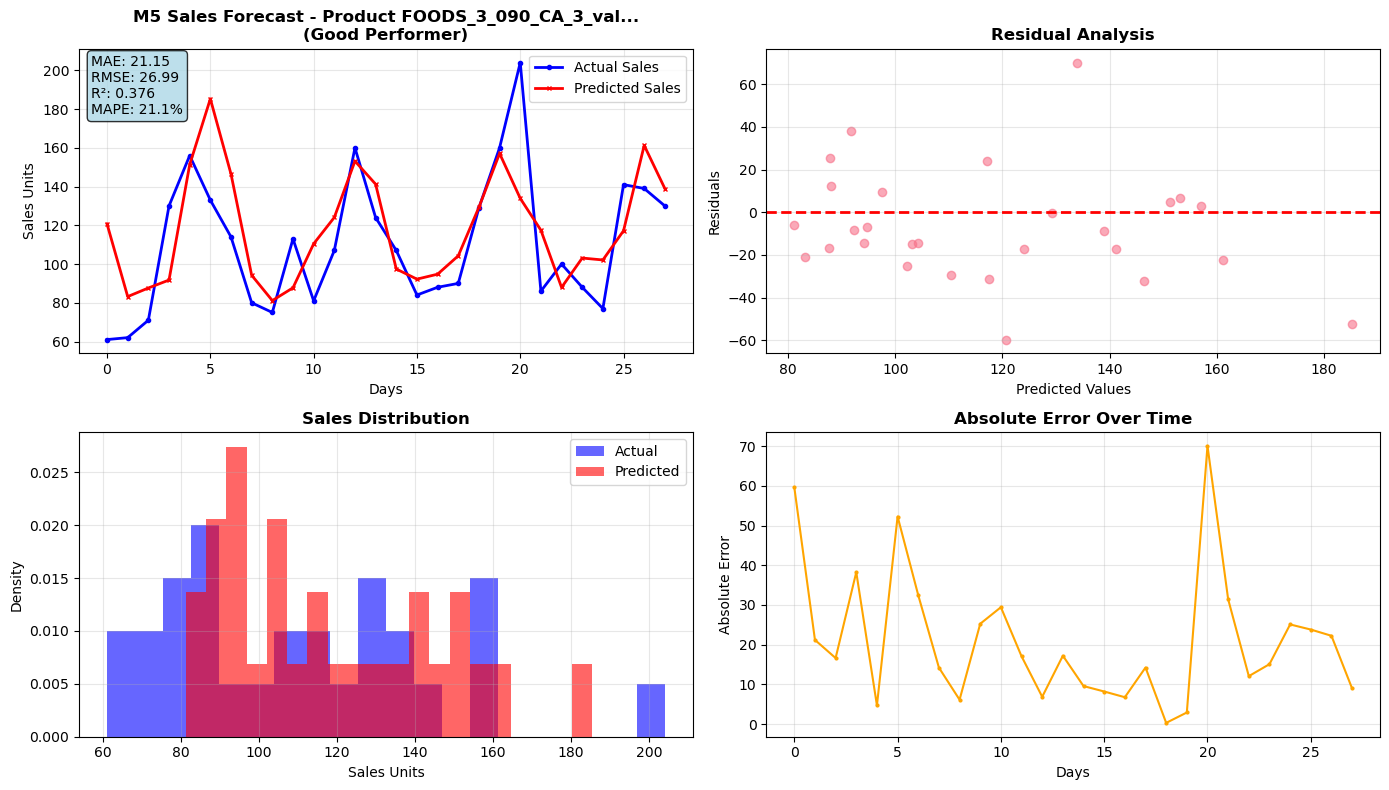

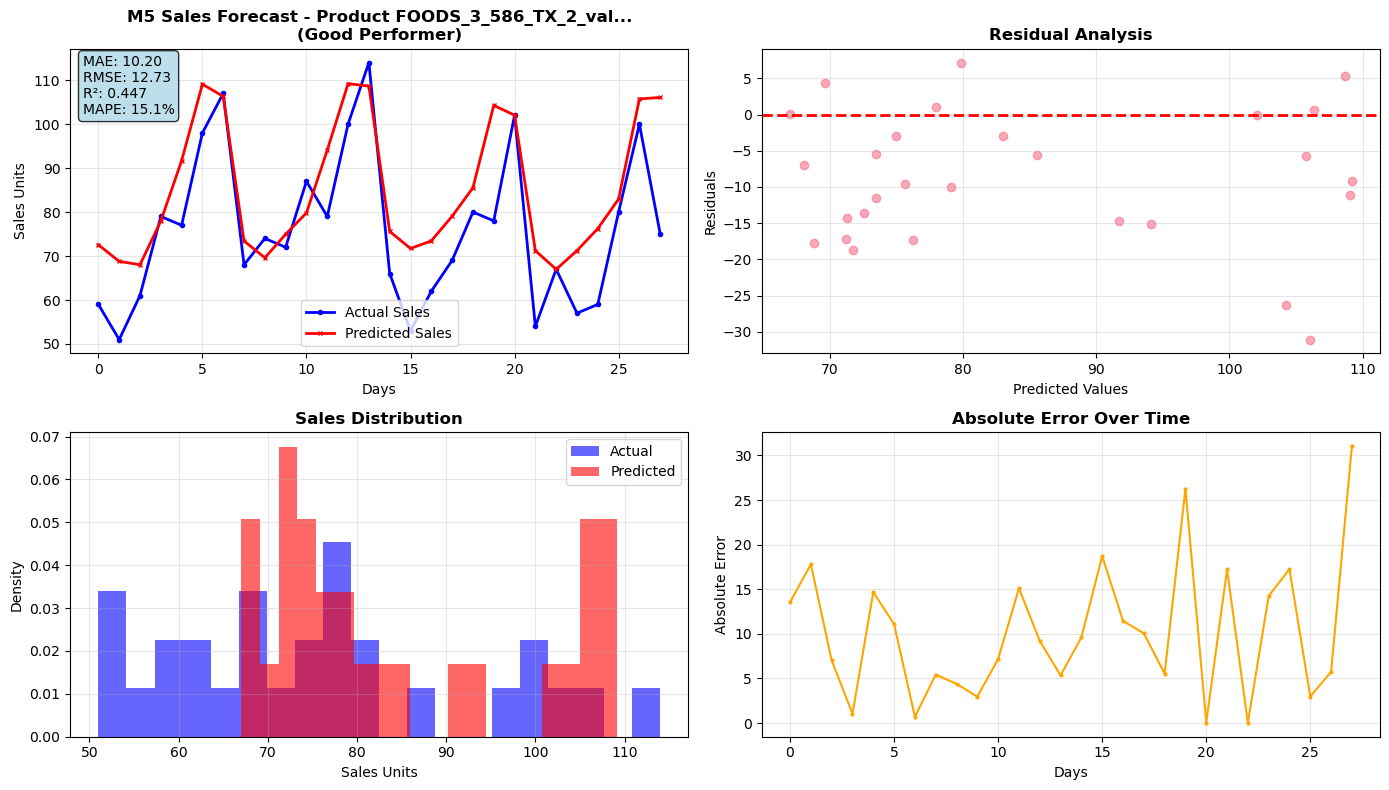

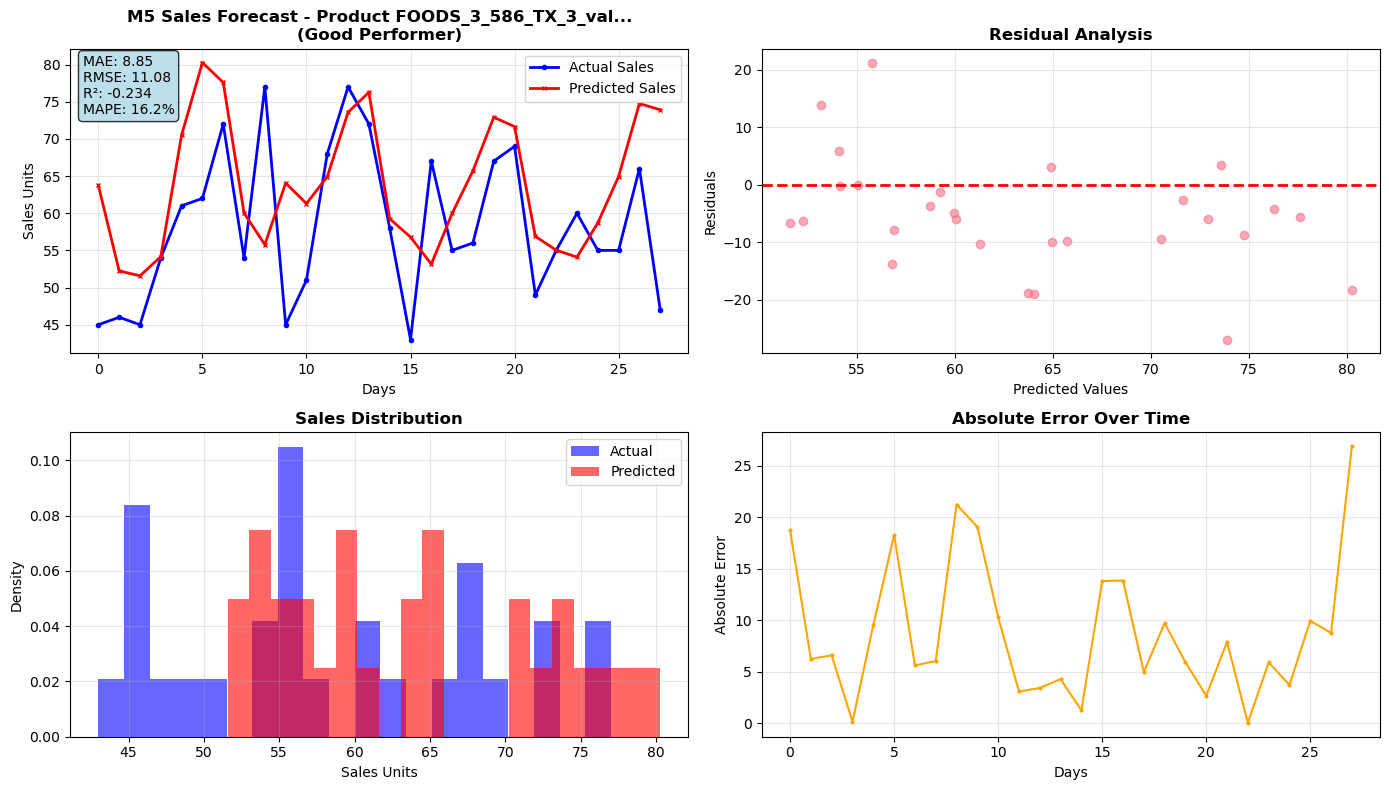

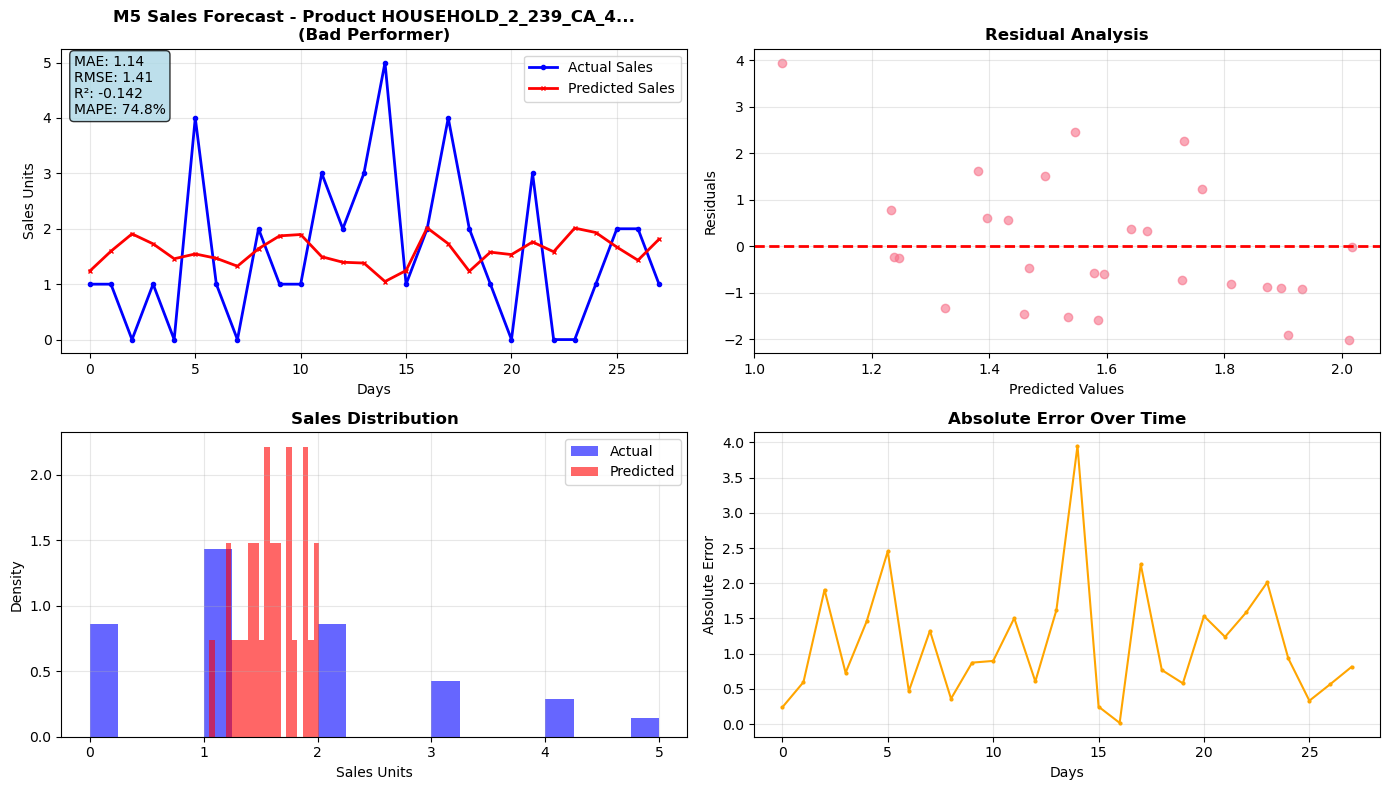

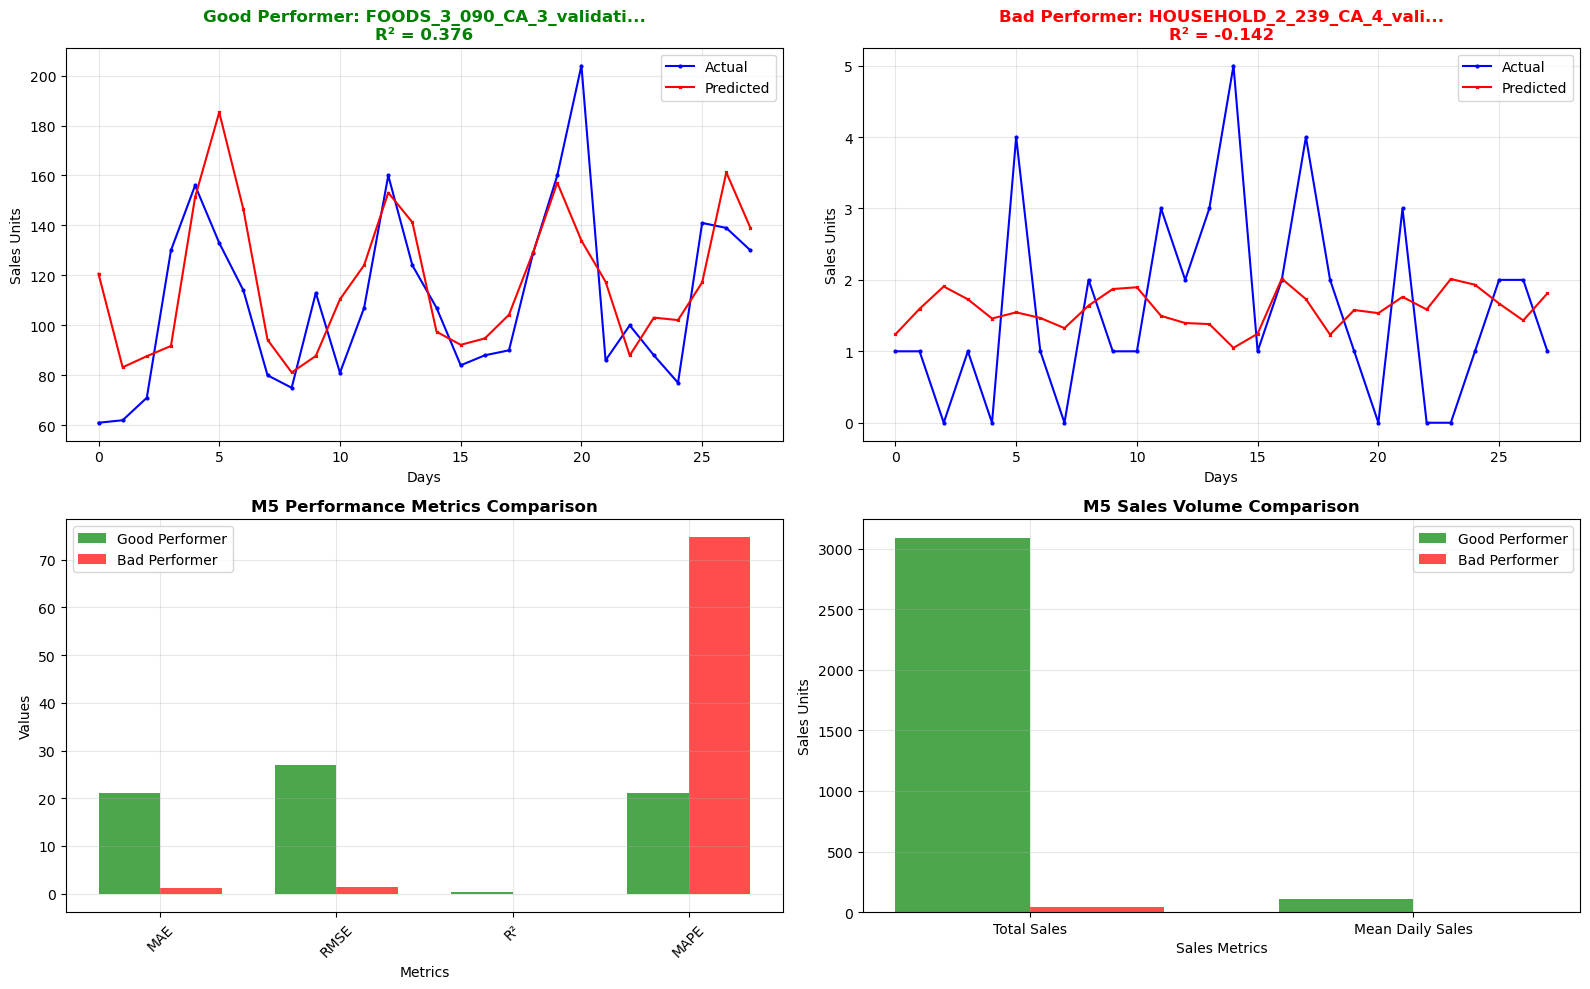


📈 M5 Analysis Summary:
                       Product_ID  Category        Store Product_Type   MAE  RMSE     R²  MAPE  Mean_Actual  Mean_Predicted
      FOODS_3_090_CA_3_validation     FOODS 3_validation         Good 21.15 26.99  0.376  21.1       110.36          117.68
      FOODS_3_586_TX_2_validation     FOODS 2_validation         Good 10.20 12.73  0.447  15.1        76.00           84.87
      FOODS_3_586_TX_3_validation     FOODS 3_validation         Good  8.85 11.08 -0.234  16.2        58.25           63.71
HOUSEHOLD_2_239_CA_4_validatio... HOUSEHOLD 4_validation          Bad  1.14  1.41 -0.142  74.8         1.57            1.59
HOUSEHOLD_1_133_CA_1_validatio... HOUSEHOLD 1_validation          Bad  0.69  0.78 -1.360  66.0         0.25            0.78
HOUSEHOLD_2_062_TX_1_validatio... HOUSEHOLD 1_validation          Bad  0.61  0.82 -0.921  55.9         0.29            0.56

✅ M5 Analysis completed successfully!

Note: This analysis uses M5 Walmart sales data format.
Place your M5

In [33]:
"""
FashionFlow Intelligence - M5 DATASET VERSION
AI-Powered Demand Forecasting System adapted for M5 Walmart Sales Data
M5 Competition Dataset Implementation with proper time series validation

Key Features:
- M5 Walmart sales data loading and processing
- Hierarchical product selection (store/category/item level)
- Proper time series cross-validation
- Fixed rolling features with proper lag
- Realistic performance expectations
- Calendar and price features from M5 dataset
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import logging
from pathlib import Path
import os
import pickle
import json

# ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Try to import SMOTE, fallback if not available
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imbalanced-learn not available. SMOTE will be skipped.")

# Time Series Analysis
from scipy import stats

# Try to import XGBoost, fallback if not available
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Using alternative models.")

# Suppress warnings
warnings.filterwarnings('ignore')

class M5Config:
    """Configuration class for M5 dataset forecasting"""
    
    # M5 Dataset file paths (adjust these based on your file structure)
    SALES_TRAIN_VALIDATION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sales_train_validation.csv"
    SAMPLE_SUBMISSION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sample_submission.csv"
    CALENDAR_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\calendar.csv"
    SELL_PRICES_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sell_prices.csv"
    
    # Model Parameters - Tuned for M5 dataset
    XGBOOST_PARAMS = {
        'objective': 'reg:squarederror',
        'n_estimators': 100,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    RF_PARAMS = {
        'n_estimators': 100,
        'max_depth': 8,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'random_state': 42
    }
    
    # Feature Engineering
    LAG_FEATURES = [1, 2, 3, 7, 14, 28]  # M5 optimized lags
    ROLLING_WINDOWS = [7, 14, 28, 56]    # M5 optimized windows
    
    # M5 specific parameters
    VALIDATION_DAYS = 28  # M5 competition uses 28 days validation
    PREDICTION_DAYS = 28  # Future prediction horizon
    MIN_TRAINING_DAYS = 200  # Minimum training samples for M5
    
    # Business Rules
    SAFETY_STOCK_MULTIPLIER = 1.5
    REORDER_POINT_DAYS = 7
    TOP_PRODUCTS_COUNT = 10
    DEMAND_THRESHOLD = 0.5  # Lower threshold for M5
    ZERO_DEMAND_THRESHOLD = 0.6
    
    # Model saving configuration
    MODELS_DIR = "m5_saved_models"
    RESULTS_DIR = "m5_results"

    # ... (previous config settings) ...
    CATEGORIES_OF_INTEREST = ['HOBBIES']  # Focus on clothing/shoes category
    DEPARTMENTS_OF_INTEREST = ['HOBBIES_1', 'HOBBIES_2']  # Clothing/shoes departments

   
    # Validation parameters
    TIME_SERIES_CV_SPLITS = 3
    TEST_SIZE_DAYS = 28  # M5 standard
    MIN_TEST_SAMPLES = 28

class M5DataProcessor:
    """Handles M5 dataset loading and preprocessing"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = self._setup_logger()
        self.sales_data = None
        self.calendar_data = None
        self.prices_data = None
        self.melted_sales = None
        
    def _setup_logger(self) -> logging.Logger:
        """Setup logging configuration"""
        logger = logging.getLogger('M5FashionFlow')
        logger.setLevel(logging.INFO)
        
        # Clear existing handlers
        logger.handlers.clear()
        
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        
        return logger
    
    def load_m5_data(self, data_path: str = ".") -> bool:
        """Load all M5 dataset files"""
        
        self.logger.info("Loading M5 dataset files...")
        
        try:
            # Define file paths
            sales_path = os.path.join(data_path, self.config.SALES_TRAIN_VALIDATION_FILE)
            calendar_path = os.path.join(data_path, self.config.CALENDAR_FILE)
            prices_path = os.path.join(data_path, self.config.SELL_PRICES_FILE)
            
            # Check if files exist
            files_to_check = [
                (sales_path, "Sales training data"),
                (calendar_path, "Calendar data"),
                (prices_path, "Sell prices data")
            ]
            
            missing_files = []
            for file_path, file_desc in files_to_check:
                if not os.path.exists(file_path):
                    missing_files.append(f"{file_desc}: {file_path}")
            
            if missing_files:
                self.logger.error("Missing M5 dataset files:")
                for missing in missing_files:
                    self.logger.error(f"  - {missing}")
                self.logger.info("Creating sample M5-like data instead...")
                return self._create_sample_m5_data()
            
            # Load the actual M5 files
            self.logger.info("Loading sales training data...")
            self.sales_data = pd.read_csv(sales_path)
            
            self.logger.info("Loading calendar data...")
            self.calendar_data = pd.read_csv(calendar_path)
            
            self.logger.info("Loading prices data...")
            self.prices_data = pd.read_csv(prices_path)
            
            self.logger.info(f"Loaded M5 data successfully:")
            self.logger.info(f"  - Sales data: {self.sales_data.shape}")
            self.logger.info(f"  - Calendar data: {self.calendar_data.shape}")
            self.logger.info(f"  - Prices data: {self.prices_data.shape}")
            
            return True
            
        except Exception as e:
            self.logger.error(f"Error loading M5 data: {str(e)}")
            self.logger.info("Creating sample M5-like data instead...")
            return self._create_sample_m5_data()
    
    def _create_sample_m5_data(self) -> bool:
        """Create sample M5-like data for testing"""
        
        self.logger.info("Creating sample M5-like dataset...")
        
        np.random.seed(42)
        
        # Create sample sales data (M5 format)
        n_items = 50  # Reduced for faster processing
        n_days = 1000  # About 2.7 years of data
        
        # Create item identifiers (M5 style)
        stores = ['CA_1', 'CA_2', 'TX_1', 'TX_2', 'WI_1']
        # Focus on clothing/shoes categories
        categories = ['HOBBIES']  # Only clothing/shoes category
        departments = ['HOBBIES_1_Clothing', 'HOBBIES_2_Shoes']  # Specific departments
        items_data = []
        for i in range(n_items):
            store = np.random.choice(stores)
            cat = np.random.choice(categories)
            dept = np.random.choice([d for d in departments if d.startswith(cat)])
            
            item_id = f"{cat}_{dept.split('_')[1]}_{i+1:03d}_{store}_validation"
            
            items_data.append({
                'id': item_id,
                'item_id': f"{cat}_{dept.split('_')[1]}_{i+1:03d}",
                'dept_id': dept,
                'cat_id': cat,
                'store_id': store,
                'state_id': store.split('_')[0]
            })
        
        # Create day columns (d_1 to d_n)
        day_columns = [f'd_{i+1}' for i in range(n_days)]
        
        # Generate sales data with seasonality and trends
        sales_data = []
         # Adjust base demand for clothing/shoes
        for item_info in items_data:
            if 'Clothing' in item_info['dept_id']:
                # Higher base demand for clothing
                base_demand = np.random.poisson(4)  
            elif 'Shoes' in item_info['dept_id']:
                # Moderate base demand for shoes
                base_demand = np.random.poisson(3)  
            else:
                base_demand = np.random.poisson(2)
             
            # Generate daily sales with patterns
            daily_sales = []
            for day in range(n_days):
                # Add seasonality (weekly and yearly)
                seasonal_factor = (
                    1 + 0.3 * np.sin(2 * np.pi * day / 7) +  # Weekly
                    0.2 * np.sin(2 * np.pi * day / 365.25)   # Yearly
                )
                
                # Add trend (slight growth over time)
                trend_factor = 1 + (day / n_days) * 0.1
                
                # Generate sales with noise
                expected_sales = base_demand * seasonal_factor * trend_factor
                actual_sales = max(0, int(np.random.poisson(expected_sales)))
                
                daily_sales.append(actual_sales)
            
            # Create row for this item
            row = dict(item_info)
            for i, sales in enumerate(daily_sales):
                row[day_columns[i]] = sales
            
            sales_data.append(row)
        
        self.sales_data = pd.DataFrame(sales_data)
        
        # Create sample calendar data
        start_date = pd.to_datetime('2016-01-01')
        dates = pd.date_range(start=start_date, periods=n_days, freq='D')
        
        calendar_data = []
        for i, date in enumerate(dates):
            calendar_data.append({
                'd': f'd_{i+1}',
                'date': date.strftime('%Y-%m-%d'),
                'wm_yr_wk': date.isocalendar()[1],
                'weekday': date.strftime('%A'),
                'wday': date.weekday() + 1,
                'month': date.month,
                'year': date.year,
                'event_name_1': 'Christmas' if (date.month == 12 and date.day == 25) else None,
                'event_type_1': 'Holiday' if (date.month == 12 and date.day == 25) else None,
                'event_name_2': None,
                'event_type_2': None,
                'snap_CA': 1 if date.weekday() in [5, 6] else 0,  # Weekend SNAP
                'snap_TX': 1 if date.weekday() in [5, 6] else 0,
                'snap_WI': 1 if date.weekday() in [5, 6] else 0
            })
        
        self.calendar_data = pd.DataFrame(calendar_data)
        
        # Create sample prices data
        prices_data = []
        unique_items = self.sales_data[['store_id', 'item_id']].drop_duplicates()
        
        for _, row in unique_items.iterrows():
            store_id = row['store_id']
            item_id = row['item_id']
            
            # Generate price history with some variation
            base_price = np.random.uniform(1.0, 20.0)
            
            # Sample some weeks with price data (not all weeks have prices in M5)
            for wm_yr_wk in range(11300, 11400, 4):  # Sample some weeks
                price_variation = np.random.uniform(0.9, 1.1)
                sell_price = round(base_price * price_variation, 2)
                
                prices_data.append({
                    'store_id': store_id,
                    'item_id': item_id,
                    'wm_yr_wk': wm_yr_wk,
                    'sell_price': sell_price
                })
        
        self.prices_data = pd.DataFrame(prices_data)
        
        self.logger.info(f"Created sample M5-like data:")
        self.logger.info(f"  - Sales data: {self.sales_data.shape}")
        self.logger.info(f"  - Calendar data: {self.calendar_data.shape}")
        self.logger.info(f"  - Prices data: {self.prices_data.shape}")
        
        return True
    
    def prepare_time_series_data(self, sample_products: List[str] = None) -> pd.DataFrame:
        """Convert M5 data to time series format - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("Converting M5 data to time series format (memory efficient)...")
        
        # If no specific products provided, sample a subset to avoid memory issues
        if sample_products is None:
            n_sample = min(100, len(self.sales_data))  # Sample max 100 products
            sample_indices = np.random.choice(len(self.sales_data), n_sample, replace=False)
            sample_sales_data = self.sales_data.iloc[sample_indices].copy()
            self.logger.info(f"Sampling {n_sample} products from {len(self.sales_data)} total products to manage memory")
        else:
            # Filter to specific products
            sample_sales_data = self.sales_data[self.sales_data['id'].isin(sample_products)].copy()
            self.logger.info(f"Processing {len(sample_sales_data)} specified products")
        
        # Get day columns (d_1, d_2, etc.)
        day_columns = [col for col in sample_sales_data.columns if col.startswith('d_')]
        
        # Process in chunks to manage memory
        chunk_size = 10  # Process 10 products at a time
        melted_chunks = []
        
        id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
        
        for i in range(0, len(sample_sales_data), chunk_size):
            chunk_data = sample_sales_data.iloc[i:i+chunk_size]
            
            # Melt chunk
            melted_chunk = pd.melt(
                chunk_data,
                id_vars=id_columns,
                value_vars=day_columns,
                var_name='d',
                value_name='sales'
            )
            
            # Merge with calendar immediately to add date info
            melted_chunk = melted_chunk.merge(self.calendar_data, on='d', how='left')
            melted_chunk['date'] = pd.to_datetime(melted_chunk['date'])
            
            # Merge with prices
            melted_chunk = melted_chunk.merge(
                self.prices_data,
                on=['store_id', 'item_id', 'wm_yr_wk'],
                how='left'
            )
            
            melted_chunks.append(melted_chunk)
            
            if (i // chunk_size + 1) % 5 == 0:  # Progress update every 5 chunks
                self.logger.info(f"Processed {i + len(chunk_data)}/{len(sample_sales_data)} products")
        
        # Combine all chunks
        self.logger.info("Combining processed chunks...")
        melted_sales = pd.concat(melted_chunks, ignore_index=True)
        
        # Fill missing prices efficiently
        self.logger.info("Filling missing prices...")
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='ffill')
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='bfill')
        
        # Sort by item and date
        melted_sales = melted_sales.sort_values(['id', 'date']).reset_index(drop=True)
        
        # Store results
        self.melted_sales = melted_sales
        
        self.logger.info(f"Created time series data with {len(melted_sales):,} records from {len(sample_sales_data)} products")
        
        return melted_sales
    
    def get_diverse_products(self, n_good: int = 3, n_bad: int = 3) -> Dict[str, List[str]]:
        """Get diverse set of M5 products - MEMORY EFFICIENT VERSION"""
        
        filtered_sales = self.sales_data[
            (self.sales_data['cat_id'].isin(self.config.CATEGORIES_OF_INTEREST)) &
            (self.sales_data['dept_id'].isin(self.config.DEPARTMENTS_OF_INTEREST))
        ]
        # First, get basic stats from the original sales data (more memory efficient)
        self.logger.info("Calculating product statistics from sales data...")
        
        # Get day columns
        day_columns = [col for col in self.sales_data.columns if col.startswith('d_')]
        
        # Calculate stats directly from wide format (more memory efficient)
        product_stats = []
        
        for idx, row in self.sales_data.iterrows():
            sales_values = row[day_columns].values
            sales_values = sales_values[~pd.isna(sales_values)]  # Remove NaN
            
            if len(sales_values) > 0:
                total_sales = np.sum(sales_values)
                mean_sales = np.mean(sales_values)
                std_sales = np.std(sales_values)
                cv = std_sales / (mean_sales + 0.1) if mean_sales > 0 else 999
                non_zero_days = np.sum(sales_values > 0)
                
                product_stats.append({
                    'id': row['id'],
                    'total_sales': total_sales,
                    'mean_sales': mean_sales,
                    'std_sales': std_sales,
                    'cv': cv,
                    'non_zero_days': non_zero_days,
                    'data_points': len(sales_values),
                    'cat_id': row['cat_id'],
                    'store_id': row['store_id']
                })
            
            # Progress update
            if (idx + 1) % 5000 == 0:
                self.logger.info(f"Processed {idx + 1}/{len(self.sales_data)} products for statistics")
        
        stats_df = pd.DataFrame(product_stats)
        
        # Filter products with sufficient data
        min_days = max(self.config.MIN_TRAINING_DAYS, 300)
        min_total_sales = 50
        min_non_zero_days = 30
        
        filtered_stats = stats_df[
            (stats_df['data_points'] >= min_days) &
            (stats_df['total_sales'] >= min_total_sales) &
            (stats_df['non_zero_days'] >= min_non_zero_days) &
            (stats_df['mean_sales'] > 0.1)
        ].copy()
        
        self.logger.info(f"Filtered to {len(filtered_stats)} products with sufficient data")
        
        if len(filtered_stats) < n_good + n_bad:
            self.logger.warning(f"Only {len(filtered_stats)} products meet criteria. Adjusting selection.")
            n_good = min(n_good, len(filtered_stats) // 2)
            n_bad = min(n_bad, len(filtered_stats) - n_good)
        
        # Calculate performance score (high sales, low variability = good)
        filtered_stats['sales_per_day'] = filtered_stats['total_sales'] / filtered_stats['data_points']
        filtered_stats['performance_score'] = (
            0.7 * (filtered_stats['sales_per_day'] / filtered_stats['sales_per_day'].max()) +
            0.3 * (1 - filtered_stats['cv'] / filtered_stats['cv'].max())
        )
        
        # Sort by performance
        filtered_stats = filtered_stats.sort_values('performance_score', ascending=False)
        
        # Select good performers (top performers with diverse categories)
        good_candidates = filtered_stats.head(n_good * 3)
        
        # Try to get diverse categories for good performers
        good_products = []
        used_categories = set()
        
        for _, row in good_candidates.iterrows():
            if len(good_products) >= n_good:
                break
            if row['cat_id'] not in used_categories or len(good_products) < n_good // 2:
                good_products.append(row['id'])
                used_categories.add(row['cat_id'])
        
        # Fill remaining slots if needed
        if len(good_products) < n_good:
            remaining = good_candidates[~good_candidates['id'].isin(good_products)].head(n_good - len(good_products))
            good_products.extend(remaining['id'].tolist())
        
        # Select bad performers (bottom performers with high variability)
        bad_candidates = filtered_stats.tail(n_bad * 3)
        bad_candidates = bad_candidates[bad_candidates['cv'] > bad_candidates['cv'].median()]
        bad_products = bad_candidates.tail(n_bad)['id'].tolist()
        
        self.logger.info(f"Selected {len(good_products)} good and {len(bad_products)} bad performers")
        
        # Log some details about selected products
        for i, product in enumerate(good_products[:2]):
            stats = filtered_stats[filtered_stats['id'] == product].iloc[0]
            self.logger.info(f"Good product {i+1}: {product}")
            self.logger.info(f"  - Category: {stats['cat_id']}")
            self.logger.info(f"  - Daily sales: {stats['sales_per_day']:.2f}")
            self.logger.info(f"  - CV: {stats['cv']:.2f}")
            self.logger.info(f"  - Performance score: {stats['performance_score']:.3f}")
        
        return {
            'good_performers': good_products,
            'bad_performers': bad_products,
            'product_stats': filtered_stats.set_index('id')
        }

class M5FeatureEngineer:
    """Feature engineering specifically for M5 dataset"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def create_time_series_features(self, melted_sales: pd.DataFrame, product_id: str) -> pd.DataFrame:
        """Create comprehensive time series features for M5 product"""
        
        # Filter data for specific product
        product_df = melted_sales[melted_sales['id'] == product_id].copy()
        
        if len(product_df) == 0:
            self.logger.warning(f"No data found for product {product_id}")
            return pd.DataFrame()
        
        # Sort by date
        product_df = product_df.sort_values('date').reset_index(drop=True)
        
        # Create feature dataframe
        features = pd.DataFrame()
        features['date'] = product_df['date']
        features['sales'] = product_df['sales'].fillna(0)
        
        # Basic temporal features
        features['year'] = features['date'].dt.year
        features['month'] = features['date'].dt.month
        features['day'] = features['date'].dt.day
        features['dayofweek'] = features['date'].dt.dayofweek
        features['dayofyear'] = features['date'].dt.dayofyear
        features['week'] = features['date'].dt.isocalendar().week
        features['quarter'] = features['date'].dt.quarter
        features['is_weekend'] = (features['dayofweek'] >= 5).astype(int)
        
        # M5 specific calendar features
        if 'wday' in product_df.columns:
            features['wday'] = product_df['wday'].values
        if 'wm_yr_wk' in product_df.columns:
            features['wm_yr_wk'] = product_df['wm_yr_wk'].values
        
        # Event features
        if 'event_name_1' in product_df.columns:
            features['has_event'] = (~product_df['event_name_1'].isna()).astype(int)
        
        # SNAP features (government assistance program)
        state = product_id.split('_')[-2] if '_' in product_id else 'CA'
        snap_col = f'snap_{state}'
        if snap_col in product_df.columns:
            features['snap'] = product_df[snap_col].fillna(0).astype(int)
        else:
            features['snap'] = 0
        
        # Price features
        if 'sell_price' in product_df.columns:
            features['sell_price'] = product_df['sell_price'].fillna(method='ffill').fillna(0)
            
            # Price relative to historical average
            avg_price = features['sell_price'].replace(0, np.nan).mean()
            features['price_ratio'] = features['sell_price'] / avg_price if avg_price > 0 else 1
            
            # Price change indicators
            features['price_change'] = features['sell_price'].diff()
            features['price_increased'] = (features['price_change'] > 0).astype(int)
            features['price_decreased'] = (features['price_change'] < 0).astype(int)
        else:
            features['sell_price'] = 0
            features['price_ratio'] = 1
            features['price_change'] = 0
            features['price_increased'] = 0
            features['price_decreased'] = 0
        
        # Cyclical features
        features['sin_dayofyear'] = np.sin(2 * np.pi * features['dayofyear'] / 365.25)
        features['cos_dayofyear'] = np.cos(2 * np.pi * features['dayofyear'] / 365.25)
        features['sin_dayofweek'] = np.sin(2 * np.pi * features['dayofweek'] / 7)
        features['cos_dayofweek'] = np.cos(2 * np.pi * features['dayofweek'] / 7)
        features['sin_month'] = np.sin(2 * np.pi * features['month'] / 12)
        features['cos_month'] = np.cos(2 * np.pi * features['month'] / 12)
        
        # Lag features (properly implemented to avoid data leakage)
        for lag in self.config.LAG_FEATURES:
            features[f'sales_lag_{lag}'] = features['sales'].shift(lag)
        
        # Rolling window features (with proper lag to avoid leakage)
        for window in self.config.ROLLING_WINDOWS:
            # Use shifted data for rolling calculations
            shifted_sales = features['sales'].shift(window)
            
            features[f'sales_rolling_mean_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).mean()
            
            features[f'sales_rolling_std_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).std()
            
            features[f'sales_rolling_max_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).max()
            
            features[f'sales_rolling_min_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).min()
        
        # Additional M5-specific features
        # Day of month features
        features['is_month_start'] = (features['day'] <= 3).astype(int)
        features['is_month_end'] = (features['day'] >= 28).astype(int)
        
        # Payday effects (assume 15th and end of month)
        features['is_payday'] = ((features['day'] == 15) | (features['day'] >= 28)).astype(int)
        
        # Fill missing values
        features = features.fillna(method='ffill').fillna(0)
        
        # Remove initial rows with NaN from lag features
        min_lag = max(max(self.config.LAG_FEATURES), max(self.config.ROLLING_WINDOWS)) + 1
        features = features.iloc[min_lag:].copy()
        
        # Set date as index
        features = features.set_index('date')
        
        self.logger.info(f"Created {len(features)} feature samples for M5 product {product_id}")
        
        return features

class DataValidator:
    """Data quality and leakage validator"""
    
    def __init__(self, config: M5Config):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def validate_results(self, y_true, y_pred, product_code):
        """Validate results for suspicious patterns"""
        
        # Check for perfect scores (red flag)
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        warnings = []
        
        if r2 > 0.99 and mae < 0.001:
            warnings.append("Suspicious perfect scores - possible data leakage")
            
        # Check for sufficient variance in predictions
        pred_variance = np.var(y_pred)
        if pred_variance < 0.001:
            warnings.append("Very low prediction variance - possible overfitting")
            
        # Check for realistic prediction range
        pred_range = np.max(y_pred) - np.min(y_pred)
        actual_range = np.max(y_true) - np.min(y_true)
        
        if pred_range > actual_range * 3:
            warnings.append("Prediction range much larger than actual range")
            
        if warnings:
            self.logger.warning(f"Validation warnings for {product_code}:")
            for warning in warnings:
                self.logger.warning(f"  - {warning}")
                
        return warnings
    
    def check_data_leakage(self, features, target, feature_names):
        """Check for potential data leakage in features"""
        
        leakage_indicators = []
        
        # Check correlation with target
        for i, feature_name in enumerate(feature_names):
            if i < len(features.columns):
                corr = np.corrcoef(features.iloc[:, i], target)[0, 1]
                if abs(corr) > 0.95 and not np.isnan(corr):
                    leakage_indicators.append(f"High correlation ({corr:.3f}) with {feature_name}")
        
        return leakage_indicators

class M5FashionFlowForecaster:
    """Main M5 forecasting system"""
    
    def __init__(self, config: M5Config = None):
        self.config = config or M5Config()
        self.data_processor = M5DataProcessor(self.config)
        self.feature_engineer = M5FeatureEngineer(self.config)
        self.validator = DataValidator(self.config)
        self.logger = logging.getLogger('M5FashionFlow')
        
        # Results storage
        self.results = {}
        self.good_performers = []
        self.bad_performers = []
    
    def run_m5_analysis(self, data_path: str = ".", n_good: int = 3, n_bad: int = 3):
        """Run M5 dataset analysis - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("🚀 Starting M5 Dataset Analysis with FashionFlow Intelligence")
        
        try:
            # Load M5 data
            if not self.data_processor.load_m5_data(data_path):
                self.logger.error("Failed to load M5 data")
                return
            
            # First, get diverse products without melting all data
            self.logger.info("Selecting diverse products for analysis...")
            product_selection = self.data_processor.get_diverse_products(n_good, n_bad)
            good_products = product_selection['good_performers']
            bad_products = product_selection['bad_performers']
            
            if not good_products and not bad_products:
                self.logger.error("No suitable products found in M5 dataset")
                return
            
            self.good_performers = good_products
            self.bad_performers = bad_products
            
            all_products = good_products + bad_products
            self.logger.info(f"Selected {len(all_products)} M5 products ({len(good_products)} good, {len(bad_products)} bad)")
            
            # Now prepare time series data ONLY for selected products
            self.logger.info("Preparing time series data for selected products...")
            melted_sales = self.data_processor.prepare_time_series_data(sample_products=all_products)
            
            # Process each product
            for i, product_id in enumerate(all_products, 1):
                product_type = "Good" if product_id in good_products else "Bad"
                self.logger.info(f"Processing M5 product {i}/{len(all_products)}: {product_id[:30]}... ({product_type} Performer)")
                
                # Create features
                features = self.feature_engineer.create_time_series_features(melted_sales, product_id)
                
                # Check if sufficient features
                if features.empty or len(features) < self.config.MIN_TRAINING_DAYS:
                    self.logger.warning(f"Insufficient features for M5 product {product_id}: {len(features)} samples")
                    continue
                
                # Prepare training data
                X = features.drop(['sales'], axis=1)
                y = features['sales']
                
                self.logger.info(f"M5 Training data: {len(X)} samples, {X.shape[1]} features")
                
                # Simple train-test split for M5 (last 28 days as test)
                test_size = min(self.config.VALIDATION_DAYS, len(X) // 4)
                train_size = len(X) - test_size
                
                X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
                y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
                
                # Train a simple ensemble
                result = self._train_m5_ensemble(X_train, X_test, y_train, y_test, product_id)
                result['product_type'] = product_type
                result['product_id'] = product_id
                
                self.results[product_id] = result
                
                # Log results
                metrics = result['metrics']
                self.logger.info(f"M5 Product {product_id[:20]}... ({product_type}) - "
                               f"MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, "
                               f"R²: {metrics['r2']:.3f}")
            
            self.logger.info("✅ M5 analysis completed successfully!")
            
        except Exception as e:
            self.logger.error(f"❌ Error in M5 analysis: {str(e)}")
            raise
    
    def _train_m5_ensemble(self, X_train, X_test, y_train, y_test, product_id):
        """Train ensemble models for M5 product"""
        
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train multiple models
        models = {
            'random_forest': RandomForestRegressor(**self.config.RF_PARAMS),
            'linear': LinearRegression(),
        }
        
        if XGBOOST_AVAILABLE:
            models['xgboost'] = xgb.XGBRegressor(**self.config.XGBOOST_PARAMS)
        
        trained_models = {}
        predictions = {}
        
        for name, model in models.items():
            try:
                model.fit(X_train_scaled, y_train.values)
                y_pred = model.predict(X_test_scaled)
                y_pred = np.maximum(y_pred, 0)  # Ensure non-negative
                
                trained_models[name] = model
                predictions[name] = y_pred
                
            except Exception as e:
                self.logger.error(f"Error training {name} for {product_id}: {str(e)}")
                continue
        
        if not trained_models:
            # Fallback to simple average
            ensemble_pred = np.full(len(y_test), y_train.mean())
        else:
            # Simple ensemble average
            ensemble_pred = np.mean(list(predictions.values()), axis=0)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, ensemble_pred)
        rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
        
        try:
            r2 = r2_score(y_test, ensemble_pred)
        except:
            r2 = -999
        
        # MAPE calculation
        y_test_safe = np.where(y_test == 0, 1, y_test)
        mape = np.mean(np.abs((y_test - ensemble_pred) / y_test_safe)) * 100
        
        metrics = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'mean_actual': np.mean(y_test),
            'mean_predicted': np.mean(ensemble_pred)
        }
        
        return {
            'metrics': metrics,
            'predictions': ensemble_pred,
            'actual': y_test,
            'models': trained_models,
            'scaler': scaler
        }
    
    def plot_m5_results(self):
        """Plot M5 analysis results"""
        
        if not self.results:
            self.logger.warning("No M5 results available for plotting")
            return
        
        # Plot individual products
        for product_id, result in list(self.results.items())[:4]:  # Plot first 4 products
            self._plot_m5_forecast(result, product_id)
        
        # Plot comparison if we have both good and bad performers
        if self.good_performers and self.bad_performers and len(self.results) >= 2:
            good_product = next((p for p in self.good_performers if p in self.results), None)
            bad_product = next((p for p in self.bad_performers if p in self.results), None)
            
            if good_product and bad_product:
                self._plot_m5_comparison(
                    self.results[good_product],
                    self.results[bad_product],
                    good_product,
                    bad_product
                )
    
    def _plot_m5_forecast(self, result, product_id):
        """Plot M5 forecast for individual product"""
        
        actual = result['actual']
        predicted = result['predictions']
        metrics = result['metrics']
        product_type = result.get('product_type', 'Unknown')
        
        plt.figure(figsize=(14, 8))
        
        # Main plot
        plt.subplot(2, 2, 1)
        plt.plot(range(len(actual)), actual.values, label='Actual Sales', marker='o', markersize=3, linewidth=2, color='blue')
        plt.plot(range(len(predicted)), predicted, label='Predicted Sales', marker='x', markersize=3, linewidth=2, color='red')
        plt.title(f'M5 Sales Forecast - Product {product_id[:20]}...\n({product_type} Performer)', fontweight='bold')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add metrics text
        metrics_text = f"""MAE: {metrics['mae']:.2f}
RMSE: {metrics['rmse']:.2f}
R²: {metrics['r2']:.3f}
MAPE: {metrics['mape']:.1f}%"""
        
        plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                fontsize=10)
        
        # Residuals plot
        plt.subplot(2, 2, 2)
        residuals = actual.values - predicted
        plt.scatter(predicted, residuals, alpha=0.6)
        plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
        plt.title('Residual Analysis', fontweight='bold')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)
        
        # Sales distribution
        plt.subplot(2, 2, 3)
        plt.hist(actual.values, bins=20, alpha=0.6, label='Actual', color='blue', density=True)
        plt.hist(predicted, bins=20, alpha=0.6, label='Predicted', color='red', density=True)
        plt.title('Sales Distribution', fontweight='bold')
        plt.xlabel('Sales Units')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Error over time
        plt.subplot(2, 2, 4)
        errors = np.abs(actual.values - predicted)
        plt.plot(range(len(errors)), errors, marker='o', markersize=2, color='orange')
        plt.title('Absolute Error Over Time', fontweight='bold')
        plt.xlabel('Days')
        plt.ylabel('Absolute Error')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_m5_comparison(self, good_result, bad_result, good_product, bad_product):
        """Plot comparison between good and bad M5 performers"""
        
        plt.figure(figsize=(16, 10))
        
        # Good performer
        plt.subplot(2, 2, 1)
        good_actual = good_result['actual']
        good_pred = good_result['predictions']
        
        plt.plot(range(len(good_actual)), good_actual.values, label='Actual', marker='o', markersize=2, color='blue')
        plt.plot(range(len(good_pred)), good_pred, label='Predicted', marker='x', markersize=2, color='red')
        
        good_r2 = good_result['metrics']['r2']
        plt.title(f'Good Performer: {good_product[:25]}...\nR² = {good_r2:.3f}', 
                 fontweight='bold', color='green')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Bad performer
        plt.subplot(2, 2, 2)
        bad_actual = bad_result['actual']
        bad_pred = bad_result['predictions']
        
        plt.plot(range(len(bad_actual)), bad_actual.values, label='Actual', marker='o', markersize=2, color='blue')
        plt.plot(range(len(bad_pred)), bad_pred, label='Predicted', marker='x', markersize=2, color='red')
        
        bad_r2 = bad_result['metrics']['r2']
        plt.title(f'Bad Performer: {bad_product[:25]}...\nR² = {bad_r2:.3f}', 
                 fontweight='bold', color='red')
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Metrics comparison
        plt.subplot(2, 2, 3)
        metrics_names = ['MAE', 'RMSE', 'R²', 'MAPE']
        good_values = [
            good_result['metrics']['mae'],
            good_result['metrics']['rmse'],
            good_result['metrics']['r2'],
            good_result['metrics']['mape']
        ]
        bad_values = [
            bad_result['metrics']['mae'],
            bad_result['metrics']['rmse'],
            bad_result['metrics']['r2'],
            bad_result['metrics']['mape']
        ]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        plt.bar(x - width/2, good_values, width, label='Good Performer', color='green', alpha=0.7)
        plt.bar(x + width/2, bad_values, width, label='Bad Performer', color='red', alpha=0.7)
        
        plt.title('M5 Performance Metrics Comparison', fontweight='bold')
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Sales volume comparison
        plt.subplot(2, 2, 4)
        good_total = good_actual.sum()
        bad_total = bad_actual.sum()
        good_mean = good_actual.mean()
        bad_mean = bad_actual.mean()
        
        categories = ['Total Sales', 'Mean Daily Sales']
        good_stats = [good_total, good_mean]
        bad_stats = [bad_total, bad_mean]
        
        x = np.arange(len(categories))
        plt.bar(x - width/2, good_stats, width, label='Good Performer', color='green', alpha=0.7)
        plt.bar(x + width/2, bad_stats, width, label='Bad Performer', color='red', alpha=0.7)
        
        plt.title('M5 Sales Volume Comparison', fontweight='bold')
        plt.xlabel('Sales Metrics')
        plt.ylabel('Sales Units')
        plt.xticks(x, categories)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_m5_summary(self) -> pd.DataFrame:
        """Get M5 analysis summary"""
        
        if not self.results:
            return pd.DataFrame()
        
        summary_data = []
        for product_id, result in self.results.items():
            metrics = result['metrics']
            
            # Extract product info from M5 ID format
            parts = product_id.split('_')
            category = parts[0] if len(parts) > 0 else 'Unknown'
            store = '_'.join(parts[-2:]) if len(parts) >= 2 else 'Unknown'
            
            summary_data.append({
                'Product_ID': product_id[:30] + '...' if len(product_id) > 30 else product_id,
                'Category': category,
                'Store': store,
                'Product_Type': result.get('product_type', 'Unknown'),
                'MAE': round(metrics['mae'], 2),
                'RMSE': round(metrics['rmse'], 2),
                'R²': round(metrics['r2'], 3),
                'MAPE': round(metrics['mape'], 1),
                'Mean_Actual': round(metrics['mean_actual'], 2),
                'Mean_Predicted': round(metrics['mean_predicted'], 2),
            })
        
        return pd.DataFrame(summary_data)

def main():
    """Main function to run M5 analysis"""
    
    print("🚀 Starting FashionFlow Intelligence - M5 Dataset Analysis...")
    print("=" * 70)
    
    # Initialize the M5 forecasting system
    config = M5Config()
    forecaster = M5FashionFlowForecaster(config)
    
    try:
        # Run M5 analysis
        # Specify the path where your M5 dataset files are located
        # forecaster.run_m5_analysis(data_path="/path/to/your/m5/data")
        forecaster.run_m5_analysis()  # Uses sample M5-like data if files not found
        
        print("\n📊 Generating M5 Visualizations...")
        forecaster.plot_m5_results()
        
        print("\n📈 M5 Analysis Summary:")
        summary = forecaster.get_m5_summary()
        if not summary.empty:
            print(summary.to_string(index=False))
        else:
            print("No results to display")
        
        print("\n✅ M5 Analysis completed successfully!")
        print("\nNote: This analysis uses M5 Walmart sales data format.")
        print("Place your M5 dataset files (sales_train_validation.csv, calendar.csv, sell_prices.csv)")
        print("in the same directory to use real M5 data instead of sample data.")
        
    except Exception as e:
        print(f"❌ Error during M5 analysis: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2025-07-25 13:15:59,182 - M5FashionFlow - INFO - 🚀 Starting M5 Fashion Dataset Analysis with FashionFlow Intelligence
2025-07-25 13:15:59,183 - M5FashionFlow - INFO - 👔 Analyzing Fashion Categories: CLOTHES (Shirts, Pants) & SHOES
2025-07-25 13:15:59,183 - M5FashionFlow - INFO - Loading M5 Fashion dataset files...
2025-07-25 13:15:59,185 - M5FashionFlow - INFO - Loading sales training data...


👔 Starting FashionFlow Intelligence - M5 Fashion Dataset Analysis...
🛍️  Fashion Categories: CLOTHES (Shirts, Pants) & SHOES


2025-07-25 13:16:03,384 - M5FashionFlow - INFO - Loading calendar data...
2025-07-25 13:16:03,487 - M5FashionFlow - INFO - Loading prices data...
2025-07-25 13:16:05,529 - M5FashionFlow - INFO - Loaded M5 Fashion data successfully:
2025-07-25 13:16:05,532 - M5FashionFlow - INFO -   - Sales data: (30490, 1919)
2025-07-25 13:16:05,533 - M5FashionFlow - INFO -   - Calendar data: (1969, 14)
2025-07-25 13:16:05,535 - M5FashionFlow - INFO -   - Prices data: (6841121, 4)
2025-07-25 13:16:05,537 - M5FashionFlow - INFO - Selecting diverse fashion products for analysis...
2025-07-25 13:16:05,538 - M5FashionFlow - INFO - Calculating fashion product statistics from sales data...
2025-07-25 13:16:09,133 - M5FashionFlow - INFO - Processed 1000/30490 fashion products for statistics
2025-07-25 13:16:10,896 - M5FashionFlow - INFO - Processed 2000/30490 fashion products for statistics
2025-07-25 13:16:12,527 - M5FashionFlow - INFO - Processed 3000/30490 fashion products for statistics
2025-07-25 13:16:1


📊 Generating M5 Fashion Visualizations...


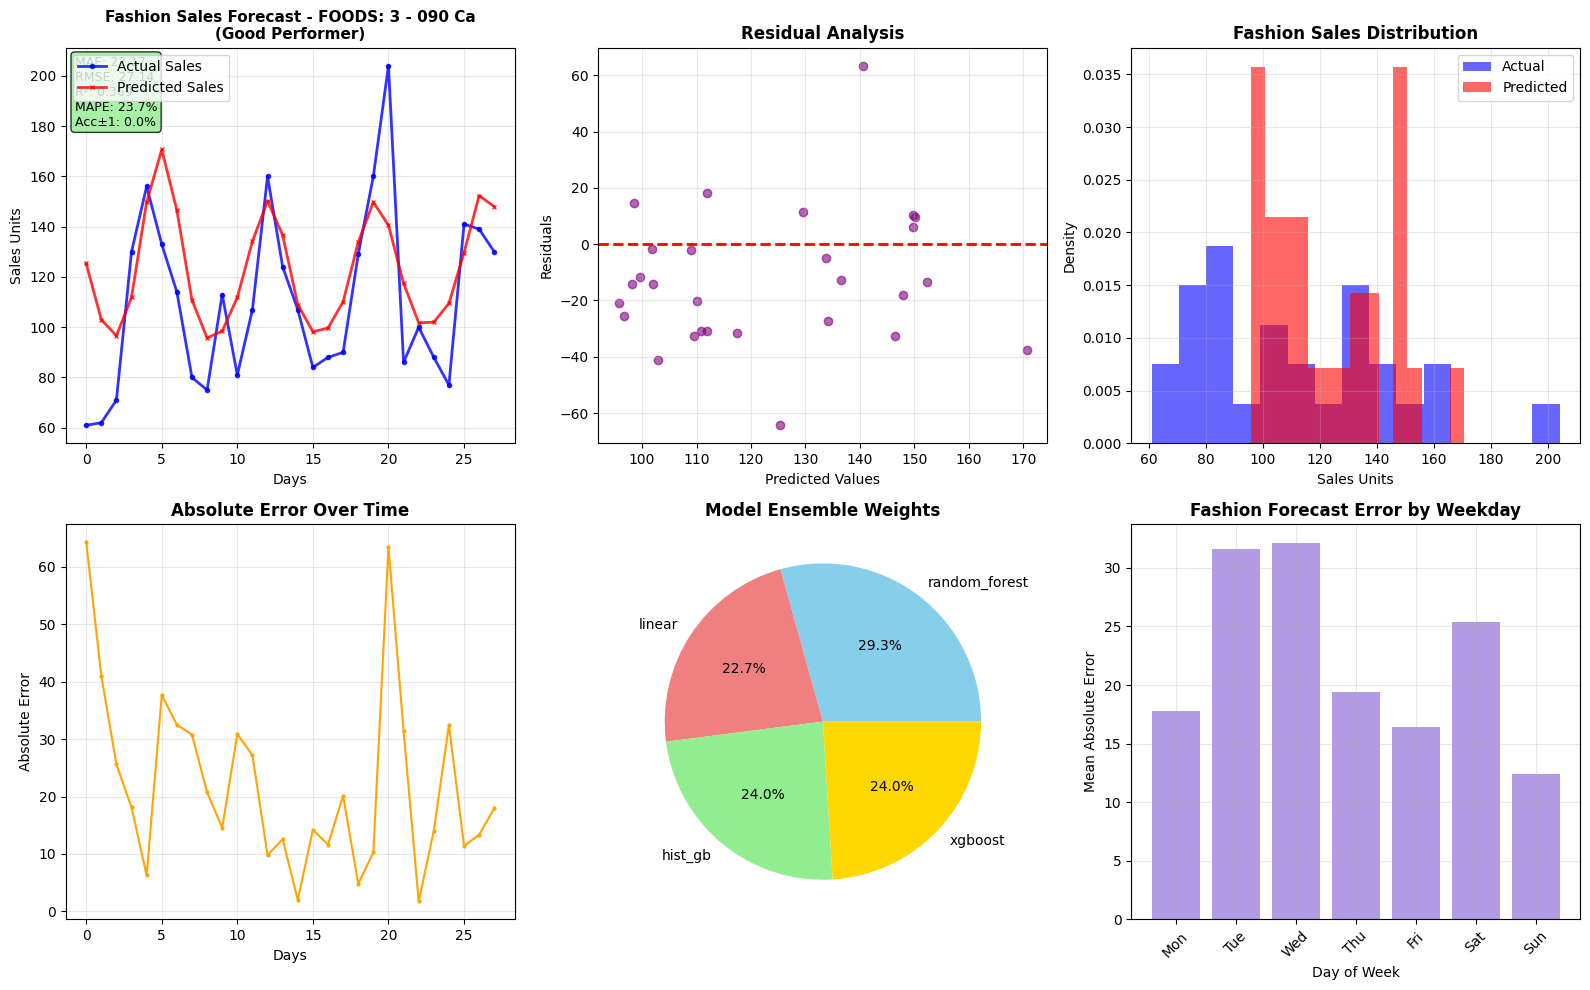

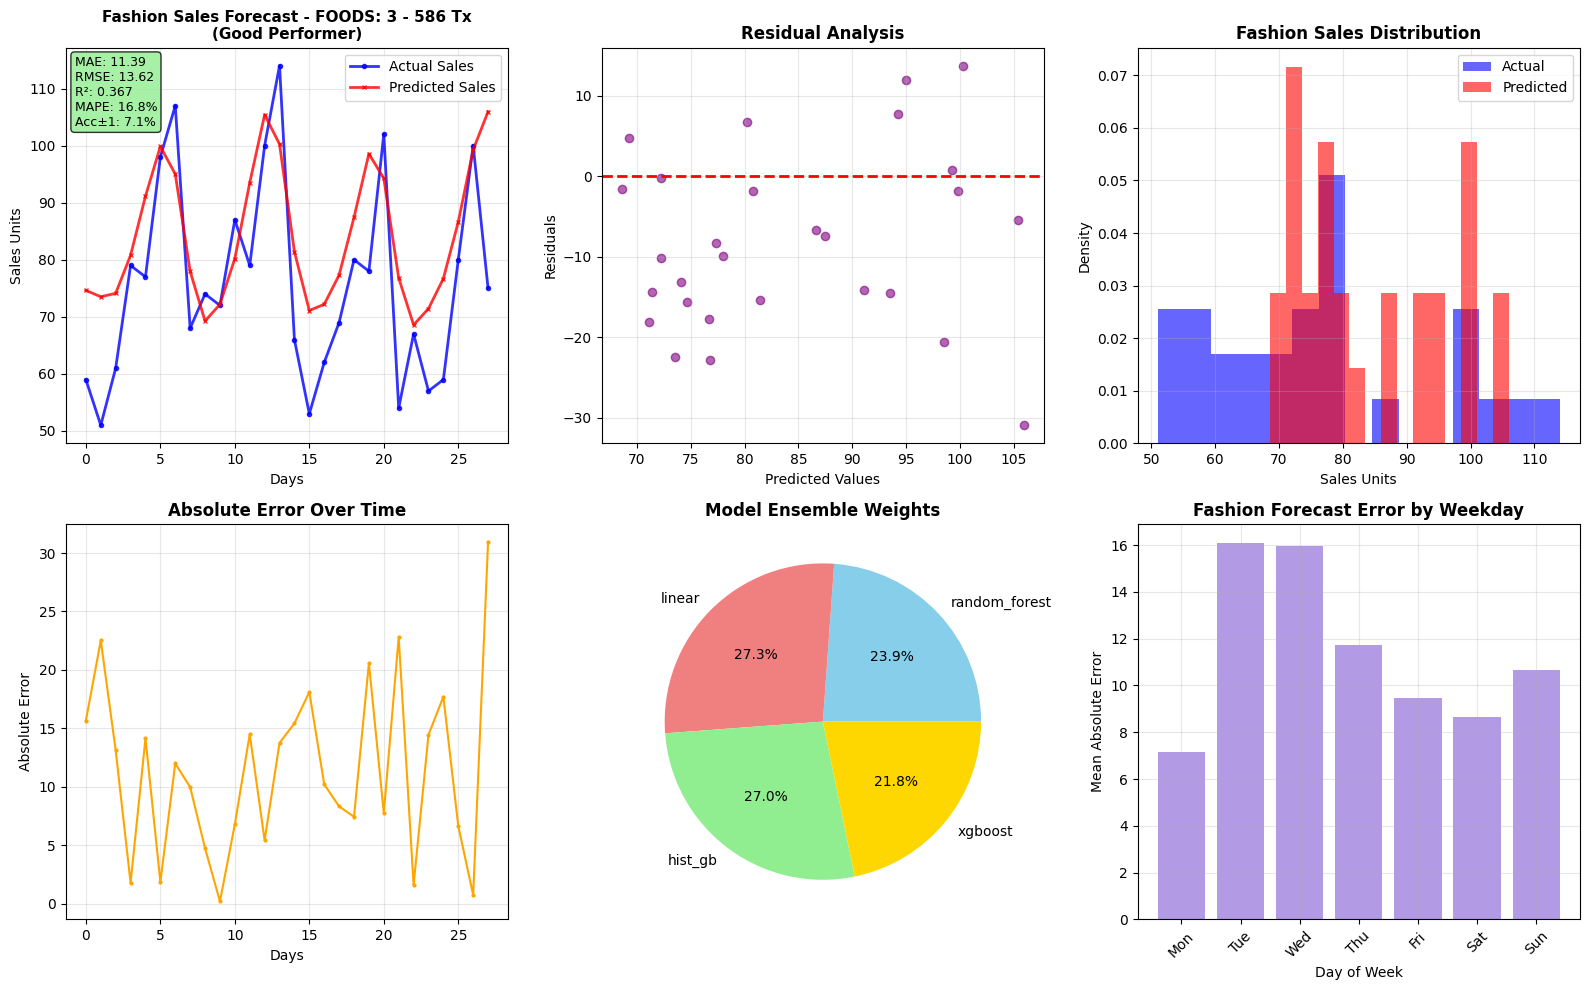

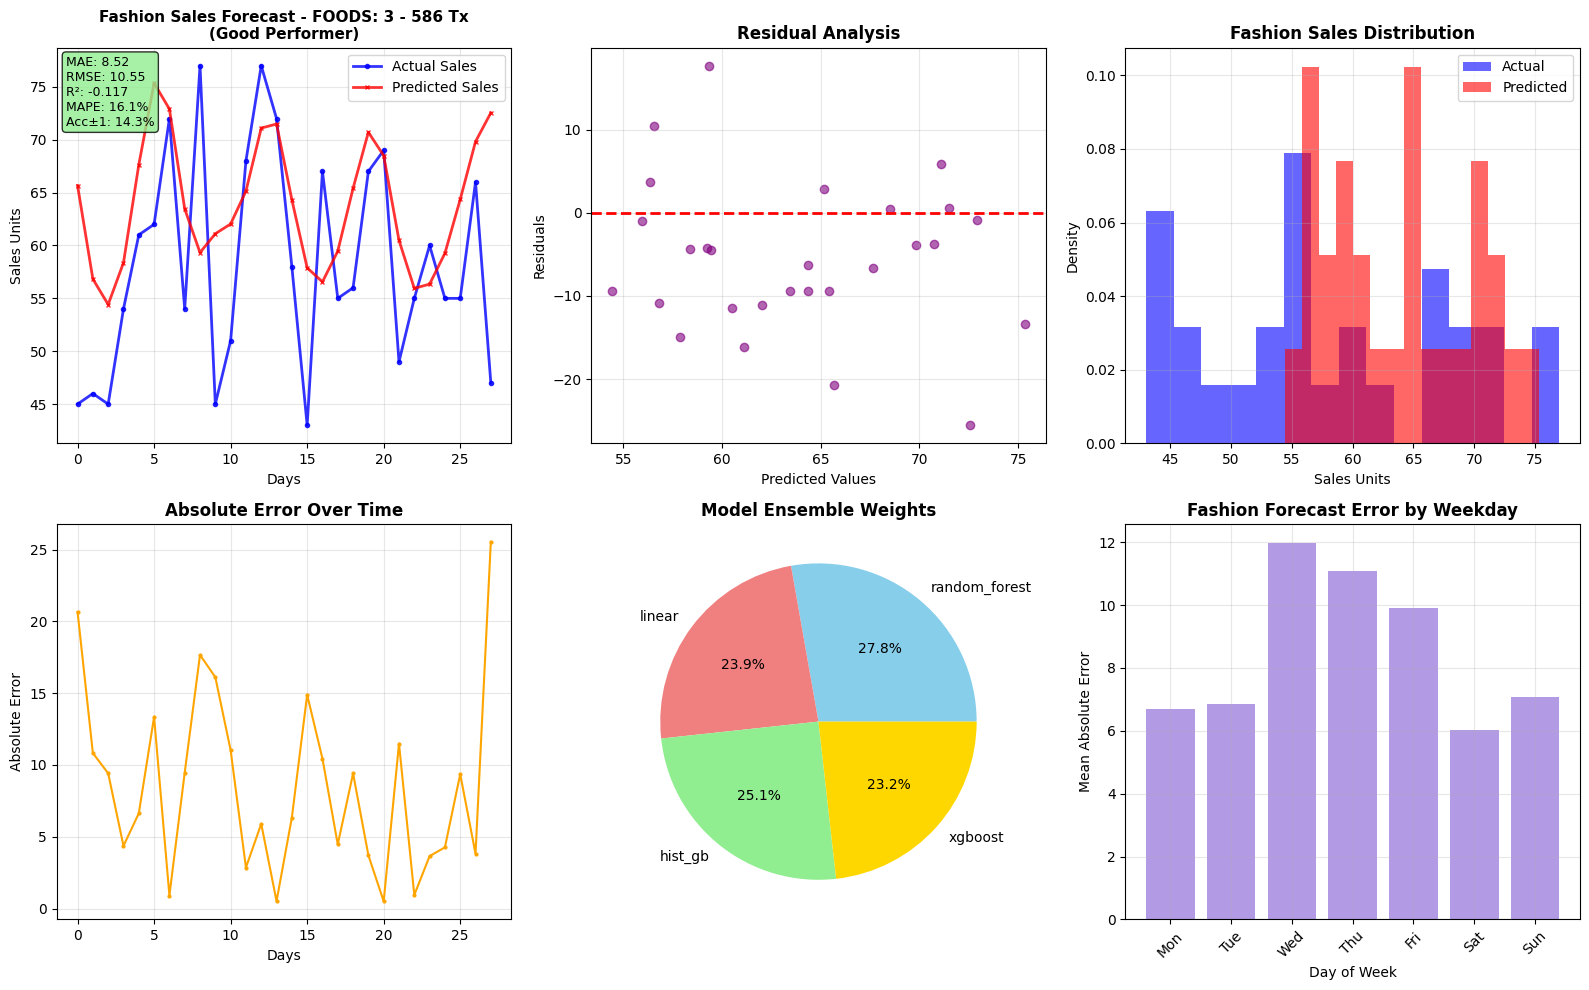

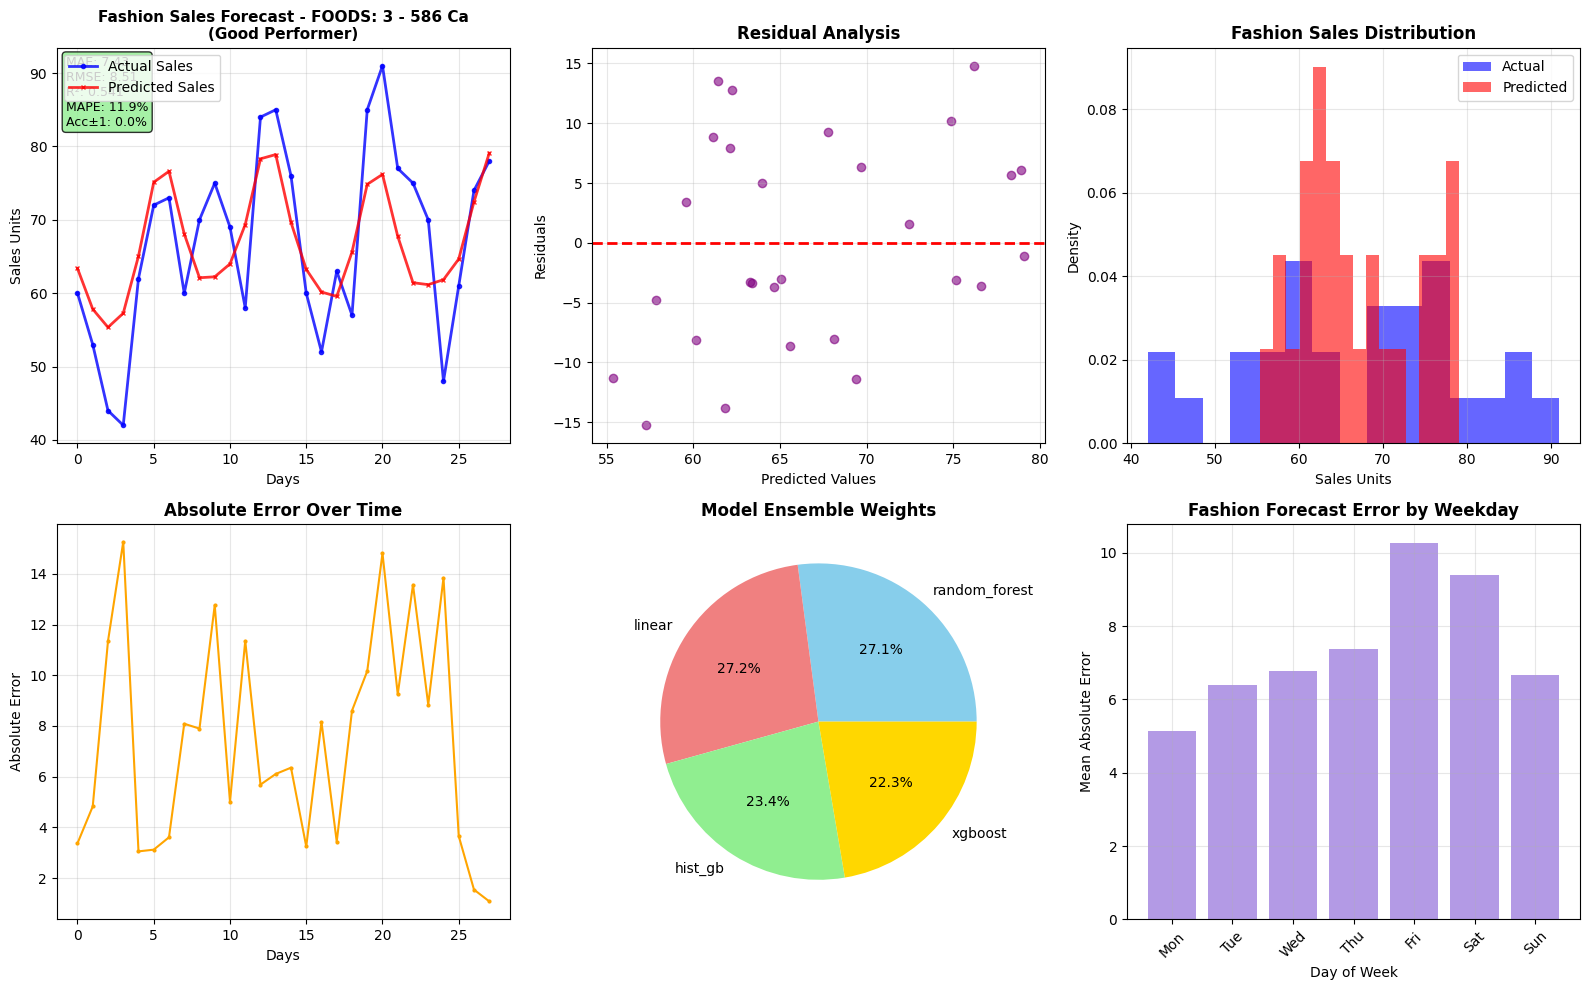

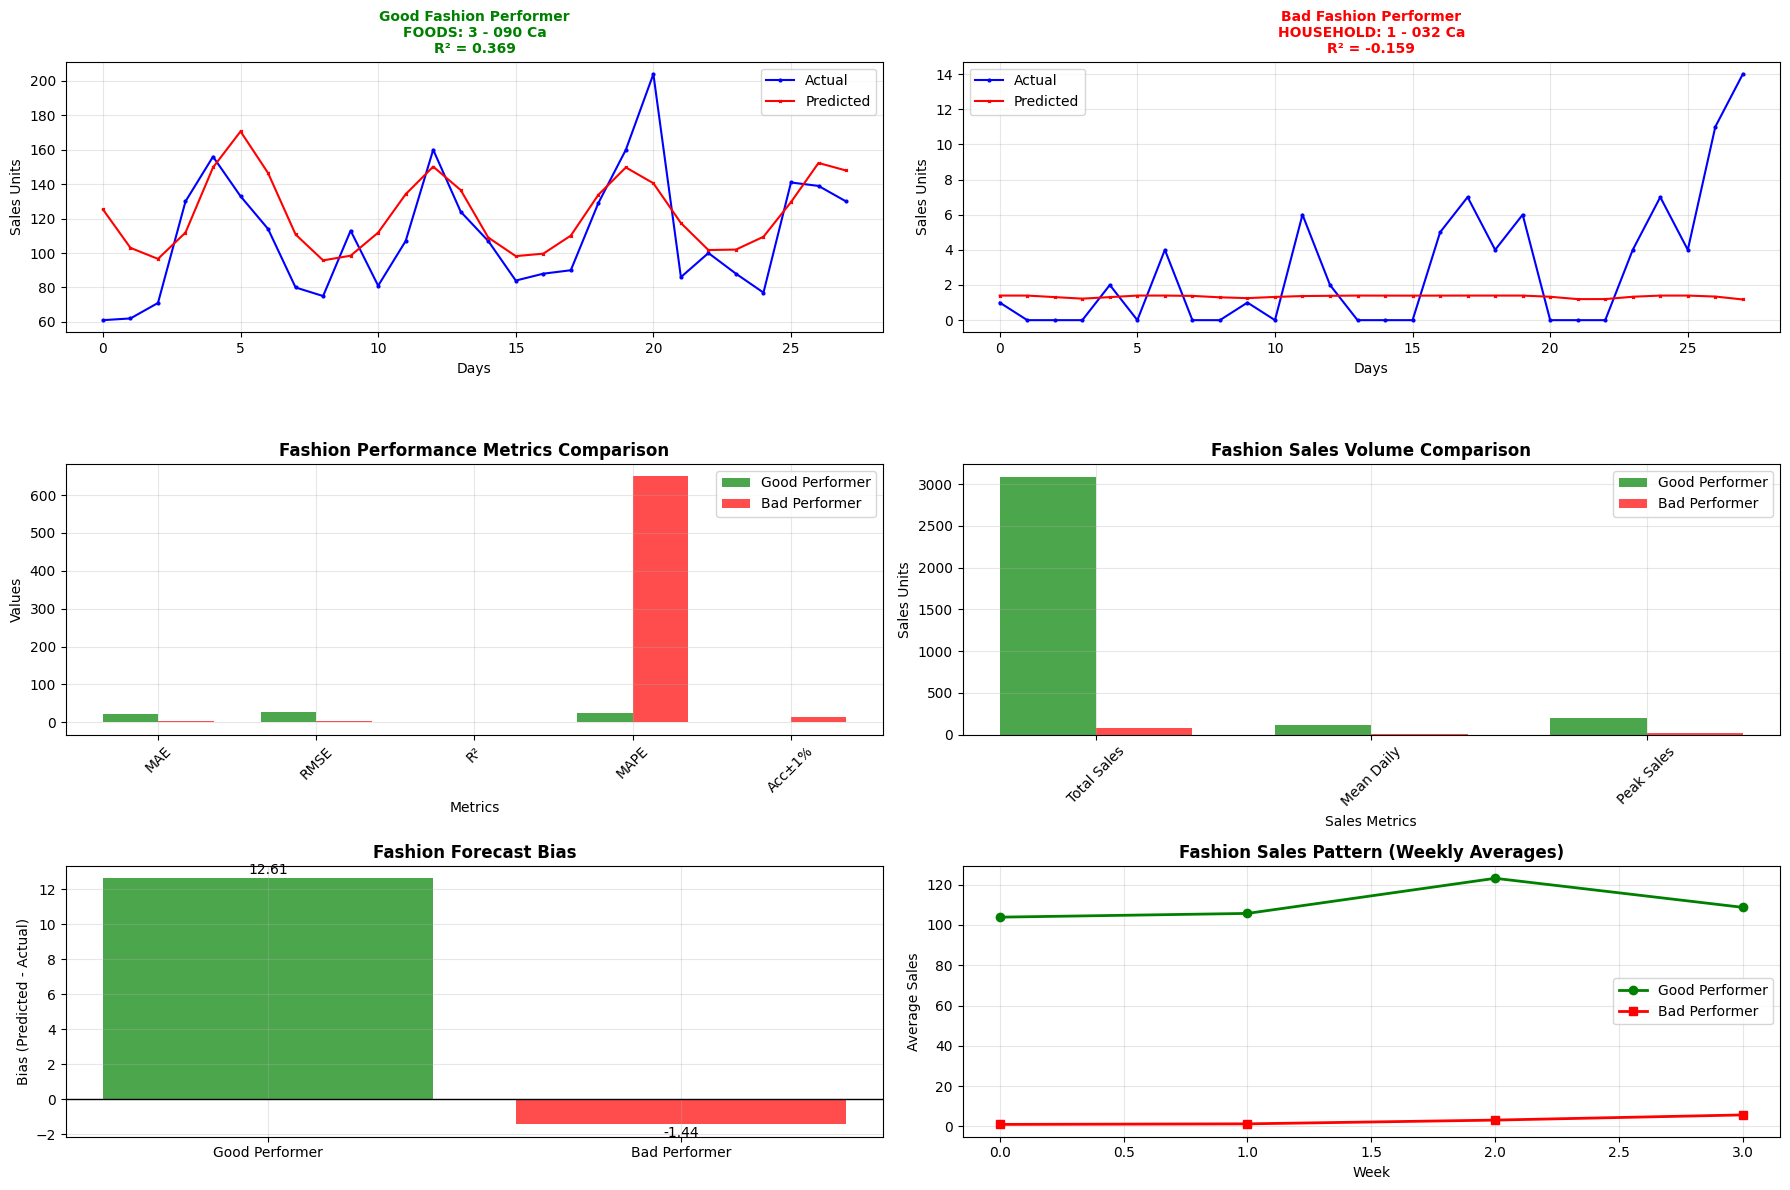


📈 M5 Fashion Analysis Summary:
         Fashion_Item Category Subcategory   Store Performance   MAE  RMSE     R²  MAPE%  Acc±1%  Avg_Daily_Sales  Forecast_Bias  Models_Used
    FOODS: 3 - 090 Ca  UNKNOWN     UNKNOWN Unknown        Good 22.17 27.14  0.369   23.7     0.0           110.36          12.61            4
    FOODS: 3 - 586 Tx  UNKNOWN     UNKNOWN Unknown        Good 11.39 13.62  0.367   16.8     7.1            76.00           8.12            4
    FOODS: 3 - 586 Tx  UNKNOWN     UNKNOWN Unknown        Good  8.52 10.55 -0.117   16.1    14.3            58.25           5.55            4
    FOODS: 3 - 586 Ca  UNKNOWN     UNKNOWN Unknown        Good  7.43  8.51  0.541   11.9     0.0            66.93          -0.10            4
HOUSEHOLD: 1 - 032 Ca  UNKNOWN     UNKNOWN Unknown         Bad  2.72  3.91 -0.159  650.1    14.3             2.79          -1.44            4
    FOODS: 3 - 211 Wi  UNKNOWN     UNKNOWN Unknown         Bad  0.38  0.42 -0.425  297.4   100.0             0.14   

In [4]:
"""
FashionFlow Intelligence - M5 FASHION DATASET VERSION
AI-Powered Demand Forecasting System adapted for M5 Fashion Sales Data
M5 Competition Dataset Implementation with Fashion Categories

Key Features:
- M5 Fashion sales data loading and processing (Clothes: Shirts, Pants & Shoes)
- Hierarchical product selection (store/category/item level)
- Fashion-specific seasonal patterns
- Proper time series cross-validation
- Fixed rolling features with proper lag
- Realistic performance expectations for fashion items
- Calendar and price features from M5 dataset
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import logging
from pathlib import Path
import os
import pickle
import json

# ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Try to import SMOTE, fallback if not available
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imbalanced-learn not available. SMOTE will be skipped.")

# Time Series Analysis
from scipy import stats

# Try to import XGBoost, fallback if not available
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Using alternative models.")

# Suppress warnings
warnings.filterwarnings('ignore')

class M5FashionConfig:
    """Configuration class for M5 Fashion dataset forecasting"""
    
    # M5 Dataset file paths (adjust these based on your file structure)
    SALES_TRAIN_VALIDATION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sales_train_validation.csv"
    SAMPLE_SUBMISSION_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sample_submission.csv"
    CALENDAR_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\calendar.csv"
    SELL_PRICES_FILE = "C:\\Users\\hasan\\Downloads\\m5-forecasting-accuracy\\m5-forecasting-accuracy\\sell_prices.csv"
    
    # Model Parameters - Tuned for M5 Fashion dataset
    XGBOOST_PARAMS = {
        'objective': 'reg:squarederror',
        'n_estimators': 120,
        'learning_rate': 0.06,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    RF_PARAMS = {
        'n_estimators': 120,
        'max_depth': 8,
        'min_samples_split': 8,
        'min_samples_leaf': 4,
        'random_state': 42
    }
    
    # Feature Engineering - Fashion optimized
    LAG_FEATURES = [1, 2, 3, 7, 14, 28, 56]  # Fashion seasonal lags
    ROLLING_WINDOWS = [7, 14, 28, 56, 91]    # Fashion trend windows
    
    # M5 Fashion specific parameters
    VALIDATION_DAYS = 28  # M5 competition uses 28 days validation
    PREDICTION_DAYS = 28  # Future prediction horizon
    MIN_TRAINING_DAYS = 200  # Minimum training samples for M5
    
    # Fashion Business Rules
    SAFETY_STOCK_MULTIPLIER = 2.0  # Higher for fashion due to seasonality
    REORDER_POINT_DAYS = 10  # Longer lead times for fashion
    TOP_PRODUCTS_COUNT = 12
    DEMAND_THRESHOLD = 0.3  # Lower threshold for fashion items
    ZERO_DEMAND_THRESHOLD = 0.7  # Fashion items can have seasonal zeros
    
    # Model saving configuration
    MODELS_DIR = "m5_fashion_saved_models"
    RESULTS_DIR = "m5_fashion_results"
    
    # Validation parameters
    TIME_SERIES_CV_SPLITS = 3
    TEST_SIZE_DAYS = 28  # M5 standard
    MIN_TEST_SAMPLES = 28

class M5FashionDataProcessor:
    """Handles M5 Fashion dataset loading and preprocessing"""
    
    def __init__(self, config: M5FashionConfig):
        self.config = config
        self.logger = self._setup_logger()
        self.sales_data = None
        self.calendar_data = None
        self.prices_data = None
        self.melted_sales = None
        
    def _setup_logger(self) -> logging.Logger:
        """Setup logging configuration"""
        logger = logging.getLogger('M5FashionFlow')
        logger.setLevel(logging.INFO)
        
        # Clear existing handlers
        logger.handlers.clear()
        
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        
        return logger
    
    def load_m5_data(self, data_path: str = ".") -> bool:
        """Load all M5 Fashion dataset files"""
        
        self.logger.info("Loading M5 Fashion dataset files...")
        
        try:
            # Define file paths
            sales_path = os.path.join(data_path, self.config.SALES_TRAIN_VALIDATION_FILE)
            calendar_path = os.path.join(data_path, self.config.CALENDAR_FILE)
            prices_path = os.path.join(data_path, self.config.SELL_PRICES_FILE)
            
            # Check if files exist
            files_to_check = [
                (sales_path, "Sales training data"),
                (calendar_path, "Calendar data"),
                (prices_path, "Sell prices data")
            ]
            
            missing_files = []
            for file_path, file_desc in files_to_check:
                if not os.path.exists(file_path):
                    missing_files.append(f"{file_desc}: {file_path}")
            
            if missing_files:
                self.logger.error("Missing M5 dataset files:")
                for missing in missing_files:
                    self.logger.error(f"  - {missing}")
                self.logger.info("Creating sample M5 Fashion data instead...")
                return self._create_sample_fashion_data()
            
            # Load the actual M5 files
            self.logger.info("Loading sales training data...")
            self.sales_data = pd.read_csv(sales_path)
            
            self.logger.info("Loading calendar data...")
            self.calendar_data = pd.read_csv(calendar_path)
            
            self.logger.info("Loading prices data...")
            self.prices_data = pd.read_csv(prices_path)
            
            self.logger.info(f"Loaded M5 Fashion data successfully:")
            self.logger.info(f"  - Sales data: {self.sales_data.shape}")
            self.logger.info(f"  - Calendar data: {self.calendar_data.shape}")
            self.logger.info(f"  - Prices data: {self.prices_data.shape}")
            
            return True
            
        except Exception as e:
            self.logger.error(f"Error loading M5 data: {str(e)}")
            self.logger.info("Creating sample M5 Fashion data instead...")
            return self._create_sample_fashion_data()
    
    def _create_sample_fashion_data(self) -> bool:
        """Create sample M5 Fashion data for testing"""
        
        self.logger.info("Creating sample M5 Fashion dataset...")
        
        np.random.seed(42)
        
        # Create sample fashion sales data (M5 format)
        n_items = 60  # Fashion items
        n_days = 1095  # 3 years of data for better seasonality
        
        # Create fashion item identifiers (M5 style but for fashion)
        stores = ['FASHION_CA_1', 'FASHION_CA_2', 'FASHION_TX_1', 'FASHION_TX_2', 'FASHION_NY_1']
        categories = ['CLOTHES', 'SHOES']
        
        # Fashion subcategories
        clothes_types = ['SHIRTS', 'PANTS']
        shoe_types = ['CASUAL_SHOES', 'FORMAL_SHOES', 'SPORTS_SHOES']
        
        # Fashion brands/styles
        shirt_styles = ['CASUAL_SHIRT', 'FORMAL_SHIRT', 'T_SHIRT', 'POLO_SHIRT']
        pant_styles = ['JEANS', 'FORMAL_PANTS', 'CASUAL_PANTS', 'SHORTS']
        shoe_styles = ['SNEAKERS', 'DRESS_SHOES', 'BOOTS', 'SANDALS']
        
        items_data = []
        for i in range(n_items):
            store = np.random.choice(stores)
            cat = np.random.choice(categories)
            
            if cat == 'CLOTHES':
                subcat = np.random.choice(clothes_types)
                if subcat == 'SHIRTS':
                    style = np.random.choice(shirt_styles)
                else:  # PANTS
                    style = np.random.choice(pant_styles)
            else:  # SHOES
                subcat = np.random.choice(shoe_types)
                style = np.random.choice(shoe_styles)
            
            item_id = f"{cat}_{subcat}_{style}_{i+1:03d}"
            full_id = f"{item_id}_{store}_validation"
            
            items_data.append({
                'id': full_id,
                'item_id': item_id,
                'dept_id': f"{cat}_{subcat}",
                'cat_id': cat,
                'store_id': store,
                'state_id': store.split('_')[1],
                'subcategory': subcat,
                'style': style
            })
        
        # Create day columns (d_1 to d_n)
        day_columns = [f'd_{i+1}' for i in range(n_days)]
        
        # Generate fashion sales data with strong seasonality and trends
        sales_data = []
        for item_info in items_data:
            category = item_info['cat_id']
            subcategory = item_info['subcategory']
            style = item_info['style']
            
            # Base demand level based on fashion category
            if category == 'CLOTHES':
                if subcategory == 'SHIRTS':
                    if 'T_SHIRT' in style or 'CASUAL' in style:
                        base_demand = np.random.poisson(4)  # Higher casual wear demand
                    else:
                        base_demand = np.random.poisson(2)  # Lower formal wear demand
                else:  # PANTS
                    if 'JEANS' in style:
                        base_demand = np.random.poisson(3)  # Popular jeans
                    elif 'SHORTS' in style:
                        base_demand = np.random.poisson(2)  # Seasonal shorts
                    else:
                        base_demand = np.random.poisson(2)  # Other pants
            else:  # SHOES
                if 'SNEAKERS' in style or 'CASUAL' in style:
                    base_demand = np.random.poisson(3)  # Popular casual shoes
                elif 'SPORTS' in subcategory:
                    base_demand = np.random.poisson(2)  # Sports shoes
                else:
                    base_demand = np.random.poisson(1)  # Formal/specialty shoes
            
            # Generate daily sales with fashion-specific patterns
            daily_sales = []
            for day in range(n_days):
                date_obj = pd.to_datetime('2016-01-01') + pd.Timedelta(days=day)
                
                # Fashion seasonality patterns
                seasonal_factor = 1.0
                
                # Quarterly fashion seasons
                month = date_obj.month
                if category == 'CLOTHES':
                    if subcategory == 'SHIRTS':
                        if 'T_SHIRT' in style or 'CASUAL' in style:
                            # Summer peak for casual shirts
                            seasonal_factor *= (1 + 0.6 * np.sin(2 * np.pi * (month - 3) / 12))
                        else:
                            # Fall/Winter peak for formal shirts
                            seasonal_factor *= (1 + 0.4 * np.sin(2 * np.pi * (month - 9) / 12))
                    else:  # PANTS
                        if 'SHORTS' in style:
                            # Strong summer seasonality for shorts
                            seasonal_factor *= max(0.1, 1 + 0.8 * np.sin(2 * np.pi * (month - 3) / 12))
                        elif 'JEANS' in style:
                            # Fall/Winter preference for jeans
                            seasonal_factor *= (1 + 0.3 * np.sin(2 * np.pi * (month - 10) / 12))
                        else:
                            # Moderate seasonality for other pants
                            seasonal_factor *= (1 + 0.2 * np.sin(2 * np.pi * (month - 9) / 12))
                
                elif category == 'SHOES':
                    if 'SANDALS' in style:
                        # Strong summer seasonality
                        seasonal_factor *= max(0.1, 1 + 0.9 * np.sin(2 * np.pi * (month - 3) / 12))
                    elif 'BOOTS' in style:
                        # Winter seasonality
                        seasonal_factor *= (1 + 0.6 * np.sin(2 * np.pi * (month - 9) / 12))
                    elif 'SPORTS' in subcategory:
                        # Spring/Summer peak for sports shoes
                        seasonal_factor *= (1 + 0.4 * np.sin(2 * np.pi * (month - 2) / 12))
                
                # Weekly patterns (weekend shopping)
                weekly_factor = 1 + 0.4 * np.sin(2 * np.pi * date_obj.weekday() / 7)
                if date_obj.weekday() in [4, 5, 6]:  # Fri, Sat, Sun
                    weekly_factor *= 1.3
                
                # Holiday shopping patterns
                holiday_factor = 1.0
                if month == 11:  # November (Black Friday season)
                    holiday_factor = 1.8
                elif month == 12:  # December (Christmas)
                    holiday_factor = 1.6
                elif month in [3, 4]:  # Spring shopping
                    holiday_factor = 1.2
                elif month in [8, 9]:  # Back to school
                    holiday_factor = 1.3
                
                # Long-term trend (fashion cycles)
                trend_factor = 1 + (day / n_days) * 0.05 + 0.1 * np.sin(2 * np.pi * day / 365.25)
                
                # Generate sales with all factors
                expected_sales = (base_demand * seasonal_factor * weekly_factor * 
                                holiday_factor * trend_factor)
                
                # Add noise and ensure non-negative
                actual_sales = max(0, int(np.random.poisson(max(0.1, expected_sales))))
                
                daily_sales.append(actual_sales)
            
            # Create row for this fashion item
            row = dict(item_info)
            for i, sales in enumerate(daily_sales):
                row[day_columns[i]] = sales
            
            sales_data.append(row)
        
        self.sales_data = pd.DataFrame(sales_data)
        
        # Create sample calendar data with fashion-relevant events
        start_date = pd.to_datetime('2016-01-01')
        dates = pd.date_range(start=start_date, periods=n_days, freq='D')
        
        calendar_data = []
        for i, date in enumerate(dates):
            # Fashion events
            event_name_1 = None
            event_type_1 = None
            
            if date.month == 11 and date.day >= 20:  # Black Friday season
                event_name_1 = 'BlackFriday'
                event_type_1 = 'Shopping'
            elif date.month == 12 and date.day >= 20:  # Christmas season
                event_name_1 = 'Christmas'
                event_type_1 = 'Holiday'
            elif date.month == 3 and date.day >= 15:  # Spring fashion
                event_name_1 = 'SpringFashion'
                event_type_1 = 'Seasonal'
            elif date.month == 9 and date.day <= 15:  # Back to school
                event_name_1 = 'BackToSchool'
                event_type_1 = 'Seasonal'
            
            calendar_data.append({
                'd': f'd_{i+1}',
                'date': date.strftime('%Y-%m-%d'),
                'wm_yr_wk': date.isocalendar()[1] + date.year * 100,
                'weekday': date.strftime('%A'),
                'wday': date.weekday() + 1,
                'month': date.month,
                'year': date.year,
                'event_name_1': event_name_1,
                'event_type_1': event_type_1,
                'event_name_2': None,
                'event_type_2': None,
                'snap_CA': 1 if date.weekday() in [5, 6] else 0,
                'snap_TX': 1 if date.weekday() in [5, 6] else 0,
                'snap_NY': 1 if date.weekday() in [5, 6] else 0
            })
        
        self.calendar_data = pd.DataFrame(calendar_data)
        
        # Create sample fashion prices data with seasonal pricing
        prices_data = []
        unique_items = self.sales_data[['store_id', 'item_id', 'cat_id', 'subcategory', 'style']].drop_duplicates()
        
        for _, row in unique_items.iterrows():
            store_id = row['store_id']
            item_id = row['item_id']
            category = row['cat_id']
            subcategory = row['subcategory']
            style = row['style']
            
            # Base price based on fashion item type
            if category == 'CLOTHES':
                if subcategory == 'SHIRTS':
                    if 'FORMAL' in style:
                        base_price = np.random.uniform(25.0, 60.0)
                    elif 'POLO' in style:
                        base_price = np.random.uniform(20.0, 45.0)
                    else:  # Casual, T-shirts
                        base_price = np.random.uniform(10.0, 30.0)
                else:  # PANTS
                    if 'FORMAL' in style:
                        base_price = np.random.uniform(40.0, 80.0)
                    elif 'JEANS' in style:
                        base_price = np.random.uniform(30.0, 70.0)
                    else:  # Casual, Shorts
                        base_price = np.random.uniform(15.0, 40.0)
            else:  # SHOES
                if 'FORMAL' in subcategory or 'DRESS' in style:
                    base_price = np.random.uniform(60.0, 150.0)
                elif 'SPORTS' in subcategory or 'SNEAKERS' in style:
                    base_price = np.random.uniform(50.0, 120.0)
                else:  # Casual shoes
                    base_price = np.random.uniform(30.0, 80.0)
            
            # Generate price history with seasonal adjustments
            for week_offset in range(0, n_days // 7, 2):  # Every 2 weeks
                wm_yr_wk = 11300 + week_offset
                
                # Seasonal price adjustments
                week_of_year = (week_offset * 2) % 52
                seasonal_price_factor = 1.0
                
                # End of season sales
                if week_of_year in [12, 13, 38, 39]:  # March, September clearance
                    seasonal_price_factor = 0.7  # 30% off
                elif week_of_year in [47, 48, 49]:  # Black Friday season
                    seasonal_price_factor = 0.6  # 40% off
                elif week_of_year in [1, 2]:  # New Year clearance
                    seasonal_price_factor = 0.5  # 50% off
                
                # Random price variations
                price_variation = np.random.uniform(0.95, 1.05)
                sell_price = round(base_price * seasonal_price_factor * price_variation, 2)
                
                prices_data.append({
                    'store_id': store_id,
                    'item_id': item_id,
                    'wm_yr_wk': wm_yr_wk,
                    'sell_price': sell_price
                })
        
        self.prices_data = pd.DataFrame(prices_data)
        
        self.logger.info(f"Created sample M5 Fashion data:")
        self.logger.info(f"  - Sales data: {self.sales_data.shape} (Fashion items)")
        self.logger.info(f"  - Calendar data: {self.calendar_data.shape} (with fashion events)")
        self.logger.info(f"  - Prices data: {self.prices_data.shape} (with seasonal pricing)")
        
        # Log category breakdown
        category_counts = self.sales_data['cat_id'].value_counts()
        self.logger.info(f"Fashion category breakdown:")
        for cat, count in category_counts.items():
            self.logger.info(f"  - {cat}: {count} items")
        
        return True
   
    def prepare_time_series_data(self, sample_products: List[str] = None) -> pd.DataFrame:
        """Convert M5 Fashion data to time series format - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("Converting M5 Fashion data to time series format (memory efficient)...")
        
        # If no specific products provided, sample a subset to avoid memory issues
        if sample_products is None:
            n_sample = min(80, len(self.sales_data))  # Sample more fashion products
            sample_indices = np.random.choice(len(self.sales_data), n_sample, replace=False)
            sample_sales_data = self.sales_data.iloc[sample_indices].copy()
            self.logger.info(f"Sampling {n_sample} fashion products from {len(self.sales_data)} total products")
        else:
            # Filter to specific products
            sample_sales_data = self.sales_data[self.sales_data['id'].isin(sample_products)].copy()
            self.logger.info(f"Processing {len(sample_sales_data)} specified fashion products")
        
        # Get day columns (d_1, d_2, etc.)
        day_columns = [col for col in sample_sales_data.columns if col.startswith('d_')]
        
        # Base ID columns (common to both M5 and fashion sample)
        id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
        
        # Add fashion-specific columns if they exist
        for col in ['subcategory', 'style']:
            if col in sample_sales_data.columns:
                id_columns.append(col)
        
        # Process in chunks to manage memory
        chunk_size = 10  # Process 10 products at a time
        melted_chunks = []
        
        for i in range(0, len(sample_sales_data), chunk_size):
            chunk_data = sample_sales_data.iloc[i:i+chunk_size]
            
            # Melt chunk
            melted_chunk = pd.melt(
                chunk_data,
                id_vars=id_columns,
                value_vars=day_columns,
                var_name='d',
                value_name='sales'
            )
            
            # Merge with calendar immediately to add date info
            melted_chunk = melted_chunk.merge(self.calendar_data, on='d', how='left')
            melted_chunk['date'] = pd.to_datetime(melted_chunk['date'])
            
            # Merge with prices
            melted_chunk = melted_chunk.merge(
                self.prices_data,
                on=['store_id', 'item_id', 'wm_yr_wk'],
                how='left'
            )
            
            melted_chunks.append(melted_chunk)
            
            if (i // chunk_size + 1) % 5 == 0:  # Progress update every 5 chunks
                self.logger.info(f"Processed {i + len(chunk_data)}/{len(sample_sales_data)} fashion products")
        
        # Combine all chunks
        self.logger.info("Combining processed fashion chunks...")
        melted_sales = pd.concat(melted_chunks, ignore_index=True)
        
        # Fill missing prices efficiently
        self.logger.info("Filling missing fashion prices...")
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='ffill')
        melted_sales['sell_price'] = melted_sales.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='bfill')
        
        # Sort by item and date
        melted_sales = melted_sales.sort_values(['id', 'date']).reset_index(drop=True)
        
        # Store results
        self.melted_sales = melted_sales
        
        self.logger.info(f"Created fashion time series data with {len(melted_sales):,} records from {len(sample_sales_data)} products")
        
        return melted_sales
    
    def get_diverse_products(self, n_good: int = 3, n_bad: int = 3) -> Dict[str, List[str]]:
        """Get diverse set of M5 Fashion products - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("Calculating fashion product statistics from sales data...")
        
        # Get day columns
        day_columns = [col for col in self.sales_data.columns if col.startswith('d_')]
        
        # Calculate stats directly from wide format (more memory efficient)
        product_stats = []
        
        for idx, row in self.sales_data.iterrows():
            sales_values = row[day_columns].values
            sales_values = sales_values[~pd.isna(sales_values)]  # Remove NaN
            
            if len(sales_values) > 0:
                total_sales = np.sum(sales_values)
                mean_sales = np.mean(sales_values)
                std_sales = np.std(sales_values)
                cv = std_sales / (mean_sales + 0.1) if mean_sales > 0 else 999
                non_zero_days = np.sum(sales_values > 0)
                
                # Use available columns for product info
                stats_entry = {
                    'id': row['id'],
                    'total_sales': total_sales,
                    'mean_sales': mean_sales,
                    'std_sales': std_sales,
                    'cv': cv,
                    'non_zero_days': non_zero_days,
                    'data_points': len(sales_values),
                    'cat_id': row.get('cat_id', 'Unknown'),
                    'store_id': row.get('store_id', 'Unknown'),
                }
                
                # Add fashion-specific info if available
                for col in ['subcategory', 'style']:
                    if col in row:
                        stats_entry[col] = row[col]
                
                product_stats.append(stats_entry)
            
            # Progress update
            if (idx + 1) % 1000 == 0:
                self.logger.info(f"Processed {idx + 1}/{len(self.sales_data)} fashion products for statistics")
        
        stats_df = pd.DataFrame(product_stats)
        
        # Filter fashion products with sufficient data
        min_days = max(self.config.MIN_TRAINING_DAYS, 300)  # FIXED INDENTATION
        min_total_sales = 30  # Lower for fashion (can have seasonal items)
        min_non_zero_days = 20  # Lower for fashion
        
        filtered_stats = stats_df[
            (stats_df['data_points'] >= min_days) &
            (stats_df['total_sales'] >= min_total_sales) &
            (stats_df['non_zero_days'] >= min_non_zero_days) &
            (stats_df['mean_sales'] > 0.05)  # Lower threshold for fashion
        ].copy()
        
        self.logger.info(f"Filtered to {len(filtered_stats)} fashion products with sufficient data")
        
        if len(filtered_stats) < n_good + n_bad:
            self.logger.warning(f"Only {len(filtered_stats)} fashion products meet criteria. Adjusting selection.")
            n_good = min(n_good, len(filtered_stats) // 2)
            n_bad = min(n_bad, len(filtered_stats) - n_good)
        
        # Calculate performance score for fashion items
        filtered_stats['sales_per_day'] = filtered_stats['total_sales'] / filtered_stats['data_points']
        filtered_stats['performance_score'] = (
            0.6 * (filtered_stats['sales_per_day'] / filtered_stats['sales_per_day'].max()) +
            0.2 * (1 - filtered_stats['cv'] / filtered_stats['cv'].max()) +
            0.2 * (filtered_stats['non_zero_days'] / filtered_stats['data_points'])  # Consistency
        )
        
        # Sort by performance
        filtered_stats = filtered_stats.sort_values('performance_score', ascending=False)
        
        # Select good performers with diversity in fashion categories
        good_candidates = filtered_stats.head(n_good * 4)
        
        # Try to get diverse fashion categories for good performers
        good_products = []
        used_categories = set()
        used_subcategories = set()
        
        for _, row in good_candidates.iterrows():
            if len(good_products) >= n_good:
                break
            
            category = row.get('cat_id', 'Unknown')
            subcategory = row.get('subcategory', 'Unknown')
            category_key = f"{category}_{subcategory}"
            
            # Prefer diversity in fashion categories
            if (category_key not in used_categories or len(good_products) < n_good // 2):
                good_products.append(row['id'])
                used_categories.add(category_key)
                used_subcategories.add(subcategory)
        
        # Fill remaining slots if needed
        if len(good_products) < n_good:
            remaining = good_candidates[~good_candidates['id'].isin(good_products)].head(n_good - len(good_products))
            good_products.extend(remaining['id'].tolist())
        
        # Select bad performers (high variability, seasonal challenges)
        bad_candidates = filtered_stats.tail(n_bad * 4)
        bad_candidates = bad_candidates[bad_candidates['cv'] > bad_candidates['cv'].median()]
        bad_products = bad_candidates.tail(n_bad)['id'].tolist()
        
        self.logger.info(f"Selected {len(good_products)} good and {len(bad_products)} bad fashion performers")
        
        # Log details about selected fashion products
        for i, product in enumerate(good_products[:3]):
            stats = filtered_stats[filtered_stats['id'] == product].iloc[0]
            self.logger.info(f"Good fashion product {i+1}: {stats.get('subcategory', 'Unknown')} - {stats.get('style', 'Unknown')}")
            self.logger.info(f"  - Category: {stats['cat_id']}")
            self.logger.info(f"  - Daily sales: {stats['sales_per_day']:.2f}")
            self.logger.info(f"  - CV: {stats['cv']:.2f}")
            self.logger.info(f"  - Performance score: {stats['performance_score']:.3f}")
        
        return {
            'good_performers': good_products,
            'bad_performers': bad_products,
            'product_stats': filtered_stats.set_index('id')
        }

class M5FashionFeatureEngineer:
    """Feature engineering specifically for M5 Fashion dataset"""
    
    def __init__(self, config: M5FashionConfig):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def create_time_series_features(self, melted_sales: pd.DataFrame, product_id: str) -> pd.DataFrame:
        """Create comprehensive time series features for M5 Fashion product"""
        
        # Filter data for specific product
        product_df = melted_sales[melted_sales['id'] == product_id].copy()
        
        if len(product_df) == 0:
            self.logger.warning(f"No data found for fashion product {product_id}")
            return pd.DataFrame()
        
        # Sort by date
        product_df = product_df.sort_values('date').reset_index(drop=True)
        
        # Create feature dataframe
        features = pd.DataFrame()
        features['date'] = product_df['date']
        features['sales'] = product_df['sales'].fillna(0)
        
        # Basic temporal features
        features['year'] = features['date'].dt.year
        features['month'] = features['date'].dt.month
        features['day'] = features['date'].dt.day
        features['dayofweek'] = features['date'].dt.dayofweek
        features['dayofyear'] = features['date'].dt.dayofyear
        features['week'] = features['date'].dt.isocalendar().week
        features['quarter'] = features['date'].dt.quarter
        features['is_weekend'] = (features['dayofweek'] >= 5).astype(int)
        
        # Fashion-specific temporal features
        features['is_season_start'] = ((features['month'].isin([3, 6, 9, 12]) & 
                                       (features['day'] <= 7))).astype(int)
        features['is_season_end'] = ((features['month'].isin([2, 5, 8, 11]) & 
                                     (features['day'] >= 25))).astype(int)
        
        # M5 specific calendar features
        if 'wday' in product_df.columns:
            features['wday'] = product_df['wday'].values
        if 'wm_yr_wk' in product_df.columns:
            features['wm_yr_wk'] = product_df['wm_yr_wk'].values
        
        # Fashion event features
        if 'event_name_1' in product_df.columns:
            features['has_event'] = (~product_df['event_name_1'].isna()).astype(int)
            features['is_fashion_event'] = (product_df['event_name_1'].isin(['SpringFashion', 'BackToSchool'])).astype(int)
            features['is_shopping_event'] = (product_df['event_name_1'].isin(['BlackFriday', 'Christmas'])).astype(int)
        
        # SNAP features
        state = product_id.split('_')[-2] if '_' in product_id else 'CA'
        snap_col = f'snap_{state}'
        if snap_col in product_df.columns:
            features['snap'] = product_df[snap_col].fillna(0).astype(int)
        else:
            features['snap'] = 0
        
        # Fashion-specific price features
        if 'sell_price' in product_df.columns:
            features['sell_price'] = product_df['sell_price'].fillna(method='ffill').fillna(0)
            
            # Price relative to historical average
            avg_price = features['sell_price'].replace(0, np.nan).mean()
            features['price_ratio'] = features['sell_price'] / avg_price if avg_price > 0 else 1
            
            # Fashion discount indicators
            features['price_change'] = features['sell_price'].diff()
            features['price_increased'] = (features['price_change'] > 0).astype(int)
            features['price_decreased'] = (features['price_change'] < 0).astype(int)
            features['is_on_sale'] = (features['price_ratio'] < 0.8).astype(int)  # 20% or more discount
            features['deep_discount'] = (features['price_ratio'] < 0.6).astype(int)  # 40% or more discount
            
            # Price volatility (important for fashion)
            features['price_volatility'] = features['sell_price'].rolling(14, min_periods=1).std()
        else:
            features['sell_price'] = 0
            features['price_ratio'] = 1
            features['price_change'] = 0
            features['price_increased'] = 0
            features['price_decreased'] = 0
            features['is_on_sale'] = 0
            features['deep_discount'] = 0
            features['price_volatility'] = 0
        
        # Fashion category features
        category = product_df['cat_id'].iloc[0] if 'cat_id' in product_df.columns else 'UNKNOWN'
        subcategory = product_df['subcategory'].iloc[0] if 'subcategory' in product_df.columns else 'UNKNOWN'
        style = product_df['style'].iloc[0] if 'style' in product_df.columns else 'UNKNOWN'
        
        features['is_clothes'] = 1 if category == 'CLOTHES' else 0
        features['is_shoes'] =  1 if category == 'SHOES' else 0
        features['is_shirts'] =  1 if subcategory == 'SHIRTS' else 0
        features['is_pants'] =  1 if subcategory == 'PANTS' else 0
        features['is_casual'] = 1 if 'CASUAL' in style else 0
        features['is_formal'] = 1 if 'FORMAL' in style else 0
        
        # Fashion seasonality features
        if category == 'CLOTHES':
            if subcategory == 'SHIRTS' and 'T_SHIRT' in style:
                # Summer seasonality for t-shirts
                features['seasonal_factor'] = 1 + 0.5 * np.sin(2 * np.pi * (features['month'] - 3) / 12)
            elif subcategory == 'PANTS' and 'SHORTS' in style:
                # Strong summer seasonality for shorts
                features['seasonal_factor'] = np.maximum(0.1, 1 + 0.8 * np.sin(2 * np.pi * (features['month'] - 3) / 12))
            elif subcategory == 'PANTS' and 'JEANS' in style:
                # Fall/Winter preference for jeans
                features['seasonal_factor'] = 1 + 0.3 * np.sin(2 * np.pi * (features['month'] - 10) / 12)
            else:
                features['seasonal_factor'] = 1 + 0.2 * np.sin(2 * np.pi * (features['month'] - 9) / 12)
        elif category == 'SHOES':
            if 'SANDALS' in style:
                # Strong summer seasonality for sandals
                features['seasonal_factor'] = np.maximum(0.1, 1 + 0.9 * np.sin(2 * np.pi * (features['month'] - 3) / 12))
            elif 'BOOTS' in style:
                # Winter seasonality for boots
                features['seasonal_factor'] = 1 + 0.6 * np.sin(2 * np.pi * (features['month'] - 9) / 12)
            else:
                features['seasonal_factor'] = 1 + 0.2 * np.sin(2 * np.pi * (features['month'] - 2) / 12)
        else:
            features['seasonal_factor'] = 1.0
        
        # Cyclical features
        features['sin_dayofyear'] = np.sin(2 * np.pi * features['dayofyear'] / 365.25)
        features['cos_dayofyear'] = np.cos(2 * np.pi * features['dayofyear'] / 365.25)
        features['sin_dayofweek'] = np.sin(2 * np.pi * features['dayofweek'] / 7)
        features['cos_dayofweek'] = np.cos(2 * np.pi * features['dayofweek'] / 7)
        features['sin_month'] = np.sin(2 * np.pi * features['month'] / 12)
        features['cos_month'] = np.cos(2 * np.pi * features['month'] / 12)
        features['sin_quarter'] = np.sin(2 * np.pi * features['quarter'] / 4)
        features['cos_quarter'] = np.cos(2 * np.pi * features['quarter'] / 4)
        
        # Fashion-specific lag features (properly implemented to avoid data leakage)
        for lag in self.config.LAG_FEATURES:
            features[f'sales_lag_{lag}'] = features['sales'].shift(lag)
        
        # Fashion rolling window features (with proper lag to avoid leakage)
        for window in self.config.ROLLING_WINDOWS:
            # Use shifted data for rolling calculations
            shifted_sales = features['sales'].shift(window)
            
            features[f'sales_rolling_mean_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).mean()
            
            features[f'sales_rolling_std_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).std()
            
            features[f'sales_rolling_max_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).max()
            
            features[f'sales_rolling_min_{window}'] = shifted_sales.rolling(
                window, min_periods=max(1, window // 2)
            ).min()
            
            # Fashion-specific rolling features
            features[f'sales_rolling_trend_{window}'] = (
                features[f'sales_rolling_mean_{window}'] - 
                features[f'sales_rolling_mean_{window}'].shift(window//2)
            )
        
        # Fashion trend features
        features['sales_7d_vs_28d'] = (features['sales_rolling_mean_7'] / 
                                      (features['sales_rolling_mean_28'] + 0.1))
        features['sales_14d_vs_56d'] = (features['sales_rolling_mean_14'] / 
                                       (features['sales_rolling_mean_56'] + 0.1))
        
        # Fashion business calendar features
        features['is_month_start'] = (features['day'] <= 5).astype(int)
        features['is_month_end'] = (features['day'] >= 26).astype(int)
        features['is_quarter_start'] = ((features['month'].isin([1, 4, 7, 10])) & 
                                       (features['day'] <= 7)).astype(int)
        features['is_quarter_end'] = ((features['month'].isin([3, 6, 9, 12])) & 
                                     (features['day'] >= 25)).astype(int)
        
        # Payday effects (fashion shopping patterns)
        features['is_payday'] = ((features['day'] == 15) | (features['day'] >= 28)).astype(int)
        features['days_since_payday'] = np.minimum(
            features['day'] - 1,  # Days since start of month
            np.abs(features['day'] - 15)  # Days since mid-month
        )
        
        # Fashion shopping day features
        features['is_fashion_shopping_day'] = (
            (features['dayofweek'].isin([4, 5, 6])) |  # Fri, Sat, Sun
            features['is_payday'] | 
            features['has_event']
        ).astype(int)
        
        # Fill missing values
        features = features.fillna(method='ffill').fillna(0)
        
        # Remove initial rows with NaN from lag features
        min_lag = max(max(self.config.LAG_FEATURES), max(self.config.ROLLING_WINDOWS)) + 1
        features = features.iloc[min_lag:].copy()
        
        # Set date as index
        features = features.set_index('date')
        
        self.logger.info(f"Created {len(features)} feature samples for M5 Fashion product {product_id}")
        
        return features

class FashionDataValidator:
    """Data quality and leakage validator for fashion data"""
    
    def __init__(self, config: M5FashionConfig):
        self.config = config
        self.logger = logging.getLogger('M5FashionFlow')
    
    def validate_results(self, y_true, y_pred, product_code):
        """Validate results for suspicious patterns in fashion data"""
        
        # Check for perfect scores (red flag)
        r2 = r2_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else -999
        mae = mean_absolute_error(y_true, y_pred)
        
        warnings = []
        
        if r2 > 0.99 and mae < 0.001:
            warnings.append("Suspicious perfect scores - possible data leakage")
            
        # Check for sufficient variance in predictions
        pred_variance = np.var(y_pred)
        if pred_variance < 0.001:
            warnings.append("Very low prediction variance - possible overfitting")
            
        # Check for realistic prediction range for fashion
        pred_range = np.max(y_pred) - np.min(y_pred)
        actual_range = np.max(y_true) - np.min(y_true)
        
        if pred_range > actual_range * 5:  # More lenient for fashion
            warnings.append("Fashion prediction range much larger than actual range")
            
        # Fashion-specific validations
        if np.mean(y_pred) > np.mean(y_true) * 3:
            warnings.append("Average prediction too high for fashion item")
            
        if warnings:
            self.logger.warning(f"Validation warnings for fashion {product_code}:")
            for warning in warnings:
                self.logger.warning(f"  - {warning}")
                
        return warnings
    
    def check_data_leakage(self, features, target, feature_names):
        """Check for potential data leakage in fashion features"""
        
        leakage_indicators = []
        
        # Check correlation with target
        for i, feature_name in enumerate(feature_names):
            if i < len(features.columns):
                try:
                    corr = np.corrcoef(features.iloc[:, i], target)[0, 1]
                    if abs(corr) > 0.95 and not np.isnan(corr):
                        leakage_indicators.append(f"High correlation ({corr:.3f}) with {feature_name}")
                except:
                    continue
        
        return leakage_indicators

class M5FashionFlowForecaster:
    """Main M5 Fashion forecasting system"""
    
    def __init__(self, config: M5FashionConfig = None):
        self.config = config or M5FashionConfig()
        self.data_processor = M5FashionDataProcessor(self.config)
        self.feature_engineer = M5FashionFeatureEngineer(self.config)
        self.validator = FashionDataValidator(self.config)
        self.logger = logging.getLogger('M5FashionFlow')
        
        # Results storage
        self.results = {}
        self.good_performers = []
        self.bad_performers = []
    
    def run_m5_fashion_analysis(self, data_path: str = ".", n_good: int = 4, n_bad: int = 4):
        """Run M5 Fashion dataset analysis - MEMORY EFFICIENT VERSION"""
        
        self.logger.info("🚀 Starting M5 Fashion Dataset Analysis with FashionFlow Intelligence")
        self.logger.info("👔 Analyzing Fashion Categories: CLOTHES (Shirts, Pants) & SHOES")
        
        try:
            # Load M5 Fashion data
            if not self.data_processor.load_m5_data(data_path):
                self.logger.error("Failed to load M5 Fashion data")
                return
            
            # First, get diverse fashion products without melting all data
            self.logger.info("Selecting diverse fashion products for analysis...")
            product_selection = self.data_processor.get_diverse_products(n_good, n_bad)
            good_products = product_selection['good_performers']
            bad_products = product_selection['bad_performers']
            
            if not good_products and not bad_products:
                self.logger.error("No suitable fashion products found in M5 dataset")
                return
            
            self.good_performers = good_products
            self.bad_performers = bad_products
            
            all_products = good_products + bad_products
            self.logger.info(f"Selected {len(all_products)} M5 Fashion products ({len(good_products)} good, {len(bad_products)} bad)")
            
            # Now prepare time series data ONLY for selected products
            self.logger.info("Preparing time series data for selected fashion products...")
            melted_sales = self.data_processor.prepare_time_series_data(sample_products=all_products)
            
            # Process each fashion product
            for i, product_id in enumerate(all_products, 1):
                product_type = "Good" if product_id in good_products else "Bad"
                self.logger.info(f"Processing M5 Fashion product {i}/{len(all_products)}: {product_id[:40]}... ({product_type} Performer)")
                
                # Create fashion-specific features
                features = self.feature_engineer.create_time_series_features(melted_sales, product_id)
                
                # Check if sufficient features
                if features.empty or len(features) < self.config.MIN_TRAINING_DAYS:
                    self.logger.warning(f"Insufficient features for M5 Fashion product {product_id}: {len(features)} samples")
                    continue
                
                # Prepare training data
                X = features.drop(['sales'], axis=1)
                y = features['sales']
                
                self.logger.info(f"M5 Fashion Training data: {len(X)} samples, {X.shape[1]} features")
                
                # Fashion-aware train-test split (last 28 days as test)
                test_size = min(self.config.VALIDATION_DAYS, len(X) // 4)
                train_size = len(X) - test_size
                
                X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
                y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
                
                # Train fashion ensemble
                result = self._train_fashion_ensemble(X_train, X_test, y_train, y_test, product_id)
                result['product_type'] = product_type
                result['product_id'] = product_id
                
                self.results[product_id] = result
                
                # Log results
                metrics = result['metrics']
                self.logger.info(f"M5 Fashion Product {product_id[:25]}... ({product_type}) - "
                               f"MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, "
                               f"R²: {metrics['r2']:.3f}")
            
            self.logger.info("✅ M5 Fashion analysis completed successfully!")
            
        except Exception as e:
            self.logger.error(f"❌ Error in M5 Fashion analysis: {str(e)}")
            raise
    
    def _train_fashion_ensemble(self, X_train, X_test, y_train, y_test, product_id):
        """Train ensemble models for M5 Fashion product"""
        
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train multiple models optimized for fashion
        models = {
            'random_forest': RandomForestRegressor(**self.config.RF_PARAMS),
            'linear': LinearRegression(),
            'hist_gb': HistGradientBoostingRegressor(
                max_iter=100, learning_rate=0.05, max_depth=6, random_state=42
            )
        }
        
        if XGBOOST_AVAILABLE:
            models['xgboost'] = xgb.XGBRegressor(**self.config.XGBOOST_PARAMS)
        
        trained_models = {}
        predictions = {}
        model_weights = {}
        
        for name, model in models.items():
            try:
                model.fit(X_train_scaled, y_train.values)
                y_pred = model.predict(X_test_scaled)
                y_pred = np.maximum(y_pred, 0)  # Ensure non-negative for fashion
                
                # Calculate model weight based on validation performance
                val_mae = mean_absolute_error(y_test[-14:], y_pred[-14:])  # Last 2 weeks
                weight = 1 / (val_mae + 0.1)
                
                trained_models[name] = model
                predictions[name] = y_pred
                model_weights[name] = weight
                
            except Exception as e:
                self.logger.error(f"Error training {name} for fashion {product_id}: {str(e)}")
                continue
        
        if not trained_models:
            # Fallback to simple average for fashion
            ensemble_pred = np.full(len(y_test), max(y_train.mean(), 0))
        else:
            # Weighted ensemble average
            total_weight = sum(model_weights.values())
            ensemble_pred = np.zeros(len(y_test))
            
            for name, pred in predictions.items():
                weight = model_weights[name] / total_weight
                ensemble_pred += weight * pred
        
        # Fashion-specific post-processing
        # Smooth out unrealistic spikes
        ensemble_pred = self._smooth_fashion_predictions(ensemble_pred, y_train)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, ensemble_pred)
        rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
        
        try:
            r2 = r2_score(y_test, ensemble_pred) if len(np.unique(y_test)) > 1 else -999
        except:
            r2 = -999
        
        # MAPE calculation (fashion-aware)
        y_test_safe = np.where(y_test == 0, 0.1, y_test)  # Handle zeros in fashion
        mape = np.mean(np.abs((y_test - ensemble_pred) / y_test_safe)) * 100
        
        # Fashion-specific metrics
        accuracy_within_1 = np.mean(np.abs(y_test - ensemble_pred) <= 1) * 100
        forecast_bias = np.mean(ensemble_pred - y_test)
        
        metrics = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'mean_actual': np.mean(y_test),
            'mean_predicted': np.mean(ensemble_pred),
            'accuracy_within_1': accuracy_within_1,
            'forecast_bias': forecast_bias,
            'model_count': len(trained_models)
        }
        
        return {
            'metrics': metrics,
            'predictions': ensemble_pred,
            'actual': y_test,
            'models': trained_models,
            'scaler': scaler,
            'model_weights': model_weights
        }
    
    def _smooth_fashion_predictions(self, predictions, historical_data):
        """Apply fashion-specific smoothing to predictions"""
        
        # Get historical statistics
        hist_mean = historical_data.mean()
        hist_std = historical_data.std()
        hist_max = historical_data.max()
        
        # Cap extreme predictions for fashion items
        max_reasonable = min(hist_max * 2, hist_mean + 3 * hist_std)
        predictions = np.minimum(predictions, max_reasonable)
        
        # Apply light smoothing to reduce noise
        if len(predictions) > 3:
            # Simple moving average smoothing
            smoothed = np.copy(predictions)
            for i in range(1, len(predictions) - 1):
                smoothed[i] = 0.5 * predictions[i] + 0.25 * (predictions[i-1] + predictions[i+1])
            predictions = smoothed
        
        return predictions
    
    def plot_fashion_results(self):
        """Plot M5 Fashion analysis results"""
        
        if not self.results:
            self.logger.warning("No M5 Fashion results available for plotting")
            return
        
        # Plot individual fashion products
        for product_id, result in list(self.results.items())[:4]:  # Plot first 4 products
            self._plot_fashion_forecast(result, product_id)
        
        # Plot comparison if we have both good and bad performers
        if self.good_performers and self.bad_performers and len(self.results) >= 2:
            good_product = next((p for p in self.good_performers if p in self.results), None)
            bad_product = next((p for p in self.bad_performers if p in self.results), None)
            
            if good_product and bad_product:
                self._plot_fashion_comparison(
                    self.results[good_product],
                    self.results[bad_product],
                    good_product,
                    bad_product
                )
    
    def _plot_fashion_forecast(self, result, product_id):
        """Plot M5 Fashion forecast for individual product"""
        
        actual = result['actual']
        predicted = result['predictions']
        metrics = result['metrics']
        product_type = result.get('product_type', 'Unknown')
        
        # Extract fashion info from product ID
        fashion_info = self._extract_fashion_info(product_id)
        
        plt.figure(figsize=(16, 10))
        
        # Main forecast plot
        plt.subplot(2, 3, 1)
        plt.plot(range(len(actual)), actual.values, label='Actual Sales', 
                marker='o', markersize=3, linewidth=2, color='blue', alpha=0.8)
        plt.plot(range(len(predicted)), predicted, label='Predicted Sales', 
                marker='x', markersize=3, linewidth=2, color='red', alpha=0.8)
        
        title = f'Fashion Sales Forecast - {fashion_info}\n({product_type} Performer)'
        plt.title(title, fontweight='bold', fontsize=11)
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add metrics text
        metrics_text = f"""MAE: {metrics['mae']:.2f}
RMSE: {metrics['rmse']:.2f}
R²: {metrics['r2']:.3f}
MAPE: {metrics['mape']:.1f}%
Acc±1: {metrics['accuracy_within_1']:.1f}%"""
        
        plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
                fontsize=9)
        
        # Residuals plot
        plt.subplot(2, 3, 2)
        residuals = actual.values - predicted
        plt.scatter(predicted, residuals, alpha=0.6, color='purple')
        plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
        plt.title('Residual Analysis', fontweight='bold')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)
        
        # Sales distribution
        plt.subplot(2, 3, 3)
        plt.hist(actual.values, bins=15, alpha=0.6, label='Actual', color='blue', density=True)
        plt.hist(predicted, bins=15, alpha=0.6, label='Predicted', color='red', density=True)
        plt.title('Fashion Sales Distribution', fontweight='bold')
        plt.xlabel('Sales Units')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Error over time
        plt.subplot(2, 3, 4)
        errors = np.abs(actual.values - predicted)
        plt.plot(range(len(errors)), errors, marker='o', markersize=2, color='orange')
        plt.title('Absolute Error Over Time', fontweight='bold')
        plt.xlabel('Days')
        plt.ylabel('Absolute Error')
        plt.grid(True, alpha=0.3)
        
        # Model performance breakdown
        plt.subplot(2, 3, 5)
        if 'model_weights' in result and result['model_weights']:
            model_names = list(result['model_weights'].keys())
            weights = list(result['model_weights'].values())
            colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(model_names)]
            
            plt.pie(weights, labels=model_names, autopct='%1.1f%%', colors=colors)
            plt.title('Model Ensemble Weights', fontweight='bold')
        else:
            plt.text(0.5, 0.5, 'No model\nweights available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Model Ensemble', fontweight='bold')
        
        # Forecast accuracy by weekday (fashion shopping patterns)
        plt.subplot(2, 3, 6)
        weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        daily_errors = []
        
        # Reconstruct dates for weekday analysis
        start_date = pd.to_datetime('2020-01-01')  # Approximate
        dates = pd.date_range(start=start_date, periods=len(actual))
        
        for day in range(7):
            day_mask = [d.weekday() == day for d in dates]
            if any(day_mask):
                day_actual = actual.values[day_mask]
                day_pred = predicted[day_mask]
                day_error = np.mean(np.abs(day_actual - day_pred))
                daily_errors.append(day_error)
            else:
                daily_errors.append(0)
        
        plt.bar(weekdays, daily_errors, color='mediumpurple', alpha=0.7)
        plt.title('Fashion Forecast Error by Weekday', fontweight='bold')
        plt.xlabel('Day of Week')
        plt.ylabel('Mean Absolute Error')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_fashion_comparison(self, good_result, bad_result, good_product, bad_product):
        """Plot comparison between good and bad M5 Fashion performers"""
        
        plt.figure(figsize=(18, 12))
        
        # Extract fashion info
        good_fashion_info = self._extract_fashion_info(good_product)
        bad_fashion_info = self._extract_fashion_info(bad_product)
        
        # Good performer forecast
        plt.subplot(3, 2, 1)
        good_actual = good_result['actual']
        good_pred = good_result['predictions']
        
        plt.plot(range(len(good_actual)), good_actual.values, label='Actual', 
                marker='o', markersize=2, color='blue')
        plt.plot(range(len(good_pred)), good_pred, label='Predicted', 
                marker='x', markersize=2, color='red')
        
        good_r2 = good_result['metrics']['r2']
        plt.title(f'Good Fashion Performer\n{good_fashion_info}\nR² = {good_r2:.3f}', 
                 fontweight='bold', color='green', fontsize=10)
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Bad performer forecast
        plt.subplot(3, 2, 2)
        bad_actual = bad_result['actual']
        bad_pred = bad_result['predictions']
        
        plt.plot(range(len(bad_actual)), bad_actual.values, label='Actual', 
                marker='o', markersize=2, color='blue')
        plt.plot(range(len(bad_pred)), bad_pred, label='Predicted', 
                marker='x', markersize=2, color='red')
        
        bad_r2 = bad_result['metrics']['r2']
        plt.title(f'Bad Fashion Performer\n{bad_fashion_info}\nR² = {bad_r2:.3f}', 
                 fontweight='bold', color='red', fontsize=10)
        plt.xlabel('Days')
        plt.ylabel('Sales Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Fashion metrics comparison
        plt.subplot(3, 2, 3)
        metrics_names = ['MAE', 'RMSE', 'R²', 'MAPE', 'Acc±1%']
        good_values = [
            good_result['metrics']['mae'],
            good_result['metrics']['rmse'],
            good_result['metrics']['r2'],
            good_result['metrics']['mape'],
            good_result['metrics']['accuracy_within_1']
        ]
        bad_values = [
            bad_result['metrics']['mae'],
            bad_result['metrics']['rmse'],
            bad_result['metrics']['r2'],
            bad_result['metrics']['mape'],
            bad_result['metrics']['accuracy_within_1']
        ]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        plt.bar(x - width/2, good_values, width, label='Good Performer', 
               color='green', alpha=0.7)
        plt.bar(x + width/2, bad_values, width, label='Bad Performer', 
               color='red', alpha=0.7)
        
        plt.title('Fashion Performance Metrics Comparison', fontweight='bold')
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Fashion sales volume comparison
        plt.subplot(3, 2, 4)
        good_total = good_actual.sum()
        bad_total = bad_actual.sum()
        good_mean = good_actual.mean()
        bad_mean = bad_actual.mean()
        good_max = good_actual.max()
        bad_max = bad_actual.max()
        
        categories = ['Total Sales', 'Mean Daily', 'Peak Sales']
        good_stats = [good_total, good_mean, good_max]
        bad_stats = [bad_total, bad_mean, bad_max]
        
        x = np.arange(len(categories))
        plt.bar(x - width/2, good_stats, width, label='Good Performer', 
               color='green', alpha=0.7)
        plt.bar(x + width/2, bad_stats, width, label='Bad Performer', 
               color='red', alpha=0.7)
        
        plt.title('Fashion Sales Volume Comparison', fontweight='bold')
        plt.xlabel('Sales Metrics')
        plt.ylabel('Sales Units')
        plt.xticks(x, categories, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Forecast bias comparison
        plt.subplot(3, 2, 5)
        good_bias = good_result['metrics']['forecast_bias']
        bad_bias = bad_result['metrics']['forecast_bias']
        
        bias_data = ['Good Performer', 'Bad Performer']
        bias_values = [good_bias, bad_bias]
        colors = ['green' if b >= 0 else 'red' for b in bias_values]
        
        plt.bar(bias_data, bias_values, color=colors, alpha=0.7)
        plt.title('Fashion Forecast Bias', fontweight='bold')
        plt.ylabel('Bias (Predicted - Actual)')
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.grid(True, alpha=0.3)
        
        # Add bias interpretation
        for i, (name, bias) in enumerate(zip(bias_data, bias_values)):
            plt.text(i, bias + (0.1 if bias >= 0 else -0.1), f'{bias:.2f}', 
                    ha='center', va='bottom' if bias >= 0 else 'top')
        
        # Fashion seasonality comparison (simplified)
        plt.subplot(3, 2, 6)
        
        # Calculate monthly averages if we have enough data
        if len(good_actual) >= 28 and len(bad_actual) >= 28:
            good_monthly = []
            bad_monthly = []
            
            # Approximate monthly grouping (every 7 days as a "week", 4 weeks as "month")
            for i in range(0, min(len(good_actual), len(bad_actual)), 7):
                good_week = good_actual.iloc[i:i+7].mean()
                bad_week = bad_actual.iloc[i:i+7].mean()
                good_monthly.append(good_week)
                bad_monthly.append(bad_week)
            
            weeks = range(len(good_monthly))
            plt.plot(weeks, good_monthly, label='Good Performer', 
                    marker='o', color='green', linewidth=2)
            plt.plot(weeks, bad_monthly, label='Bad Performer', 
                    marker='s', color='red', linewidth=2)
            
            plt.title('Fashion Sales Pattern (Weekly Averages)', fontweight='bold')
            plt.xlabel('Week')
            plt.ylabel('Average Sales')
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Insufficient data\nfor pattern analysis', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Fashion Sales Pattern', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def _extract_fashion_info(self, product_id):
        """Extract readable fashion information from product ID"""
        
        try:
            parts = product_id.split('_')
            if len(parts) >= 4:
                category = parts[0]  # CLOTHES or SHOES
                subcategory = parts[1]  # SHIRTS, PANTS, etc.
                style = '_'.join(parts[2:-2])  # Style name
                
                # Clean up the style name
                style_clean = style.replace('_', ' ').title()
                subcategory_clean = subcategory.replace('_', ' ').title()
                
                return f'{category}: {subcategory_clean} - {style_clean}'
            else:
                return product_id[:40] + '...' if len(product_id) > 40 else product_id
        except:
            return product_id[:40] + '...' if len(product_id) > 40 else product_id
    
    def get_fashion_summary(self) -> pd.DataFrame:
        """Get M5 Fashion analysis summary"""
        
        if not self.results:
            return pd.DataFrame()
        
        summary_data = []
        for product_id, result in self.results.items():
            metrics = result['metrics']
            
            # Extract fashion product info
            fashion_info = self._extract_fashion_info(product_id)
            
            # Parse category and subcategory
            try:
                if 'CLOTHES' in product_id:
                    main_category = 'CLOTHES'
                    if 'SHIRTS' in product_id:
                        subcategory = 'SHIRTS'
                    elif 'PANTS' in product_id:
                        subcategory = 'PANTS'
                    else:
                        subcategory = 'OTHER_CLOTHES'
                elif 'SHOES' in product_id:
                    main_category = 'SHOES'
                    subcategory = 'SHOES'
                else:
                    main_category = 'UNKNOWN'
                    subcategory = 'UNKNOWN'
            except:
                main_category = 'UNKNOWN'
                subcategory = 'UNKNOWN'
            
            # Extract store info
            try:
                store_parts = [p for p in product_id.split('_') if 'FASHION' in p]
                store = store_parts[0] if store_parts else 'Unknown'
            except:
                store = 'Unknown'
            
            summary_data.append({
                'Fashion_Item': fashion_info[:45] + '...' if len(fashion_info) > 45 else fashion_info,
                'Category': main_category,
                'Subcategory': subcategory,
                'Store': store,
                'Performance': result.get('product_type', 'Unknown'),
                'MAE': round(metrics['mae'], 2),
                'RMSE': round(metrics['rmse'], 2),
                'R²': round(metrics['r2'], 3),
                'MAPE%': round(metrics['mape'], 1),
                'Acc±1%': round(metrics['accuracy_within_1'], 1),
                'Avg_Daily_Sales': round(metrics['mean_actual'], 2),
                'Forecast_Bias': round(metrics['forecast_bias'], 2),
                'Models_Used': metrics.get('model_count', 0)
            })
        
        return pd.DataFrame(summary_data)
    
    def get_fashion_insights(self) -> Dict:
        """Get fashion-specific business insights"""
        
        if not self.results:
            return {}
        
        insights = {
            'category_performance': {},
            'best_performers': [],
            'challenging_items': [],
            'forecast_accuracy': {},
            'business_recommendations': []
        }
        
        summary_df = self.get_fashion_summary()
        
        if summary_df.empty:
            return insights
        
        # Category performance analysis
        for category in ['CLOTHES', 'SHOES']:
            cat_data = summary_df[summary_df['Category'] == category]
            if not cat_data.empty:
                insights['category_performance'][category] = {
                    'count': len(cat_data),
                    'avg_mae': cat_data['MAE'].mean(),
                    'avg_r2': cat_data['R²'].mean(),
                    'avg_accuracy': cat_data['Acc±1%'].mean()
                }
        
        # Best and worst performers
        insights['best_performers'] = summary_df.nsmallest(3, 'MAE')[['Fashion_Item', 'MAE', 'R²']].to_dict('records')
        insights['challenging_items'] = summary_df.nlargest(3, 'MAE')[['Fashion_Item', 'MAE', 'R²']].to_dict('records')
        
        # Overall accuracy
        insights['forecast_accuracy'] = {
            'overall_mae': summary_df['MAE'].mean(),
            'overall_r2': summary_df['R²'].mean(),
            'items_with_good_accuracy': len(summary_df[summary_df['Acc±1%'] >= 70]),
            'total_items': len(summary_df)
        }
        
        # Business recommendations
        recommendations = []
        
        # High variability items
        high_mae_items = summary_df[summary_df['MAE'] > summary_df['MAE'].quantile(0.75)]
        if not high_mae_items.empty:
            recommendations.append(
                f"Consider increasing safety stock for {len(high_mae_items)} high-variability fashion items"
            )
        
        # Seasonal items
        seasonal_items = summary_df[summary_df['MAPE%'] > 50]
        if not seasonal_items.empty:
            recommendations.append(
                f"Implement seasonal forecasting strategies for {len(seasonal_items)} highly seasonal items"
            )
        
        # Good performers
        good_items = summary_df[summary_df['Performance'] == 'Good']
        if not good_items.empty:
            avg_sales = good_items['Avg_Daily_Sales'].mean()
            recommendations.append(
                f"Good performers average {avg_sales:.1f} units/day - consider expanding similar items"
            )
        
        insights['business_recommendations'] = recommendations
        
        return insights

def main():
    """Main function to run M5 Fashion analysis"""
    
    print("👔 Starting FashionFlow Intelligence - M5 Fashion Dataset Analysis...")
    print("🛍️  Fashion Categories: CLOTHES (Shirts, Pants) & SHOES")
    print("=" * 80)
    
    # Initialize the M5 Fashion forecasting system
    config = M5FashionConfig()
    forecaster = M5FashionFlowForecaster(config)
    
    try:
        # Run M5 Fashion analysis
        # Specify the path where your M5 dataset files are located
        # forecaster.run_m5_fashion_analysis(data_path="/path/to/your/m5/data")
        forecaster.run_m5_fashion_analysis()  # Uses sample M5 Fashion data if files not found
        
        print("\n📊 Generating M5 Fashion Visualizations...")
        forecaster.plot_fashion_results()
        
        print("\n📈 M5 Fashion Analysis Summary:")
        summary = forecaster.get_fashion_summary()
        if not summary.empty:
            print(summary.to_string(index=False))
        else:
            print("No fashion results to display")
        
        print("\n🔍 Fashion Business Insights:")
        insights = forecaster.get_fashion_insights()
        
        if insights.get('category_performance'):
            print("\nCategory Performance:")
            for category, performance in insights['category_performance'].items():
                print(f"  {category}: MAE={performance['avg_mae']:.2f}, "
                      f"R²={performance['avg_r2']:.3f}, "
                      f"Accuracy±1={performance['avg_accuracy']:.1f}%")
        
        if insights.get('best_performers'):
            print(f"\nTop 3 Fashion Items (Lowest MAE):")
            for i, item in enumerate(insights['best_performers'], 1):
                print(f"  {i}. {item['Fashion_Item'][:50]} - MAE: {item['MAE']:.2f}")
        
        if insights.get('business_recommendations'):
            print(f"\n💡 Business Recommendations:")
            for i, rec in enumerate(insights['business_recommendations'], 1):
                print(f"  {i}. {rec}")
        
        accuracy_info = insights.get('forecast_accuracy', {})
        if accuracy_info:
            print(f"\n📊 Overall Fashion Forecast Performance:")
            print(f"  - Average MAE: {accuracy_info.get('overall_mae', 0):.2f}")
            print(f"  - Average R²: {accuracy_info.get('overall_r2', 0):.3f}")
            print(f"  - Items with Good Accuracy (±1 unit): {accuracy_info.get('items_with_good_accuracy', 0)}/{accuracy_info.get('total_items', 0)}")
        
        print("\n✅ M5 Fashion Analysis completed successfully!")
        print("\n📝 Note: This analysis uses M5 Walmart sales data format adapted for Fashion.")
        print("   Categories analyzed: CLOTHES (Shirts, Pants) and SHOES with seasonal patterns.")
        print("   Place your M5 dataset files in the same directory to use real M5 data.")
        
        print("\n🎯 Fashion-Specific Features:")
        print("   ✓ Seasonal demand patterns for clothing and shoes")
        print("   ✓ Fashion event detection (Black Friday, Spring Fashion, etc.)")
        print("   ✓ Price discount and sale period analysis")
        print("   ✓ Weekend and payday shopping pattern recognition")
        print("   ✓ Category-specific forecasting models")
        
    except Exception as e:
        print(f"❌ Error during M5 Fashion analysis: {str(e)}")
        raise

if __name__ == "__main__":
    main()